<h1>New Physics Searches in DUNE-PRISM</h1>

Moritz Breitbach, Luca Buonocore, Claudia Frugiuele, Joachim Kopp, Lukas Mittnacht<br>
arXiv:2021.03383<br>
jkopp@cern.ch

## Usage Information

<h3>License</h3>

Copyright (C) 2019 Joachim Kopp (jkopp@cern.ch)

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

<h3>Usage notes</h3>

TBD

Notes:
- for geometry calculation, we need the pyembree package, which needs to be installed via `brew install embree`. The `pyembree` folder may need to be moved manually to the `site-packages` directory of the appropriate Python environment.
- to make this worksheet work properly, we need both version 0.x and version 1.x of the `awkward` package

## Initialization

To make PyROOT work, I had to link <tt>/usr/local/Frameworks/Python.framework/Versions/3.7</tt> to <tt>/usr/local/opt/python/Frameworks/Python.framework/Versions</tt>

In [1]:
%autosave 0

from IPython.display import HTML
%precision %.4g

# Standard packages
import os, sys, glob
import re
import time
import pickle
import copy
import itertools
import numpy as np
import numpy.random as rnd
import scipy as sp
import scipy.spatial.transform as trafo
import scipy.interpolate as interp
import scipy.linalg as linalg
import scipy.integrate as integ
import scipy.optimize as opt
import scipy.fft as fft
import scipy.misc as spmisc
import scipy.ndimage as ndimage
import scipy.signal as signal
import tensorflow as tf
import phasespace
import uproot
import awkward, awkward0
import json
import trimesh

# switch off tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Setup Matplotlib¢
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as lines
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb,siunitx}')
plt.rc('font', family='serif')
plt.rc('font', size = 16)

# Unit conversion and physical constants
class my_units:
    # Energy and mass
    eV    = 1.
    keV   = 1.e3
    MeV   = 1.e6
    GeV   = 1.e9
    TeV   = 1.e12
    PeV   = 1.e15
    kg    = 5.62e35*eV
    grams = 0.001*kg
    tons  = 1e3*kg
    
    # Length and time
    m     = 5.076e6
    meter = m
    km    = 1000*m
    cm    = 0.01*m
    nm    = 1.e-9*m
    fm    = 1.e-15*m
    AU    = 1.4960e11*m
    pc    = 30.857e15*m
    kpc   = 1.e3*pc
    Mpc   = 1.e6*pc
    Gpc   = 1.e9*pc
    ly    = 9460730472580800*m  # light year
    sec   = 1.523e15
    hours = 3600*sec
    days  = 24*hours
    yrs   = 365*days,
    Hz    = 1./sec
    kHz   = 1.e3*Hz
    MHz   = 1.e6*Hz
    GHz   = 1.e9*Hz
    
    # angle
    deg   = np.pi / 180.
    
    # magnetic field
    Tesla = 1/1.4440271e-3
    Gauss = 1e-4 * Tesla
    
    # Various astrophysical constants
    GN       = 6.708e-39/1e18  # eV^-2, Newton's constant
    MPl      = 1.22093e19*GeV  # Planck mass, PDG 2013
    Msun     = 1.989e30*kg     # solar mass
    Rsun     = 6.9551e8*meter  # solar radius
    R_sun_MW = 8.5*kpc         # distance of the Sun from the Galactic Center
    
    # cosmology
    h       = 0.6766                         # (Planck 2018)
    H0      = h * 100. * km / sec/ Mpc       # Hubble parameter
    rho_c0  = 3. * H0**2/(8. * np.pi * GN)   # critical density today, Kolb Turner eq. (3.14)
    Omega_m = 0.14240 / h**2                 # total matter density (Placnk 2018)
    Omega_Lambda = 0.6889 / h**2             # dark energy density (Planck 2018)
    
    # particle physics
    alpha_em = (1./137.035999139)            # electromagnetic fine structure constant (PDG 2018)
    m_e      = 0.5109989461 * MeV            # electron mass (PDG 2018)
    m_mu     =  105.6583745 * MeV            # muon mass (PDG 2020)
    m_tau    = 1776.86 * MeV                 # tau mass (PDG 2020)
    m_pi     =  139.57039 * MeV              # charged pion mass (PDG 2020)
    m_pi0    =  134.9768 * MeV               # neutral pion mass (PDG 2020)
    m_K      =  493.677 * MeV                # charged kaon mass (PDG 2020)
    m_K0     =  497.611 * MeV                # neutral kaon mass (PDG 2020)
    m_D      = 1896.56 * MeV                 # D^+- mass (PDG 2020)
    m_p      = 938.272081 * MeV              # proton mass (PDG 2020)
    m_n      = 939.565413 * MeV              # neutron mass (PDG 2020)
    mu_B     = np.sqrt(4*np.pi*alpha_em) / (2*m_e) # Bohr magneton
    
    m_u      = 931.49410242 * MeV            # atomic mass unit (PDG 2020)
    m_Ar     = 39.948 * m_u                  # atomic weight of argon (webelements.com)
    
    # neutrino oscillation parameters (NuFit 5.0, http://www.nu-fit.org/?q=node/228)
    th12     = 33.44 * deg
    th13     =  8.57 * deg
    th23     = 49.0  * deg
    delta_CP = 1.5 * np.pi
    dm21     = 7.42e-5
    dm31     = 2.514e-3
    
    # PDG codes
    pdg_nu_e   = 12
    pdg_nu_mu  = 14
    pdg_nu_tau = 16
    pdg_e      = 11
    pdg_mu     = 13
    pdg_tau    = 15
    pdg_gamma  = 22
    pdg_pip    = 211
    pdg_pi0    = 111
    pdg_KL     = 130
    pdg_Kp     = 321
    pdg_Ds     = 431

u = my_units()

# DUNE parameters
ND_baseline = 574 * u.m  # distance from the target to the upstream edge of the ND, see DUNE ND CDR fig. 8.2
DUNE_pot    = 1.32e22    # total number of protons on target FIXME 
DUNE_n_targets_LAr = 67*u.tons / u.m_Ar
DUNE_n_targets_GAr =  1*u.tons / u.m_Ar
DUNE_n_targets     = DUNE_n_targets_GAr + DUNE_n_targets_LAr

# small number used to avoid roundoff problems
eps = 1e-8

# Directory for data files (in particular saved screens)
base_dir     = os.path.expanduser('~/cernbox/dune-nd/joachim/')

# Seed random number generator
rnd.seed(120880)

Autosave disabled


/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [2]:
def find_runs(x):
    """Find runs of identicals elements in a NumPy array.
       adapted from https://gist.github.com/alimanfoo/"""

    # ensure array
    x = np.asanyarray(x)
    if x.ndim != 1:
        raise ValueError('only 1D array supported')
    n = x.shape[0]

    # handle empty array
    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:
        # find run starts
        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True
        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_start = np.nonzero(loc_run_start)[0]
        
        # find run stops (the element *behind* the last element of the run)
        run_stop = np.append(run_start[1:], n)

        return run_start, run_stop

In [3]:
@tf.function(autograph=False, experimental_relax_shapes=True)
def my_lorentz_boost(vector, boostvector):
    """Perform Lorentz boost.
       This is adapted from phasespace.kinematics to work with tensor
       of more than 2 dimensions.
       
    Arguments:
        vector: 4-vector to be boosted
        boostvector: Boost vector. Can be either 3-vector or 4-vector, since only
            spatial components are used.
    """
    boost = phasespace.kinematics.spatial_component(boostvector)
    b2 = tf.expand_dims(tf.reduce_sum(input_tensor=boost*boost, axis=-1), axis=-1)

    def boost_fn():
        gamma = 1. / tf.sqrt(1. - b2)
        gamma2 = (gamma - 1.0) / b2
        ve = phasespace.kinematics.time_component(vector)
        vp = phasespace.kinematics.spatial_component(vector)
        bp = tf.expand_dims(tf.reduce_sum(input_tensor=vp*boost, axis=-1), axis=-1)
        vp2 = vp + (gamma2 * bp + gamma * ve) * boost
        ve2 = gamma * (ve + bp)
        return phasespace.kinematics.lorentz_vector(vp2, ve2)

    def no_boost_fn():
        return vector

    # if boost vector is zero, return the original vector
    all_b2_zero = tf.reduce_all(input_tensor=tf.equal(b2, tf.zeros_like(b2)))
    boosted_vector = tf.cond(pred=all_b2_zero, true_fn=no_boost_fn, false_fn=boost_fn)
    return boosted_vector

In [4]:
def gauss_likelihood(true_rate, fit_rate):
    """compue the Gaussian likelihood (\chi^2)."""
    old_err = np.seterr(divide='ignore', invalid='ignore')
    res = np.where(fit_rate <= 0., 0., (fit_rate - true_rate)**2 / fit_rate)
    np.seterr(**old_err)
    return res

def poisson_likelihood_serialied(true_rate, fit_rate):
    """compue the Poissonian likelihood (\chi^2)."""
    res = fit_rate - true_rate
    if (true_rate > 0):
        if fit_rate <= 0.0:
            res = 1e100
        else:
            res += true_rate * np.log(true_rate/fit_rate)
    else:
        res = np.abs(res)
    return 2.0 * res

def poisson_likelihood(true_rate, fit_rate):
    """compue the Poissonian likelihood (\chi^2)."""
    old_err = np.seterr(divide='ignore', invalid='ignore')
    res = np.where( true_rate <= 0., 2.0*np.abs(fit_rate - true_rate),
                    np.where( fit_rate <= 0., 1e100,
                              2.0*np.abs(fit_rate - true_rate + true_rate * np.log(true_rate/fit_rate)) ))
    np.seterr(**old_err)
    return res

## Preparation of DUNE fluxes

### On-Axis Fluxes for GENIE Simulations

We need to avoid zero bins in the flux files which we use to generate backgrounds in GENIE
because such zeros could lead to spuriously good HNL sensitivity.
Therefore, we write new flux files that are identical to the original ones in the energy range
[0,5] GeV. In the range [5,10] GeV, we carry out a linear fit to $\log(\phi)$. We then use this fit
at all energies above 5 GeV.

In [436]:
flavors   = ['e','mu','ebar','mubar']
flux_data = {}
for f in flavors:
    flux_data[f] = np.loadtxt('sim/fluxes/dune-numode-nu' + f + '.txt')
    flux_data[f][:,0] *= u.GeV
    flux_data[f][:,1] *= 1/u.cm**2 / u.GeV

In [437]:
flux_fit = {}
for f in flavors:
    ii = np.where((flux_data[f][:,0] > 5*u.GeV) & (flux_data[f][:,0] < 20*u.GeV))[0]
    flux_fit[f] = np.polyfit(flux_data[f][ii,0], np.log(flux_data[f][ii,1]+1e-50), deg=1,
                              w=np.where(flux_data[f][ii,1]<=0, 0., 1))

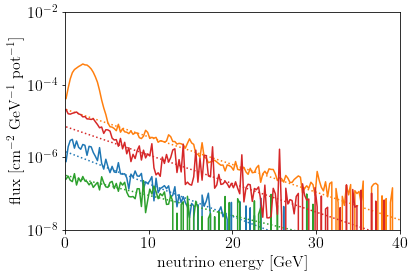

In [438]:
my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for j, f in enumerate(flavors):
    plt.plot(flux_data[f][:,0]/u.GeV, flux_data[f][:,1] * u.cm**2*u.GeV, c=my_colors[j], label=f)
    plt.plot(flux_data[f][:,0]/u.GeV, np.exp(np.poly1d(flux_fit[f])(flux_data[f][:,0])) * u.cm**2*u.GeV, c=my_colors[j], ls=':')
plt.yscale('log')
plt.xlabel('neutrino energy [GeV]')
plt.ylabel(r'flux [cm$^{-2}$ GeV$^{-1}$ pot$^{-1}$]')
plt.xlim(0,40)
plt.ylim(1e-8,1e-2)
plt.show()

In [329]:
flux_data_export = {}
for f in flavors:
    flux_data_export[f] = np.array([ flux_data[f][:,0] / u.GeV,
                                     np.where(flux_data[f][:,0] < 5*u.GeV,
                                              flux_data[f][:,1] * u.cm**2 * u.GeV,
                                              np.exp(np.poly1d(flux_fit[f])(flux_data[f][:,0])) * u.cm**2*u.GeV) ]).T
    np.savetxt('sim/fluxes/dune-numode-nu' + f + '-fitted.txt', flux_data_export[f],
               fmt=('%.3f','%12.8g'))

### Off-Axis Fluxes in GLoBES Format for Rescaling of On-Axis Results

In [588]:
globes_flux_files = sorted(glob.glob('sim/fluxes/*_neutrino_DUNEND_??.??mrad_globes_flux.txt'))
globes_oa_angles  = [ 0.001*float(re.match(r'.*DUNEND_(.*)mrad_globes_flux.*.txt', f).group(1)) for f in globes_flux_files ]
fit_E_min = {}
fit_E_max = {}
flux_data = {}
flux_fit  = {}
for j, f in enumerate(globes_flux_files):
    flux_data[j] = np.loadtxt(f)
    flux_data[j][:,0] *= u.GeV
    
    for k in range(1,flux_data[j].shape[-1]):
        # determine energy interval in which to fit the flux
        # (this involves some ugly tuning of fitting intervals by hand)
        if np.isclose(globes_oa_angles[j], 0.0):
            fit_E_min[j,k] = 5 * u.GeV
            fit_E_max[j,k] = 20 * u.GeV
        elif np.isclose(globes_oa_angles[j], 0.01045) and k in [2]:
            fit_E_min[j,k] = 15 * u.GeV
            fit_E_max[j,k] = 20 * u.GeV
        elif np.isclose(globes_oa_angles[j], 0.03136) \
          or np.isclose(globes_oa_angles[j], 0.04181):
            if k in [1,4]:
                fit_E_min[j,k] =  0 * u.GeV
                fit_E_max[j,k] =  5 * u.GeV
            else:
                fit_E_min[j,k] = 10 * u.GeV
                fit_E_max[j,k] = 15 * u.GeV
        elif np.isclose(globes_oa_angles[j], 0.05226) \
          or np.isclose(globes_oa_angles[j], 0.06272):
            if k in [1,4]:
                fit_E_min[j,k] =  0 * u.GeV
                fit_E_max[j,k] =  5 * u.GeV
            else:
                fit_E_min[j,k] =  7 * u.GeV
                fit_E_max[j,k] = 10 * u.GeV
        else:
            fit_E_min[j,k] =  5 * u.GeV
            fit_E_max[j,k] = 10 * u.GeV
    
        ii = np.where((flux_data[j][:,0] > fit_E_min[j,k])
                    & (flux_data[j][:,0] < fit_E_max[j,k])
                    & (flux_data[j][:,k] > 0))[0]
        if len(ii) == 0:   # this will happen for th \nu_\tau columns in the flux file
            flux_fit[j,k] = None
            continue
        else:
            flux_fit[j,k] = np.polyfit(flux_data[j][ii,0], np.log(flux_data[j][ii,k]), deg=1)

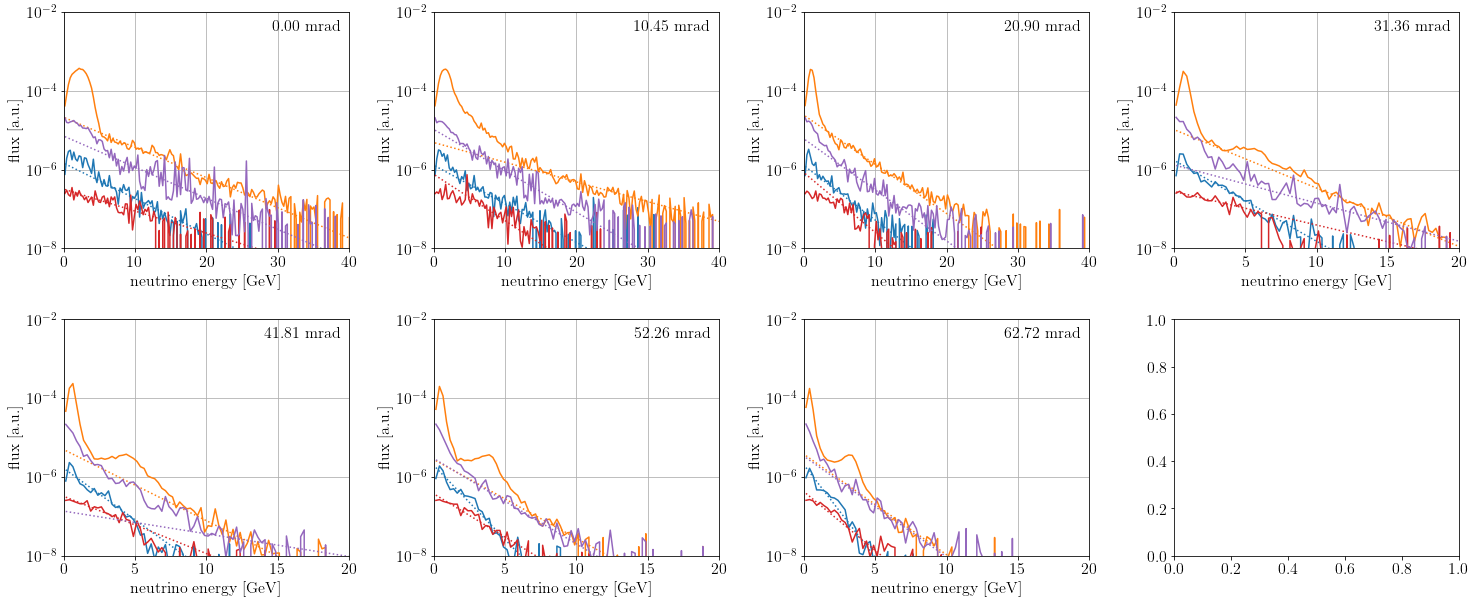

In [589]:
my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig = plt.figure(figsize=(25,10))
gs  = gridspec.GridSpec(nrows=2, ncols=4, wspace=0.3, hspace=0.3, figure=fig)
ax  = [ fig.add_subplot(gs[i,j]) for i in range(2) for j in range(4) ]

for j, f in enumerate(globes_flux_files):
    for k in range(1,flux_data[j].shape[-1]):
        if flux_fit[j,k] is not None:
            ax[j].plot(flux_data[j][:,0]/u.GeV, flux_data[j][:,k], c=my_colors[k-1], label=f)
            ax[j].plot(flux_data[j][:,0]/u.GeV, np.exp(np.poly1d(flux_fit[j,k])(flux_data[j][:,0])), c=my_colors[k-1], ls=':')
    ax[j].set_yscale('log')
    ax[j].set_xlabel('neutrino energy [GeV]')
    ax[j].set_ylabel(r'flux [a.u.]')
    ax[j].set_xlim(0,40)
    ax[j].set_ylim(1e-8,1e-2)
    if globes_oa_angles[j] > 0.03:
        ax[j].set_xlim(0,20)
    ax[j].grid(True)
    ax[j].annotate('{:.2f} mrad'.format(globes_oa_angles[j]*1e3), xy=(0.97,0.97), xycoords='axes fraction', ha='right', va='top')
plt.show()

In [591]:
flux_data_export = {}
for j, f in enumerate(globes_flux_files):
    flux_data_export[j] = np.zeros(flux_data[j].shape)
    flux_data_export[j][:,0] = flux_data[j][:,0] / u.GeV
    for k in [1,2,4,5]:
        flux_data_export[j][:,k] = np.where(flux_data[j][:,0] < fit_E_min[j,k],
                                            flux_data[j][:,k],
                                            np.exp(np.poly1d(flux_fit[j,k])(flux_data[j][:,0])))
    np.savetxt(re.sub('.txt', '-fitted.txt', f), flux_data_export[j],
               fmt=('%.3f','%12.8g','%12.8g','%12.8g','%12.8g','%12.8g','%12.8g'),
               header='GLoBES flux file for DUNE\n'
                    + 'based on beam simulations by Laura Fields,\n'
                    + 'replaced by a fitted curve in the high-energy region\n'
                    + 'by Joachim Kopp to avoid empty bins. The fit has been\n'
                    + 'linear, and its support varies according to off-axis angle\n'
                    + 'and neutrino flavor to yield a visually OK result.\n'
                    + 'Where in doubt, I have opted for *larger* fluxes because\n'
                    + 'this implies larger (more conservative) backgrounds in our\n'
                    + 'HNL study.\n'
                    + '\n'
                    + 'E [GeV]  nu_e       nu_mu           nu_tau    nu_e_bar     nu_mu_bar    nu_tau_bar')

## Production of Heavy Neutral Leptons Based on NuShock

### Load DUNE Fluxes

In [5]:
# determine available mass points for HNL fluxes
hnl_flux_files  = glob.glob('sim/nushock/flux/**/*-flux-m*.root', recursive=True)
hnl_mass_points = np.sort(list(set([ float(re.match(".*/(dune|Ds)-flux-m([0-9\.]+).*.root", f).group(2)) * u.MeV \
                                                    for f in hnl_flux_files ])))

# Load DUNE fluxes (needed for background normalization)
c = 1 / u.GeV / u.m**2 # unit conversion factor for fluxes
dune_flux_files  = np.array( glob.glob('sim/fluxes/*_neutrino_*_globes_flux-fitted.txt') )
oa_angles        = np.array([ float(re.match(".*DUNEND_([^_]+)mrad.*", f).group(1))*1e-3 for f in dune_flux_files ])
i_list           = np.argsort(oa_angles)     # sort backgrounds by off-axis angle
dune_flux_files  = dune_flux_files[i_list]
oa_angles        = oa_angles[i_list]
dune_flux_data   = { j: np.loadtxt(f) * np.array([u.GeV, c, c, c, c, c, c ])[None,:]
                                                            for j, f in enumerate(dune_flux_files) }
dune_flux_interp = { j: [ interp.interp1d(x[:,0], x[:,k], bounds_error=False, fill_value=0.)
                                                            for k in [1,2,4,5] ]
                                                            for j, x in enumerate(dune_flux_data.values()) }

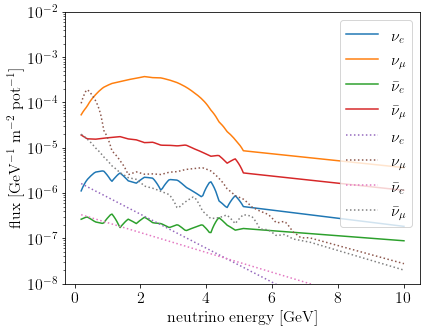

In [594]:
# plot DUNE fluxes as a sanity check
plt.figure(figsize=(14,5))
plt.subplot(121)
a       = 0
E_range = np.linspace(.2*u.GeV, 10.*u.GeV, 200)
plt.plot(E_range/u.GeV, dune_flux_interp[a][0](E_range) * u.GeV * u.m**2, label=r'$\nu_e$')
plt.plot(E_range/u.GeV, dune_flux_interp[a][1](E_range) * u.GeV * u.m**2, label=r'$\nu_\mu$')
plt.plot(E_range/u.GeV, dune_flux_interp[a][2](E_range) * u.GeV * u.m**2, label=r'$\bar\nu_e$')
plt.plot(E_range/u.GeV, dune_flux_interp[a][3](E_range) * u.GeV * u.m**2, label=r'$\bar\nu_\mu$')
a       = 5
plt.plot(E_range/u.GeV, dune_flux_interp[a][0](E_range) * u.GeV * u.m**2, ls=':', label=r'$\nu_e$')
plt.plot(E_range/u.GeV, dune_flux_interp[a][1](E_range) * u.GeV * u.m**2, ls=':', label=r'$\nu_\mu$')
plt.plot(E_range/u.GeV, dune_flux_interp[a][2](E_range) * u.GeV * u.m**2, ls=':', label=r'$\bar\nu_e$')
plt.plot(E_range/u.GeV, dune_flux_interp[a][3](E_range) * u.GeV * u.m**2, ls=':', label=r'$\bar\nu_\mu$')
plt.xlabel('neutrino energy [GeV]')
plt.ylabel('flux [GeV$^{-1}$ m$^{-2}$ pot$^{-1}$]')
plt.ylim(1e-8, 1e-2)
plt.yscale('log')
plt.legend(loc='upper right')

# plot cross section as a sanity check
# plt.subplot(122)
# E_range = np.linspace(0.5*u.GeV, 30.*u.GeV, 200)
# plt.plot(E_range/u.GeV, xsec_interp['MPI','numu'](E_range) / E_range * u.GeV/u.cm**2, label=r'$\nu_\mu \to \mu\pi$')
# plt.xlabel(r'neutrino energy [GeV]')
# plt.ylabel(r'cross section [cm$^2$ / GeV]')
# plt.yscale('log')
# plt.xscale('log')
# plt.legend(loc='upper right')
# plt.show()

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, sel

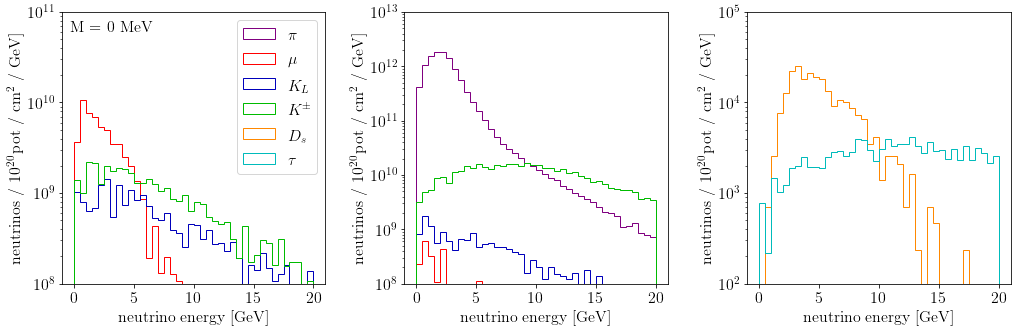

In [30]:
my_M = 0. * u.MeV

# Plot DUNE fluxes based on Ntuple files as a cross-check
my_flux=HNL_flux()
fig = plt.figure(figsize=(17,5))
gs  = gridspec.GridSpec(nrows=1, ncols=3, wspace=0.3, hspace=0.3, figure=fig)
ax  = [ fig.add_subplot(gs[0,j]) for j in range(3) ]

E_bin_edges  = np.linspace(0,20,41) * u.GeV
E_bin_widths = np.diff(E_bin_edges)
def i_list(pdg_nu, pdg_parent):
    return np.where((np.abs(my_flux.coupling_pdg_array) == abs(pdg_nu)) &
                    (np.abs(my_flux.parent_pdg_array)   == abs(pdg_parent)) &
                    (0. <= np.abs(theta_array)) & (np.abs(theta_array) < 0.01))[0]
beam_area = 4 * 0.01**2 * ND_baseline**2   # factor 4 because we allow for positive and negative angles
    
for j, (pdg_nu, c) in enumerate(zip([u.pdg_nu_e, u.pdg_nu_mu, u.pdg_nu_tau],['E','M','T'])):
    my_flux.load_HNL_fluxes(my_M, *coupling_dict[c], small_files=False)

    E_array       = my_flux.p_array[0,:]                             # HNL energies
    P_array       = my_flux.p_array[1:4,:]                           # HNL 3-momenta
    weight_array  = my_flux.weight_array
    theta_array   = np.arctan2(np.sqrt(P_array[0,:]**2 + P_array[1,:]**2), P_array[2,:])
    theta_x_array = np.arctan2(P_array[0,:], P_array[2,:])  # horizontal deviation from beam axis
    theta_y_array = np.arctan2(P_array[1,:], P_array[2,:])  # vertical deviation from beam axis
    
    ax[j].hist(             E_array[i_list(pdg_nu,u.pdg_pip)]/u.GeV, bins=E_bin_edges/u.GeV, histtype='step', color='purple',
               weights=weight_array[i_list(pdg_nu,u.pdg_pip)] * u.cm**2/beam_area * 1e20/DUNE_pot * u.GeV/np.mean(E_bin_widths), label=r'$\pi$')
    ax[j].hist(             E_array[i_list(pdg_nu,u.pdg_mu)]/u.GeV, bins=E_bin_edges/u.GeV, histtype='step', color='red',
               weights=weight_array[i_list(pdg_nu,u.pdg_mu)] * u.cm**2/beam_area * 1e20/DUNE_pot * u.GeV/np.mean(E_bin_widths), label=r'$\mu$')
    ax[j].hist(             E_array[i_list(pdg_nu,u.pdg_KL)]/u.GeV, bins=E_bin_edges/u.GeV, histtype='step', color='#0000bb',
               weights=weight_array[i_list(pdg_nu,u.pdg_KL)] * u.cm**2/beam_area * 1e20/DUNE_pot * u.GeV/np.mean(E_bin_widths), label=r'$K_L$')
    ax[j].hist(             E_array[i_list(pdg_nu,u.pdg_Kp)]/u.GeV, bins=E_bin_edges/u.GeV, histtype='step', color='#00bb00',
               weights=weight_array[i_list(pdg_nu,u.pdg_Kp)] * u.cm**2/beam_area * 1e20/DUNE_pot * u.GeV/np.mean(E_bin_widths), label=r'$K^\pm$')
    ax[j].hist(             E_array[i_list(pdg_nu,u.pdg_Ds)]/u.GeV, bins=E_bin_edges/u.GeV, histtype='step', color='#ff8800',
               weights=weight_array[i_list(pdg_nu,u.pdg_Ds)] * u.cm**2/beam_area * 1e20/DUNE_pot * u.GeV/np.mean(E_bin_widths), label=r'$D_s$')
    ax[j].hist(             E_array[i_list(pdg_nu,u.pdg_tau)]/u.GeV, bins=E_bin_edges/u.GeV, histtype='step', color='#00bbbb',
               weights=weight_array[i_list(pdg_nu,u.pdg_tau)] * u.cm**2/beam_area * 1e20/DUNE_pot * u.GeV/np.mean(E_bin_widths), label=r'$\tau$')
    ax[j].set_yscale('log')
    ax[j].set_xlabel('neutrino energy [GeV]')
    ax[j].set_ylabel('neutrinos / $10^{20}\,\\text{pot}$ / cm$^2$ / GeV]')
    
ax[0].set_ylim(1e8,1e11)
ax[1].set_ylim(1e8,1e13)
ax[2].set_ylim(1e2,1e5)
ax[0].legend(loc='upper right')
ax[0].annotate('M = {:g} MeV'.format(my_M/u.MeV), (0.03,0.97), xycoords='axes fraction', ha='left', va='top')
plt.show()

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, sel

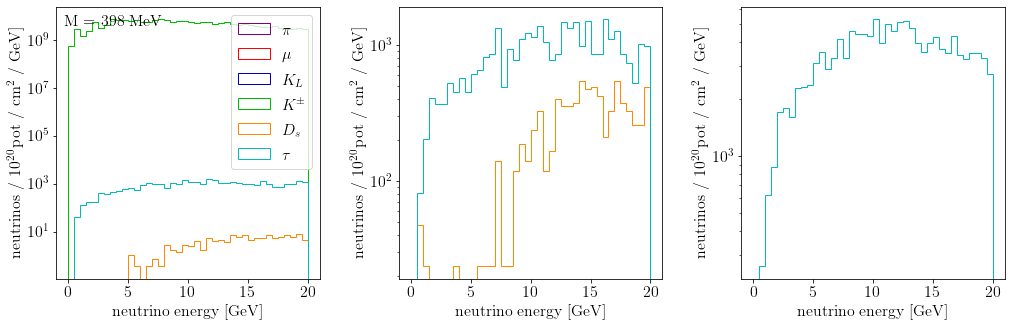

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, sel

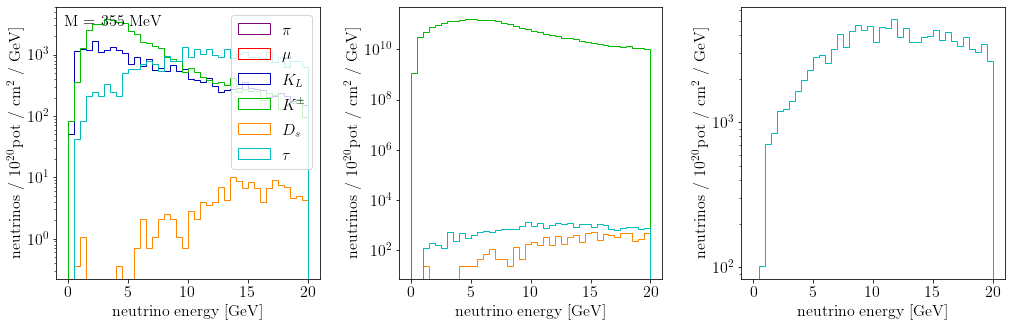

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


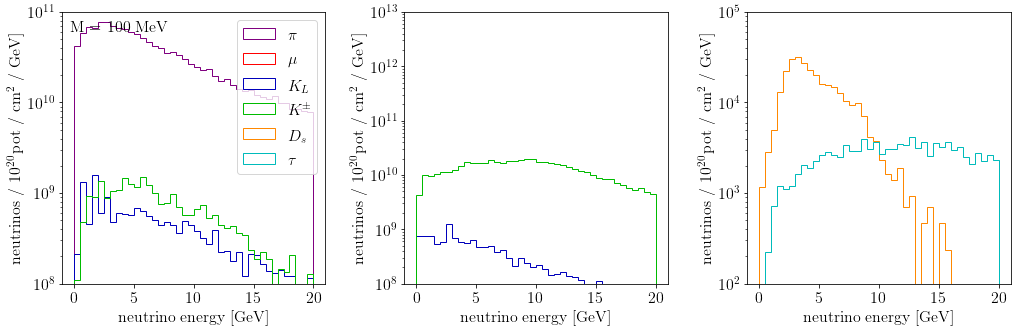

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, sel

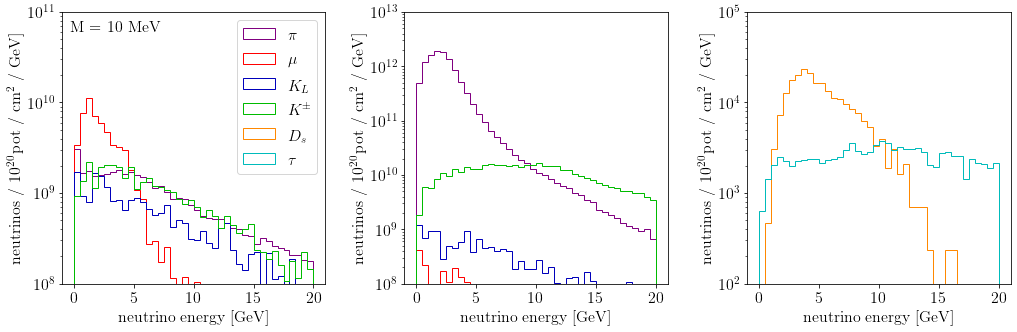

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, sel

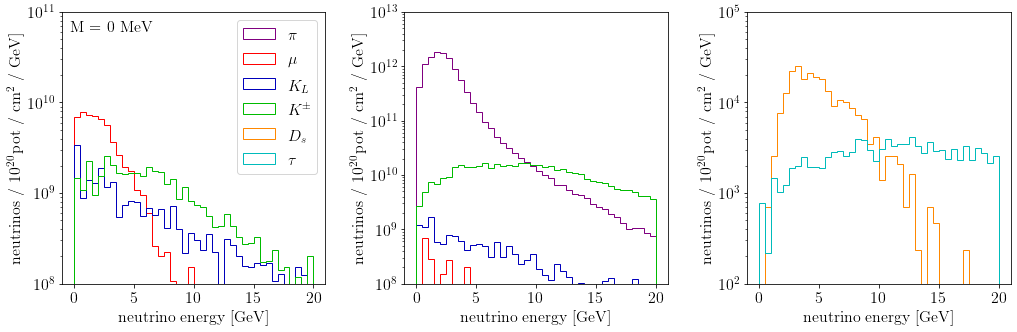

### Load Decay Branching Ratios

In [6]:
# load decay BRs as a function of HNL mass
decay_file_names   = glob.glob('sim/nushock/decay/*.dat')
decay_channels     = set([ re.match(".*/([a-zA-Z0-9]+)-(E|M|T|EMT).dat", f).group(1) for f in decay_file_names ])
decay_data         = {}
decay_br_interp    = {}
decay_width_interp = {}
for channel in decay_channels:
    for coupling in ['E','M','T','EMT']:
        c = channel + '-' + coupling
        decay_data[c]         = np.loadtxt('sim/nushock/decay/' + c + '.dat')
        decay_data[c][:,0]   *= u.GeV
        decay_data[c][:,2]   *= u.GeV
        decay_br_interp[c]    = interp.interp1d(decay_data[c][:,0], decay_data[c][:,1])
        decay_width_interp[c] = interp.interp1d(decay_data[c][:,0], decay_data[c][:,2])
    
# LaTeX labels for all decay modes
decay_labels = { 'EPI':    r'$e^\pm \pi^\mp$',      'MPI':    r'$\mu^\pm \pi^\mp$',
                 'EKA':    r'$e^\pm K^\mp$',        'MKA':    r'$\mu^\pm K^\mp$',
                 'ERHO':   r'$e^\pm \rho^\mp$',     'MRHO':   r'$\mu^\pm \rho^\mp$',
                 'EKAx':   r'$e^\pm K^{*\mp}$',     'MKAx':   r'$\mu^\pm K^{*\mp}$',
                 'ECHARM': r'$e^\pm D^\pm$',        'nEM':    r'$\nu e^\pm \mu^\mp$',
                 'nET':    r'$\nu e^\pm \tau^\mp$', 'TPI':    r'$\tau^\mp \pi^\pm$',
                 'nnn':    r'$3\nu$',               'nEE':    r'$\nu e^+e^-$',
                 'nMM':    r'$\nu\mu^+\mu^-$',      'nPI0':   r'$\nu\pi^0$',
                 'nRHO0':  r'$\nu\rho^0$',          'nOMEGA': r'$\nu\omega$',
                 'nETA':   r'$\nu\eta$',            'nETAi':  r'$\nu\eta^\prime$',   
                 'nPHI':   r'$\nu\phi$',            'nGAMMA': r'$\nu\gamma$',
                 'nMT':    r'$\nu\mu^\pm\tau^\mp$' }
decay_particle_labels = { 'EPI':    [r'$e^\pm$', r'$\pi^\pm$'],               'MPI':    [r'$\mu^\pm$', r'$\pi^\pm$'],
                          'EKA':    [],                                       'MKA':    [],
                          'ERHO':   [],                                       'MRHO':   [],
                          'EKAx':   [],                                       'MKAx':   [],
                          'ECHARM': [],                                       'nEM':    [r'$\nu$', r'$e^\pm$', r'$\mu^\pm$'],
                          'nET':    [],                                       'TPI':    [],
                          'nnn':    [],                                       'nEE':    [r'$\nu$', r'$e_1^\pm$', r'$e_2^\pm$'],
                          'nMM':    [r'$\nu$',r'$\mu_1^\pm$',r'$\mu_2^\pm$'], 'nPI0':   [r'$\nu$', r'$\gamma_1$', r'$\gamma_2$'],
                          'nRHO0':  [],                                       'nOMEGA': [],
                          'nETA':   [],                                       'nETAi':  [],
                          'nPHI':   [],                                       'nGAMMA': [],
                          'nMT':    [] }

# Plot style for the different channels
decay_colors = { 'EPI':    '#2ca02c', 'MPI':    '#2ca02c',
                 'EKA':    '#d62728', 'MKA':    '#d62728',
                 'ERHO':   '#e6ab02', 'MRHO':   '#e6ab02',
                 'EKAx':   '#1f77b4', 'MKAx':   '#1f77b4',
                 'ECHARM': '#000000', 'nEM':    '#9467bd',
                 'nET':    '#000000', 'TPI':    '#000000',
                 'nnn':    '#9467bd', 'nEE':    '#2ca02c',
                 'nMM':    '#2ca02c', 'nPI0':   '#aec7e8',
                 'nRHO0':  '#e6ab02', 'nOMEGA': '#1f77b4',
                 'nETA':   '#d62728', 'nETAi':  '#d62728',
                 'nPHI':   '#000000', 'nGAMMA': '#000000',
                 'nMT':    '#000000' }
decay_ls     = { 'EPI':    '-',       'MPI':    ':',
                 'EKA':    '-',       'MKA':    ':',
                 'ERHO':   '-',       'MRHO':   ':',
                 'EKAx':   '-',       'MKAx':   ':',
                 'ECHARM': '-',       'nEM':    '-',
                 'nET':    '-',       'TPI':    '-',
                 'nnn':    '--',      'nEE':    '--',
                 'nMM':    '-.',      'nPI0':   '--',
                 'nRHO0':  '--',      'nOMEGA': '--',
                 'nETA':   '--',      'nETAi':  '-.',
                 'nPHI':   '--',      'nGAMMA': '--',
                 'nMT':    '--' }

### Load Background Computed in NuShock

In [7]:
flavors         = ['nue','numu','nuebar','numubar']
all_bg_files    = glob.glob('sim/nushock/backgrounds/bg-*.root')
all_bg_channels = list(set([ re.match(r'.*bg-nu.*-.*_(.*)\.root', f).group(1) for f in all_bg_files ]))

# read backgrounds from all initial neutrino flavors, for all channels, and for all simulated energy range
bg_E1           = {}
bg_E2           = {}
bg_th1          = {}
bg_th2          = {}
bg_p1           = {}
bg_p2           = {}
bg_Enu          = {}
bg_weights      = {}
for ch in all_bg_channels:
    print(ch)
    for k, fl in enumerate(flavors):
        bg_E1[ch,fl]      = np.array([])
        bg_E2[ch,fl]      = np.array([])
        bg_th1[ch,fl]     = np.array([])
        bg_th2[ch,fl]     = np.array([])
        bg_p1[ch,fl]      = np.empty(shape=(0,4))
        bg_p2[ch,fl]      = np.empty(shape=(0,4))
        bg_Enu[ch,fl]     = np.array([])
        bg_weights[ch,fl] = np.array([])
        for E_range in ['lowE','highE','VHE']:
            bg_file_name = 'sim/nushock/backgrounds/bg-' + fl + '-' + E_range + '_' + ch + '.root'
            with uproot.open(bg_file_name) as f:
                bg_data        = f['Data']
                this_bg_E1     = np.array(bg_data['E_A'].array()) * u.GeV
                this_bg_E2     = np.array(bg_data['E_B'].array()) * u.GeV
                this_bg_P1     = np.array(bg_data['P_A'].array()) * u.GeV
                this_bg_P2     = np.array(bg_data['P_B'].array()) * u.GeV
                this_bg_th1    = np.array(bg_data['TheA'].array())
                this_bg_th2    = np.array(bg_data['TheB'].array())
                this_bg_phi1   = np.array(bg_data['PhiA'].array())
                this_bg_phi2   = np.array(bg_data['PhiB'].array())
                this_bg_p1     = np.array([ this_bg_P1*np.sin(this_bg_th1)*np.cos(this_bg_phi1),
                                            this_bg_P1*np.sin(this_bg_th1)*np.sin(this_bg_phi1),
                                            this_bg_P1*np.cos(this_bg_th1),
                                            this_bg_E1 ]).T
                this_bg_p2     = np.array([ this_bg_P2*np.sin(this_bg_th2)*np.cos(this_bg_phi2),
                                            this_bg_P2*np.sin(this_bg_th2)*np.sin(this_bg_phi2),
                                            this_bg_P2*np.cos(this_bg_th2),
                                            this_bg_E2 ]).T
                
                # compute weights (for on-axis backgrounds)
                this_bg_Enu    = bg_data['E_nu'].array() * u.GeV
                this_bg_xsec   = bg_data['xsec'].array() * 1e-38*u.cm**2
                if len(this_bg_Enu) > 1:
                    this_bg_xsec_interp = interp.interp1d(this_bg_Enu, this_bg_xsec, assume_sorted=False)
                    this_bg_weights = np.ones(len(this_bg_Enu)) * DUNE_n_targets * DUNE_pot / len(this_bg_Enu) \
                                    * integ.quad(lambda E: this_bg_xsec_interp(E) * dune_flux_interp[0][k](E),
                                                          np.min(this_bg_Enu), np.max(this_bg_Enu))[0]
                else:
                    this_bg_weights = np.zeros(len(this_bg_Enu))
                
                # concatenate output arrays
                bg_E1[ch,fl]      = np.concatenate((bg_E1[ch,fl],      this_bg_E1))
                bg_E2[ch,fl]      = np.concatenate((bg_E2[ch,fl],      this_bg_E2))
                bg_th1[ch,fl]     = np.concatenate((bg_th1[ch,fl],     this_bg_th1))
                bg_th2[ch,fl]     = np.concatenate((bg_th2[ch,fl],     this_bg_th2))
                bg_p1[ch,fl]      = np.concatenate((bg_p1[ch,fl],      this_bg_p1))
                bg_p2[ch,fl]      = np.concatenate((bg_p2[ch,fl],      this_bg_p2))
                bg_Enu[ch,fl]     = np.concatenate((bg_Enu[ch,fl],     this_bg_Enu))
                bg_weights[ch,fl] = np.concatenate((bg_weights[ch,fl], this_bg_weights))


MPI
nnn
MRHO
ECHARM
nEE
nPI0
MKAx
EPI
nMT
nET
EKA
nEM
nETA
nOMEGA
nPHI
TPI
nETAi
nGAMMA
EKAx
MKA
ERHO
nRHO0
nMM


### Load GENIE Events for our own Background Calculation

In [319]:
flavors      = ['nue','numu','nuebar','numubar']
flavor_ids   = [ 12,    14,     -12,     -14   ]
genie_weight = np.array([])
#genie_pdg    = awkward.Array.fromcounts([],np.empty((0),dtype=int))
#genie_p      = awkward.Array.fromcounts([],np.empty((0,4),dtype=int))
genie_pdg    = awkward.Array(np.empty((0),dtype=int))
genie_p      = awkward.Array(np.empty((0,4),dtype=int))
genie_E_nu   = np.array([])
genie_nu_ids = np.array([], dtype=int)

# read GENIE events from file
# note: energy is 4th component of GENIE 4-momentum vectors
for k, fl in enumerate(flavors):
    for E_range in ['lowE','highE','VHE']:
        print(fl, ' ', E_range)
        genie_file_name = 'sim/genie/events/dune-numode-' + fl + '-' + E_range + '.gtrac.root'
        with uproot.open(genie_file_name) as f:
            genie_data        = f['gRooTracker']
            this_genie_pdg    = np.abs(genie_data['StdHepPdg'].array())
            this_genie_status = genie_data['StdHepStatus'].array()
            this_genie_p      = genie_data['StdHepP4'].array() * u.GeV

            # neutrino energies - GENIE always outputs the neutrino first (but to be sure we check)
            if not awkward.all( ( (abs(this_genie_pdg[:,0]) == u.pdg_nu_e) |
                                  (abs(this_genie_pdg[:,0]) == u.pdg_nu_mu) |
                                  (abs(this_genie_pdg[:,0]) == u.pdg_nu_tau) ) & this_genie_status[:,0] == 0 ):
                raise ValueError('first entry of event record is not an initial state neutrino.')
            this_genie_E_nu   = awkward.to_numpy(this_genie_p[:,0,3]).flatten()
            
            # read cross sections from this GENIE file and interpolate
            genie_xsec        = genie_data['EvtXSec'].array() * 1e-38*u.cm**2
            genie_xsec_interp = interp.interp1d(this_genie_E_nu, genie_xsec, assume_sorted=False)
            
            # compute weights
            genie_weight = np.concatenate((genie_weight,
                                           np.ones(len(this_genie_E_nu)) * DUNE_n_targets * DUNE_pot / len(this_genie_E_nu)
                                         * integ.quad(lambda E: genie_xsec_interp(E) * dune_flux_interp[0][k](E),
                                                      np.min(this_genie_E_nu), np.max(this_genie_E_nu))[0] ))
            
            # keep only final state particles
            this_genie_fs_mask = (this_genie_status == 1)
            this_genie_pdg     = this_genie_pdg[this_genie_fs_mask]
            this_genie_p       = this_genie_p[this_genie_fs_mask]
            
            # concatenate output arrays
            genie_pdg    = awkward.concatenate([genie_pdg,    this_genie_pdg])
            genie_p      = awkward.concatenate([genie_p,      this_genie_p])
            genie_E_nu   = np.concatenate((genie_E_nu,   this_genie_E_nu))
            genie_nu_ids = np.concatenate((genie_nu_ids, np.full(this_genie_E_nu.shape, flavor_ids[k])))
            
            genie_xsec        = None
            genie_xsec_interp = None
            genie_fs_indices  = None
            
# count the number of particles of each species in each event
genie_particle_counts = { this_id : awkward.to_numpy( awkward.count_nonzero(genie_pdg == this_id, axis=1) )
                                        for this_id in set(awkward.to_numpy(awkward.flatten(this_genie_pdg))) }

# convert results to the much easier-to-use awkward0 format
genie_p   = awkward.to_awkward0(genie_p)
genie_pdg = awkward.to_awkward0(genie_pdg)

# compute angles w.r.t. the beam axis
genie_th  = np.atan2( np.sqrt(genie_p[:,:,0]**2 + genie_p[:,:,1]**2), genie_p[:,:,2]**2 )

nue   lowE


In [299]:
# generate pi0 -> \gamma e+ e- decays for the background to N -> \nu e e
# we randomly pick pi0's from our events according to the appropriate BR of 1.174% and then decay them
pi0_event_mask = np.where((genie_particle_counts[u.pdg_pi0] > 0)         # true for events with pi0 -> \gamma e+ e- decays, false otherwise
                        & (rnd.rand(len(genie_particle_counts[u.pdg_pi0])) < 0.01174*genie_particle_counts[u.pdg_pi0]), True, False)  
pi0_event_ids  = np.where(pi0_event_mask)[0]                             # IDs of events containing pi0's
i_pi0 = np.array([ rnd.choice(np.where(p==u.pdg_pi0)[0])                 # pick one pi0 in each event
                             for p in genie_pdg[pi0_event_ids] ])
p_pi0 = np.array([ pp[i] for i, pp in zip(i_pi0,genie_p[pi0_event_ids]) ]) # get its momentum

pi0_decay_weights, pi0_decay_particles = phasespace.nbody_decay(u.m_pi0, [0,u.m_e,u.m_e]).generate(n_events=len(p_pi0), boost_to=p_pi0)
                                                                         # decay pions

tmp_pdg_list              = [ (list(p) + [u.pdg_e,u.pdg_e] if b else p)  # build modified PDG ID list
                                    for b, p in zip(pi0_event_mask, genie_pdg) ]
tmp_pdg_counts            = [ len(x) for x in tmp_pdg_list ]
genie_pdg_with_pi0_decays = awkward0.JaggedArray.fromcounts(tmp_pdg_counts, list(itertools.chain(*tmp_pdg_list)))

tmp_p_list                = [ (np.array(list(p) + [[0,0,0,0],[0,0,0,0]]) if b else p) # build modified momentum list
                                    for b, p in zip(pi0_event_mask, genie_p) ]
tmp_p_counts              = [ len(x) for x in tmp_p_list ]
genie_p_with_pi0_decays = awkward0.JaggedArray.fromcounts(tmp_p_counts, list(itertools.chain(*tmp_p_list)))
genie_p_with_pi0_decays.content[genie_p_with_pi0_decays.stops[pi0_event_ids] - 2] = pi0_decay_particles['p_1']
genie_p_with_pi0_decays.content[genie_p_with_pi0_decays.stops[pi0_event_ids] - 1] = pi0_decay_particles['p_2']

genie_particle_counts_with_pi0_decays = copy.deepcopy(genie_particle_counts)
genie_particle_counts_with_pi0_decays[u.pdg_e][pi0_event_mask] += 2

genie_th_with_pi0_decays = np.atan2( np.sqrt(genie_p_with_pi0_decays[:,:,0]**2 + genie_p_with_pi0_decays[:,:,1]**2),
                                     genie_p_with_pi0_decays[:,:,2]**2 )

### Analysis Functions

#### Signal Rates and Spectra

In [12]:
class HNL_flux:
    """Data structure holding the heavy neutral lepton fluxes at a given mass from 
       a ROOT Ntuple files
    
       Arguments:
         M:            HNL mass for which the fluxes should be loaded. Will be rounded to integer
                       multiples of 1 MeV and is used to construct the name of the flux file
         Ue4:          mixing with \nu_e
         Um4:          mixing with \nu_\mu
         Ut4:          mixing with \nu_\tau
                       Make sure that the ratios of Ue4, Um4, Ut4 are the same as the ones used
                       when running ./compute-decay-BRs from the shell!
         small_files:  if True, use only 10 flux Ntuple files. Otherwise, use 100
         include_pi_K: if True (the default), include HNL fluxes from pi and K decays
         include_Ds:   if True (the default), include HNL fluxes from D_s decays
              
       Contained data structures:
         p_array:            array of HNL 4-momenta, shape (4, N)
         X_array:            array of HNL production coordinates, shape (3, N)
         weight_array:       array of HNL weights
         coupling_pdg_array: the PDG codes of the neutrino flavor that each HNL replaces"""
    
    def __init__(self):
        self.M   = None
        self.Ue4 = None
        self.Um4 = None
        self.Ut4 = None
    
    def load_HNL_fluxes(self, M, Ue4=1., Um4=1., Ut4=1., small_files=False, include_pi_K=True, include_Ds=True):        
        self.M   = M
        self.Ue4 = Ue4
        self.Um4 = Um4
        self.Ut4 = Ut4

        if include_pi_K:
            if small_files:
                root_file_names_DUNE = glob.glob('sim/nushock/flux/dune-flux-m' + str(int(round(M/u.MeV))) + '-small.root')
                n_files_DUNE         = len(root_file_names_DUNE) * 10   # 10 individual files have been combined into each .small.root file
            else:
                root_file_names_DUNE = glob.glob('sim/nushock/flux/dune-flux-m' + str(int(round(M/u.MeV))) + '.root')
                n_files_DUNE         = len(root_file_names_DUNE) * 100  # 100 individual files have been combined into each .root file
        else:
            root_file_names_DUNE = []
            n_files_DUNE         = 0

        if include_Ds:
            root_file_names_Ds = glob.glob('sim/nushock/flux/Ds-120-GeV/Ds-flux-m' + str(int(round(M/u.MeV))) + '.root')
            n_files_Ds         = len(root_file_names_Ds)
        else:
            root_file_names_Ds = []
            n_files_Ds = 0
            
        root_file_names = root_file_names_DUNE + root_file_names_Ds
    
        # normalization factor for each file: each DUNE flux file corresponds to 1e5 pot
        #                                     Ds flux files are per pot
        norm                 = [ (1e5 * n_files_DUNE) / DUNE_pot ] * len(root_file_names_DUNE) \
                             + [ n_files_Ds / DUNE_pot] * len(root_file_names_Ds)
    
        if len(root_file_names) == 0:
            print("no flux data found at mass m_HNL = " + str(int(round(M/u.MeV))) + " MeV. Aborting.")
            return np.empty((4,0)), np.empty((3,0)), np.empty((0)), np.empty((0), dtype=int)

        self.p_array            = np.empty((4,0))
        self.X_array            = np.empty((3,0))
        self.weight_array       = np.empty((0))
        self.coupling_pdg_array = np.empty((0), dtype=int)
        self.parent_pdg_array   = np.empty((0), dtype=int)
        for this_file_name, this_norm in zip(root_file_names, norm):
            with uproot.open(this_file_name) as f:
                root_data = f['Data']
# #                self.p_array = np.concatenate((self.p_array,
# #                            np.stack( root_data.arrays(['E','px','py','pz']).values(), axis=0 )), axis=1)
# #                self.X_array = np.concatenate((self.X_array,
# #                            np.stack( root_data.arrays(['x','y','z']).values(), axis=0 )), axis=1)
                self.p_array = np.concatenate((self.p_array,
                                np.array([ root_data['E'].array(),
                                           root_data['px'].array(),
                                           root_data['py'].array(),
                                           root_data['pz'].array() ])), axis=1)
                self.X_array = np.concatenate((self.X_array,
                                np.array([ root_data['x'].array(),
                                           root_data['y'].array(),
                                           root_data['z'].array() ])), axis=1)
#                 self.p_array = np.concatenate((self.p_array,
#                                 awkward.to_numpy(root_data.arrays(['E','px','py','pz'])).view(np.float64).reshape(-1,4).T), axis=1)
#                 self.X_array = np.concatenate((self.X_array,
#                                 awkward.to_numpy(root_data.arrays(['x','y','z'])).view(np.float64).reshape(-1,3).T), axis=1)
                                                             
                self.weight_array       = np.concatenate((self.weight_array,       np.array(root_data['weight'].array()) / this_norm))
                self.coupling_pdg_array = np.concatenate((self.coupling_pdg_array, np.array(root_data['coupling_pdg'].array())))
                if b'parent_pdg' in root_data.keys():
                    self.parent_pdg_array = np.concatenate((self.parent_pdg_array, np.array(root_data['parent_pdg'].array())))
            
        # unit conversion
        self.p_array *= u.GeV
        self.X_array *= u.cm
        self.X_array -= np.array([0, 0, ND_baseline])[:,None] # in our convention, the target is 574 meters upstream of the ND
    
        # multiply weights with the appropriate mixing matrix elements
        self.weight_array[ np.where(np.abs(self.coupling_pdg_array)==u.pdg_nu_e)   ] *= np.abs(Ue4)**2
        self.weight_array[ np.where(np.abs(self.coupling_pdg_array)==u.pdg_nu_mu)  ] *= np.abs(Um4)**2
        self.weight_array[ np.where(np.abs(self.coupling_pdg_array)==u.pdg_nu_tau) ] *= np.abs(Ut4)**2

# -------------------------------------------------------------------------------------------------

def HNL_flux_oa(p_array, X_array, weight_array, decay_modes, couplings, theta_oa, M, Usq=1.,
                include_NDGAr=True, include_NDLAr=True):
    """determine the HNL flux in the ND-LAr and ND-GAr detectors as a function
       of the off-axis angle theta_oa.
       
       Arguments:
         p_array:      4-momenta of the HNLs (a (4,n) array)
         X_array:      starting points of the HNLs (a (3,n) array)
         weight_array: the input weight of each HNL
         decay_modes:  the list of decay modes to include (string array). Each entry should be
                       the name of a decay channel
         couplings:    one of the string constants 'E', 'M', 'T', 'EMT' indicating
                       whether to assume coupling only to \nu_e, only to \nu_\mu,
                       only to \nu_\tau, or coupling to all three active neutrino flavors
         theta_oa:     the off-axis angle
         M:            HNL mass
         Usq:          squared mixing matrix element. This is an overall scaling factor
                       for |Ue4|^2, |Um4|^2, and |Ut4|^2. If these couplings are different,
                       this must be indicated by the appropriate value of couplings, and
                       in load_HNL_fluxes().
                       If Ue4, Um4, Ut4 were != 1 in compute-decay-BRs, Usq is an *additional*
                       scaling factor. The physics mixings are the products of Usq and the |Ux4|^2
                       used in compute-decay-BRs.
                       This parameter can be a NumPy array.
        include_NDGAr: boolean. Include HNL decays in the NDGAr detector?
        include_NDLAr: boolean. Include HNL decays in the NDGAr detector?
         
       Returns:
         weight_array: the HNL weights, multiplied by the probability for a
                       decay into a particular decay mode to happen inside the detector
                       (a dictionary of 2d arrays (n_events x len(Usq)), indexed with the decay modes)"""
    
    # check that couplings has an allowed value
    if not couplings in ['E','M','T','EMT']:
        raise ValueError("couplings must be 'E', 'M', 'T', or 'EMT'")
    
    # make sure Usq is a NumPy array
    if np.isscalar(Usq):
        Usq = np.array([Usq])
    else:
        Usq = np.array(Usq)
    
    E_array = p_array[0,:]                                # HNL energies
    P_array = p_array[1:4,:]                              # HNL 3-momenta
    n_array = P_array / sp.linalg.norm(P_array, axis=0)   # unit vectors along HNL momenta
    
    # define detector geometry [in cm]
    # the axis are: x - horizontal (transverse to beam)
    #               y - vertical (transverse to beam)
    #               z - along the beam axis
    dim_NDLAr = np.array([700, 300, 500]) * u.cm # [x, y, z], cuboid shape, see DUNE ND CDR, sec. 2.1
    dim_NDGAr = np.array([500, 260])      * u.cm # [x, r], horizontal cylindrical shape, see DUNE ND CDR, sec. 3.3.1
    T = trimesh.transformations.translation_matrix([ND_baseline*np.sin(theta_oa), 0, 0])  # translation to off-axis location
    NDLAr_mesh = trimesh.creation.box(dim_NDLAr, transform=T)
    NDGAr_mesh = trimesh.creation.cylinder(radius=dim_NDGAr[1], height=dim_NDGAr[0], sections=32,
                                           transform=trimesh.transformations.concatenate_matrices(T,
                                                        trimesh.transformations.translation_matrix([0,0,6*u.m]),
                                                        trimesh.transformations.rotation_matrix(np.pi/2, [0,1,0])))

    # find intersection points of HNL trajectories and detectors
    if include_NDLAr:
        NDLAr_intersector = trimesh.ray.ray_pyembree.RayMeshIntersector(NDLAr_mesh)
        NDLAr_entry_vertices, NDLAr_contained_HNLs, NDLAr_entry_faces = \
          NDLAr_intersector.intersects_location(ray_origins=X_array.T, ray_directions=n_array.T)
    
    if include_NDGAr:
        NDGAr_intersector = trimesh.ray.ray_pyembree.RayMeshIntersector(NDGAr_mesh)
        NDGAr_entry_vertices, NDGAr_contained_HNLs, NDGAr_entry_faces = \
          NDGAr_intersector.intersects_location(ray_origins=X_array.T, ray_directions=n_array.T)
    
    # determine travel distance inside detector
    if include_NDLAr:
        i_array_LAr          = np.argsort(NDLAr_contained_HNLs)
        NDLAr_entry_vertices = NDLAr_entry_vertices[i_array_LAr]
        NDLAr_contained_HNLs = NDLAr_contained_HNLs[i_array_LAr]
        d1_LAr               = np.zeros(shape=np.unique(NDLAr_contained_HNLs).shape)
        d2_LAr               = np.zeros(shape=np.unique(NDLAr_contained_HNLs).shape)
        for k, [j1, j2] in enumerate(zip(*find_runs(NDLAr_contained_HNLs))):
            v_array   = NDLAr_entry_vertices[j1:j2]                # all vertices found by PyEmree
            v1, v2    = v_array[np.argsort(v_array[:,2])][[0,-1]]  # find vertices with minimum and maximum z coordinate
            d1_LAr[k] = np.linalg.norm(v1 - X_array[:,NDLAr_contained_HNLs[j1]]) # distance from production point to entry point
            d2_LAr[k] = np.linalg.norm(v2 - X_array[:,NDLAr_contained_HNLs[j1]]) # distance from production point to exit point
        NDLAr_contained_HNLs = np.unique(NDLAr_contained_HNLs)
    else:
        NDLAr_contained_HNLs = np.array([], dtype=int)

    if include_NDGAr:
        i_array_GAr          = np.argsort(NDGAr_contained_HNLs)
        NDGAr_entry_vertices = NDGAr_entry_vertices[i_array_GAr]
        NDGAr_contained_HNLs = NDGAr_contained_HNLs[i_array_GAr]
        d1_GAr               = np.zeros(shape=np.unique(NDGAr_contained_HNLs).shape)
        d2_GAr               = np.zeros(shape=np.unique(NDGAr_contained_HNLs).shape)
        for k, [j1, j2] in enumerate(zip(*find_runs(NDGAr_contained_HNLs))):
            v_array   = NDGAr_entry_vertices[j1:j2]                # all vertices found by PyEmree
            v1, v2    = v_array[np.argsort(v_array[:,2])][[0,-1]]  # find vertices with minimum and maximum z coordinate
            d1_GAr[k] = np.linalg.norm(v1 - X_array[:,NDGAr_contained_HNLs[j1]]) # distance from production point to entry point
            d2_GAr[k] = np.linalg.norm(v2 - X_array[:,NDGAr_contained_HNLs[j1]]) # distance from production point to exit point
        NDGAr_contained_HNLs = np.unique(NDGAr_contained_HNLs)
    else:
        NDGAr_contained_HNLs = np.array([], dtype=int)
    
    # determine weight factor corresponding to each decay mode
    weight_array_out = {}
    for dec in decay_modes:
        weight_array_out[dec] = np.zeros((len(weight_array),len(Usq)))
        dd = dec + '-' + couplings
        if not dd in decay_data.keys():
            print("Decay channel " + dec + " unknown. Skipping.")
            continue
        
        this_BR          = decay_br_interp[dd](M)
        this_total_width = decay_width_interp[dd](M)
        
        if include_NDLAr:
            tau_HNL_LAr = 1. / (Usq[None,:] * this_total_width) * E_array[NDLAr_contained_HNLs][:,None] / M
            dexp_LAr    = np.where((d1_LAr[:,None]/tau_HNL_LAr < 1e-5) & (d2_LAr[:,None]/tau_HNL_LAr < 1e-5),
                                   (d2_LAr[:,None] - d1_LAr[:,None])/tau_HNL_LAr,
                                   np.exp(-d1_LAr[:,None]/tau_HNL_LAr) - np.exp(-d2_LAr[:,None]/tau_HNL_LAr))
                                       # for very ong-lived HNLs, expand exp to avoid loss of precision
            weight_array_out[dec][NDLAr_contained_HNLs] += weight_array[NDLAr_contained_HNLs][:,None] * this_BR * dexp_LAr
        if include_NDGAr:
            tau_HNL_GAr = 1. / (Usq[None,:] * this_total_width) * E_array[NDGAr_contained_HNLs][:,None] / M
            dexp_GAr    = np.where((d1_GAr[:,None]/tau_HNL_GAr < 1e-5) & (d2_GAr[:,None]/tau_HNL_GAr < 1e-5),
                                   (d2_GAr[:,None] - d1_GAr[:,None])/tau_HNL_GAr,
                                   np.exp(-d1_GAr[:,None]/tau_HNL_GAr) - np.exp(-d2_GAr[:,None]/tau_HNL_GAr))
            weight_array_out[dec][NDGAr_contained_HNLs] += weight_array[NDGAr_contained_HNLs][:,None] * this_BR * dexp_GAr

    return weight_array_out

# -------------------------------------------------------------------------------------------------

def decay_spectrum(p_array, X_array, weight_array, decay_channels, couplings, theta_oa, M, Usq,
                   decay_pi0s=False, include_NDGAr=True, include_NDLAr=True):
    """compute the spectra of HNL decay products for the given off-axis angle, the
       given decay channels, and the given mixing matrix scaling.
    
       Arguments:
         p_array:        4-momenta of the HNLs (a (4,n) array)
         X_array:        starting points of the HNLs (a (3,n) array)
         weight_array:   the input weight of each HNL
         decay_modes:    the list of decay modes to include (string array). Each entry should be
                         the name of a decay channel
         couplings:      one of the string constants 'E', 'M', 'T', 'EMT' indicating
                         whether to assume coupling only to \nu_e, only to \nu_\mu,
                         only to \nu_\tau, or coupling to all three active neutrino flavors
         theta_oa:       the off-axis angle
         M:              HNL mass
         Usq:            squared mixing matrix element. This is an overall scaling factor
                         for |Ue4|^2, |Um4|^2, and |Ut4|^2. If these couplings are different,
                         this must be indicated by the appropriate value of couplings, and
                         in load_HNL_fluxes().
                         If Ue4, Um4, Ut4 were != 1 in compute-decay-BRs, Usq is an *additional*
                         scaling factor. The physics mixings are the products of Usq and the |Ux4|^2
                         used in compute-decay-BRs.
                         This parameter can be a NumPy array.
        decay_pi0s:      whether to decay the pi0's in the N->\nu\pi^0 channel to two photons or keep them
                         as pi0's
        include_NDGAr:   boolean. Include HNL decays in the NDGAr detector?
        include_NDLAr:   boolean. Include HNL decays in the NDGAr detector?

                         
        Returns:
          E_final_array:      a dictionary indexed by the channel IDs. Each entry is an array of energies
                              of dimension (n_events, len(pdg_ids))
          weight_final_array: a dictionary indexed by the channel IDs. The entries are arrays of the
                              same length as the corresponding entries of E_final_array containing
                              the weights for each particle)
          pdg_ids:            dictionary containing the PDG IDs of the final state particles for each channel"""

    # make sure Usq is a NumPy array
    if np.isscalar(Usq):
        Usq = np.array([Usq])
    else:
        Usq = np.array(Usq)
    
    E_array = p_array[0,:]      # HNL energies
    P_array = p_array[1:4,:]    # HNL 3-momenta
    v_array = P_array / E_array # HNL velocities
       
    # obtain HNL events with the appropriate weight factors for this off-axis angle
    weight_array_1 = HNL_flux_oa(p_array, X_array, weight_array, decay_channels, couplings,
                                 theta_oa, M=M, Usq=Usq, include_NDGAr=include_NDGAr, include_NDLAr=include_NDLAr)
    
    # read decay MC events
    root_file_name_decay = 'sim/nushock/decay/events-' + couplings + '-m' + str(int(round(M/u.MeV))) + '.root'
    with uproot.open(root_file_name_decay) as f:
        root_data      = f['Data']
        
        # pick a decay for each HNL
        E_final_array      = {}
        th_final_array     = {}
        weight_final_array = {}
        pdg_ids            = {}
        for ch in decay_channels:
            E_final_array[ch]      = np.array([[]])
            th_final_array[ch]     = np.array([[]])
            pdg_ids[ch]            = np.array([], dtype=int)
            weight_final_array[ch] = np.empty((0,len(Usq)))

            # select HNLs that have a non-zero weight, i.e. decay inside the detector
            # this check needs to be done for only one value of Usq (hence only on weight_array_1[ch][:,0])
            detectable_HNLs = np.where(np.sum(weight_array_1[ch],axis=1) > 0.)[0]

            # select all HNL decays for the current channel
            relevant_decays = awkward.where(root_data['channel'].array() == ch)[0] # all events with decay channel ch
#            relevant_decays = np.where(np.array(root_data['channel'].array()) == ch)[0]  # all events with decay channel ch
            if len(relevant_decays) == 0:   # no decays found, for instance because decay mode is kinematically forbidden
                continue
            if len(detectable_HNLs) > len(relevant_decays):
                print("decay_spectrum: WARNING: more HNL events ({:d}) than decay events ({:d}).".format(len(detectable_HNLs), len(relevant_decays)))
            chosen_decays   = rnd.choice(relevant_decays, size=len(detectable_HNLs))
            if len(chosen_decays) <= 0:
                continue
            
            # read decay events
            p0_array    = np.array([ root_data['E'].array()[chosen_decays], # 4-momenta in HNL rest frame
                                     root_data['px'].array()[chosen_decays],#   shape: 4, n_HNL, (# of f.s. particles)
                                     root_data['py'].array()[chosen_decays],
                                     root_data['pz'].array()[chosen_decays] ], dtype=float) * u.GeV
            pdg_ids[ch] = np.abs(np.array(root_data['pdg_id'].array()[chosen_decays[0]]))  # IDs of the f.s. particles in this decay mode
            
            # boost decay products from HNL rest frame to lab frame
            # lorentz_boost expects the t-component to be the 4th component of a 4-vector,
            # and it requires the Lorentz index to be the last index
            # output shape is n_HNL, (# of f.s. particles), 4
            #   time is the *last* component of the 4-vectors now, following the conventions of the phasespace package
            p1_array = np.array( my_lorentz_boost(np.transpose(p0_array[[1,2,3,0]],(1,2,0)),
                                                               np.repeat(v_array.T[detectable_HNLs,None,:], len(pdg_ids[ch]), axis=1)) )
            
            # compute spectrum for each species of visible decay products
            invisible_particles = np.where(np.isin(abs(pdg_ids[ch]), [u.pdg_nu_e, u.pdg_nu_mu, u.pdg_nu_tau]))
            pdg_ids[ch] = np.delete(pdg_ids[ch], invisible_particles)
            p1_array    = np.delete(p1_array, invisible_particles, axis=1)
            E_final_array[ch]      = p1_array[:,:,3]
            th_final_array[ch]     = np.arctan2( np.sqrt(p1_array[:,:,0]**2 + p1_array[:,:,1]**2), p1_array[:,:,2] )
            weight_final_array[ch] = weight_array_1[ch][detectable_HNLs]
            
            # special treatment for the N -> \nu \pi^0 channel. NuShock identifies this channel by
            # requiring two photons, while we keep the pi0's. Therefore, when using NuShock's background
            # model, decay the pi0's.
            if ch.upper() == 'NPI0' and decay_pi0s:
                ww, pp = phasespace.nbody_decay(u.m_pi0, [0,0]).generate(n_events=len(E_final_array[ch]),
                            boost_to=np.array([np.zeros(E_final_array[ch][:,0].shape),
                                               np.zeros(E_final_array[ch][:,0].shape),
                                               np.sqrt(E_final_array[ch][:,0]**2 - u.m_pi0**2),
                                               E_final_array[ch][:,0]]).T)
                if np.abs(np.amax(ww) - 1.) > 1e-10  or  np.abs(np.amin(ww) - 1.) > 1e-10:
                    raise ValueError("pi0 decay led to weights != 1. I don't know how to deal with this.")
                E_final_array[ch]  = np.array([pp['p_0'][:,3], pp['p_1'][:,3]]).T
                th_final_array[ch] = np.array([ np.arctan2( np.sqrt(pp['p_0'][:,0]**2 + pp['p_0'][:,1]**2), pp['p_0'][:,2] ),
                                                np.arctan2( np.sqrt(pp['p_1'][:,0]**2 + pp['p_1'][:,1]**2), pp['p_1'][:,2] ) ]).T
                pdg_ids[ch] = [ u.pdg_gamma, u.pdg_gamma ]
            
            # if a particle type appears multiple times, sort the corresponding particles by energy
            # (in descending order)
            for p_id in set(pdg_ids[ch]):
                ii     = np.where(pdg_ids[ch] == p_id)    # indices of all particles of type p_id
                i_sort = np.argsort(-E_final_array[ch][:,ii], axis=-1)
                E_final_array[ch][:,ii]  = np.take_along_axis(E_final_array[ch][:,ii],  i_sort, axis=-1)
                th_final_array[ch][:,ii] = np.take_along_axis(th_final_array[ch][:,ii], i_sort, axis=-1)
#                E_final_array[ch][:,ii] = -np.sort(-E_final_array[ch][:,ii])

    return E_final_array, th_final_array, weight_final_array, pdg_ids

#### Background Rates and Spectra

In [9]:
def bg_spectrum_genie(pdg_ids, oa_angle, inclusive=True, include_NDGAr=True, include_NDLAr=True):
    """determine the background spectrum in the given channel at the given off-axis angle
       based on a set of GENIE events. An event is considered background if it contains the
       same types of particles as a signal event, specified as pdg_ids
    
       Arguments:
         pdg_ids:       a list of PDG IDs defining the final state to look for
         oa_angle:      the off-axis angle. Must be one of the angles for which we have a flux prediction
         inclusive:     whether or not to allow visible particles other than the ones appearing
                        in pdg_ids in the final state
         include_NDGAr: boolean. Include HNL decays in the NDGAr detector?
         include_NDLAr: boolean. Include HNL decays in the NDGAr detector?
         
       Return:
         E_final_array: an array of shape (# of triggers, len(pdg_ids)) containing
                        the energies of these particles
         weight_array:  the corresponding weights"""

    flavors            = ['nue','numu','nuebar','numubar']
    flavor_ids         = [ 12,    14,     -12,     -14   ]
    oa_index           = np.where(oa_angles == oa_angle)[0][0]
    
    # find all GENIE events that contain all of the desired final state particles
    # we ignore charge and treat particles and antiparticles the same way.
    # we demand that the multiplicity of each species in a triggered event should be larger than or equal
    #   to the multiplicity of that species in pdg_ids
    pdg_ids = np.array(pdg_ids)
    
    # special treatment for the N -> \nu e+ e- channel, where we take into account
    # electrons and positrons from \pi^0 -> \gamma e+ e- decays
    if np.array_equal(pdg_ids, np.array([u.pdg_e,u.pdg_e])):
#        print("Special treatment of N -> \\nu e e channel")
        my_genie_particle_counts = genie_particle_counts_with_pi0_decays
        my_genie_pdg             = genie_pdg_with_pi0_decays
        my_genie_p               = genie_p_with_pi0_decays
    else:
        my_genie_particle_counts = genie_particle_counts
        my_genie_pdg             = genie_pdg
        my_genie_p               = genie_p
    
    # for inclusive events, the number of particles of a given ID in the background must be
    # larger or equal then the corresponding number in the signal. For exclusive events, it
    # must be scritly equal
    if inclusive:
        trigger_array = np.where(np.all( np.array([ my_genie_particle_counts[this_id] >= np.count_nonzero(pdg_ids==this_id)
                                 for this_id in set(pdg_ids) ]), axis=0 ))[0]
    else:
        trigger_array = np.where(np.all( np.array([ my_genie_particle_counts[this_id] == np.count_nonzero(pdg_ids==this_id)
                                 for this_id in set(pdg_ids) ]), axis=0 ))[0]
        
    # reweighting factors for off-axis locations compared to the on-axis flux at which GENIE was run
    off_axis_weights = np.empty(trigger_array.shape)
    on_axis_weights  = np.empty(trigger_array.shape)
    for k, nu_id in enumerate(flavor_ids):
        i_array = np.where(genie_nu_ids[trigger_array] == nu_id)[0]
        off_axis_weights[i_array] = dune_flux_interp[oa_index][k](genie_E_nu[trigger_array[i_array]])
        on_axis_weights[i_array]  = dune_flux_interp[0][k](genie_E_nu[trigger_array[i_array]])
    
    # for each PDG ID in the final state, get the energy of that particle in each triggered event.
    # if a PDG ID appears multiple times in the event, pick the particle with the largest energy
    E_final_array  = np.empty((len(trigger_array),len(pdg_ids)))
    th_final_array = np.empty((len(trigger_array),len(pdg_ids)))
    for p_id in set(pdg_ids):
        m  = len(np.where(pdg_ids==p_id)[0]) # multiplicity of this particle species in the signal
        ii = awkward.JaggedArray.fromiter([ np.where(p==p_id)[0] for p in my_genie_pdg[trigger_array] ])
                                             # indices of all particles of type p_id
        jj = my_genie_p[trigger_array][ii][:,:,3].argsort()[:,-m:]
                                             # in each event, pick the m largest-energy particles of type p_id
                                             # FIXME: the sorting used to be opposite here, but I believe this was incorrect
        E_final_array[:,np.where(pdg_ids==p_id)[0]]  = np.stack(my_genie_p[trigger_array][ii][:,:,3][jj])
        th_final_array[:,np.where(pdg_ids==p_id)[0]] = np.stack(my_genie_th[trigger_array][ii][:,:,3][jj])
        
    weight_final_array = genie_weight[trigger_array] \
                              * np.where(on_axis_weights>0., off_axis_weights/on_axis_weights, 0.)
    
    n_targets = 0.
    if include_NDLAr:
        n_targets += DUNE_n_targets_LAr
    if include_NDGAr:
        n_targets += DUNE_n_targets_GAr
    weight_final_array *= n_targets / DUNE_n_targets
    
    return E_final_array, th_final_array, weight_final_array

# -------------------------------------------------------------------------------------------------

def bg_spectrum_nushock(ch, oa_angle, include_NDGAr=True, include_NDLAr=True):
    """determine the background spectrum in the given channel at the given off-axis angle
       based on NuShock's background simulation
    
       Arguments:
         ch:            the ID of the desired
         oa_angle:      the off-axis angle. Must be one of the angles for which we have a flux prediction
         include_NDGAr: boolean. Include HNL decays in the NDGAr detector?
         include_NDLAr: boolean. Include HNL decays in the NDGAr detector?
         
       Return:
         E_final_array: an array of shape (# of triggers, len(pdg_ids)) containing
                        the energies of these particles
         weight_array:  the corresponding weights"""

    flavors            = ['nue','numu','nuebar','numubar']
    oa_index           = np.where(oa_angles == oa_angle)[0][0]

    # reweighting factors for off-axis locations compared to the on-axis flux at which GENIE was run
    E_final_array      = np.empty(shape=(0,2))
    th_final_array     = np.empty(shape=(0,2))
    weight_final_array = np.empty(shape=(0))
    for k, fl in enumerate(flavors):
        off_axis_weights = dune_flux_interp[oa_index][k](bg_Enu[ch,fl])
        on_axis_weights  = dune_flux_interp[0][k](bg_Enu[ch,fl])
        
        E_final_array      = np.concatenate((E_final_array,  np.array([bg_E1[ch,fl],  bg_E2[ch,fl]]).T))
        th_final_array     = np.concatenate((th_final_array, np.array([bg_th1[ch,fl], bg_th2[ch,fl]]).T))
        weight_final_array = np.concatenate((weight_final_array, bg_weights[ch,fl] 
                                                * np.where(on_axis_weights>0., off_axis_weights/on_axis_weights, 0.) ))
        
        # for channels with identical final state particles, order the by energy
        if ch == 'nEE' or ch == 'nMM' or ch == 'nPI0':
            i_sort         = np.argsort(-E_final_array, axis=-1)
            E_final_array  = np.take_along_axis(E_final_array,  i_sort, axis=-1)
            th_final_array = np.take_along_axis(th_final_array, i_sort, axis=-1)
            
    # scale by detector mass
    n_targets = 0.
    if include_NDLAr:
        n_targets += DUNE_n_targets_LAr
    if include_NDGAr:
        n_targets += DUNE_n_targets_GAr
    weight_final_array *= n_targets / DUNE_n_targets
    
    return E_final_array, th_final_array, weight_final_array

#### $\chi^2$ Functions

In [10]:
# dictionary relating the coupling identifiers E, M, T, EMT to the corresponding values
# of the mixing matrix elements Ue4, Um4, Ut4
coupling_dict = {
  'E':   [1,0,0],
  'M':   [0,1,0],
  'T':   [0,0,1],
  'EMT': [1,1,1]
}

def chi2_spectrum(flux, theta_oa, decay_channels, couplings, M, Usq,
                  lumi=DUNE_pot, bins=np.linspace(0,40,81)*u.GeV,
                  sys_sig=0, sys_bg=0, include_bg=True, bg_model='NuShock',
                  include_NDGAr=True, include_NDLAr=True, th_cut=None, use_cache=True, verbose=0):
    """compute the chi^2 for the comparison of the signal+background spectrum
       and the background-only event spectra for the given off-axis angle, the
       given decay channels, and the given mixing matrix scaling.
    
       Arguments:
         flux:           An HNL_flux data structure. Will only be needed if no cached
                         spectra are found. Will be reloaded from file if not given, or if
                         at the wrong mass
         theta_oa:       the off-axis angle. Must be one of the angles for which we have a flux prediction
         decay_channels: the list of decay modes to include (e.g. ['EPI', 'MPI0'])
         couplings:      one of the string constants 'E', 'M', 'T', 'EMT' indicating
                         whether to assume coupling only to \nu_e, only to \nu_\mu,
                         only to \nu_\tau, or coupling to all three active neutrino flavors
         M:              HNL mass
         Usq:            squared mixing matrix element. This is an overall scaling factor
                         for |Ue4|^2, |Um4|^2, and |Ut4|^2. If these couplings are different,
                         this must be indicated by the appropriate value of couplings, and
                         in load_HNL_fluxes().
                         If Ue4, Um4, Ut4 were != 1 in compute-decay-BRs, Usq is an *additional*
                         scaling factor. The physics mixings are the products of Usq and the |Ux4|^2
                         used in compute-decay-BRs.
                         This parameter can be a NumPy array.
         lumi:           beam luminosity (number of protons on target) [default: 1e22]
         bins:           binning to use in the analysis
         sys_sig, sys_bg:systematic normalization uncertainties for signal and background
         include_bg:     if True (the default), include our background estimate.
                         if False, ignore backgrounds
         bg_model:       'GENIE': our own, GENIE-based background estimates
                         'NuShock': use background events generated in NuShock
         include_NDGAr:  boolean. Include HNL decays in the NDGAr detector?
         include_NDLAr:  boolean. Include HNL decays in the NDGAr detector?
         th_cut:         float:           apply the given threshold to the angular distance from the beam axis
                                          of the farthest of the two final state particles
                         'opt':           the threshold angle is determined such that the S/sqrt(B) ratio
                                          is optimal (results may be somewhat unstable in this case)
                         '50%':           threshold is determined such that 50% of the signal is retained
                         '90%':           threshold is determined such that 90% of the signal is retained
                         'analytic':      threshold is determined based on the visible energy E_vis in each
                                          event. E_vis is used as a proxy for the boost of the parent HNL,
                                          and the angular cut is determined accordingly
                         None:            do not cut on theta
         use_cache:      if True, try to load the spectra of HNL decay products from a data
                         file; if the file corresponding to the given mass, couplings, and off-axis angle
                         is not found, it is created for future use
         verbose:        verbosity level (0, 1, or 2)
         
       Returns:
         array of resulting chi^2 for each of the decay modes, in the order in which they
         appear in decay_channels."""
    
    global sss, bbb, wss, wbb # FIXME
    
    if sys_sig < 0:
        raise ValueError('sys_sig must be >= 0')
    if sys_bg < 0:
        raise ValueError('sys_bg must be >= 0')
    
    # energy thresholds for different particle species
    # these must match the ones given in the NuShock detector description file
    E_thr = {
        u.pdg_gamma : 0.03 * u.GeV,
        u.pdg_e     : 0.03 * u.GeV,
        u.pdg_pip   : 0.10 * u.GeV,
        u.pdg_mu    : 0.03 * u.GeV
    }
    
    E_sig_array      = None
    th_sig_array     = None
    weight_sig_array = None
    pdg_ids          = None
    E_bg_array       = None
    th_bg_array      = None
    weight_bg_array  = None

    # check if we can load signal and background lists from file
    det_string          = ('NDGAr' if include_NDGAr else '') + ('NDLAr' if include_NDLAr else '')
    cache_file_name_sig = 'output/sig-M{:f}-th{:f}-{:s}-{:s}.dat'.format(M/u.MeV, theta_oa, couplings, det_string)
    cache_file_name_bg  = 'output/bg-{:s}.dat'.format(det_string)
    if use_cache:
        try:
            with open(cache_file_name_sig, 'rb') as f:
                [E_sig_array, th_sig_array, weight_sig_array, pdg_ids] = pickle.load(f)
                if verbose > 0:
                    print("chi2_spectrum: loading signal tables from {:s}".format(cache_file_name_sig))
                if not np.all(np.isin(decay_channels, list(E_sig_array.keys()))):
                    print("chi2_spectrum: WARNING: different list of decay channels in {:s}".format(cache_file_name_sig))
                if weight_sig_array[decay_channels[0]].shape[1] != len(Usq):
                    print("chi2_spectrum: WARNING: different Usq range used in {:s}".format(cache_file_name_sig))
            with open(cache_file_name_bg, 'rb') as f:
                [E_bg_array, th_bg_array, weight_bg_array] = pickle.load(f)
                if verbose > 0:
                    print("chi2_spectrum: loading background tables from {:s}".format(cache_file_name_bg))
                if not np.all(np.isin(decay_channels, list(E_bg_array.keys()))):
                    print("chi2_spectrum: WARNING: different list of decay channels in {:s}".format(cache_file_name_bg))
        except (IOError, EOFError):
            pass

    # compute HNL fluxes at this mass
    if E_sig_array is None:
        if type(flux) is not HNL_flux:
            raise ValueError("flux must be an object of type HNL_flux.")
        if flux.M != M or [flux.Ue4, flux.Um4, flux.Ut4] != coupling_dict[couplings]:
            if verbose > 0:
                print("chi2_spectrum: loading HNL fluxes at M = {:g} MeV".format(M/u.MeV))
            flux.load_HNL_fluxes(M, *coupling_dict[couplings], include_pi_K=True)

        # special treatment for the N -> \nu \pi^0 channel. NuShock identifies this channel by
        # requiring two photons, while we keep the pi0's. Therefore, when using NuShock's background
        # model, decay the pi0's.
        if bg_model.upper() == 'NUSHOCK':
            decay_pi0s = True        
        else:
            decay_pi0s = False
            
        E_sig_array, th_sig_array, weight_sig_array, pdg_ids = \
            decay_spectrum(flux.p_array, flux.X_array, flux.weight_array, decay_channels,
                           couplings, theta_oa, M, Usq, decay_pi0s=decay_pi0s,
                           include_NDGAr=include_NDGAr, include_NDLAr=include_NDLAr)
        if use_cache:
            with open(cache_file_name_sig, 'wb') as f:
                pickle.dump([E_sig_array, th_sig_array, weight_sig_array, pdg_ids], f)
                if verbose > 0:
                    print("chi2_spectrum: saving signal tables to {:s}".format(cache_file_name_sig))
                
    # compute backgrounds
    if E_bg_array is None:
        E_bg_array      = {}
        th_bg_array     = {}
        weight_bg_array = {}
        for ch in decay_channels:
            if bg_model.upper() == 'GENIE': 
                E_bg_array[ch], th_bg_array[ch], weight_bg_array[ch] = \
                    bg_spectrum_genie(pdg_ids[ch], theta_oa, inclusive=True, include_NDGAr=include_NDGAr, include_NDLAr=include_NDLAr)
            elif bg_model.upper() == 'NUSHOCK':
                E_bg_array[ch], th_bg_array[ch], weight_bg_array[ch] = \
                    bg_spectrum_nushock(ch, theta_oa, include_NDGAr=include_NDGAr, include_NDLAr=include_NDLAr)
            else:
                raise ValueError("bg_model must be 'GENIE' or 'NuShock'.")
        if use_cache:
            with open(cache_file_name_bg, 'wb') as f:
                pickle.dump([E_bg_array, th_bg_array, weight_bg_array], f)
                if verbose > 0:
                    print("chi2_spectrum: saving background tables to {:s}".format(cache_file_name_bg))
                    
    # Loop over all channels
    result = np.zeros((len(Usq), len(decay_channels)))
    for i, ch in enumerate(decay_channels):
        # collect signal and background events
        # ------------------------------------
        
        # empty list of PDG IDs - this indicates that the process is forbidden at the given mass
        if len(pdg_ids[ch]) == 0:
            result[:,i] = 0.
            continue
            
        # decay channels with only one visible particle: just compare the spectra for that particle
        if len(pdg_ids[ch]) == 1:
            E_sig_1_array  = E_sig_array[ch][:,0]
            E_bg_1_array   = E_bg_array[ch][:,0]
            E_sig_2_array  = np.zeros(E_sig_1_array.shape)
            E_bg_2_array   = np.zeros(E_bg_1_array.shape)
            th_sig_1_array = th_sig_array[ch][:,0]
            th_bg_1_array  = th_bg_array[ch][:,0]
            th_sig_2_array = np.zeros(th_sig_1_array.shape)
            th_bg_2_array  = np.zeros(th_bg_1_array.shape)
            
        # decay channels with two visible particle: compare spectra for both of them. If the two
        # particles are identical, compare the spectra for the hardest and next-to-hardest one
        elif len(pdg_ids[ch]) == 2:
            E_sig_1_array  = E_sig_array[ch][:,0]
            E_bg_1_array   = E_bg_array[ch][:,0]
            E_sig_2_array  = E_sig_array[ch][:,1]
            E_bg_2_array   = E_bg_array[ch][:,1]
            th_sig_1_array = th_sig_array[ch][:,0]
            th_bg_1_array  = th_bg_array[ch][:,0]
            th_sig_2_array = th_sig_array[ch][:,1]
            th_bg_2_array  = th_bg_array[ch][:,1]
        
        else:
            print("Invalid list of PDG IDs: ", pdg_ids)
            
        # energy smearing; use ultra-conservative 30% resolution based on https://arxiv.org/abs/2109.06832
#        E_sig_1_array *= rnd.normal(loc=1.0, scale=0.3, size=E_sig_1_array.shape)
#        E_bg_1_array  *= rnd.normal(loc=1.0, scale=0.3, size=E_bg_1_array.shape)
#        E_sig_2_array *= rnd.normal(loc=1.0, scale=0.3, size=E_sig_2_array.shape)
#        E_bg_2_array  *= rnd.normal(loc=1.0, scale=0.3, size=E_bg_2_array.shape)

        # apply energy thresholds
        i_thr_sig = (E_sig_1_array > E_thr[pdg_ids[ch][0]])
        i_thr_bg  = (E_bg_1_array  > E_thr[pdg_ids[ch][0]])
        if len(pdg_ids[ch]) == 2:
            i_thr_sig = i_thr_sig & (E_sig_2_array > E_thr[pdg_ids[ch][1]])
            i_thr_bg  = i_thr_bg  & (E_bg_2_array  > E_thr[pdg_ids[ch][1]])
        E_sig_1_array        = E_sig_1_array[i_thr_sig]
        th_sig_1_array       = th_sig_1_array[i_thr_sig]
        E_sig_2_array        = E_sig_2_array[i_thr_sig]
        th_sig_2_array       = th_sig_2_array[i_thr_sig]
        weight_sig_array[ch] = weight_sig_array[ch][i_thr_sig]
        E_bg_1_array         = E_bg_1_array[i_thr_bg]
        th_bg_1_array        = th_bg_1_array[i_thr_bg]
        E_bg_2_array         = E_bg_2_array[i_thr_bg]
        th_bg_2_array        = th_bg_2_array[i_thr_bg]
        weight_bg_array[ch]  = weight_bg_array[ch][i_thr_bg]

        # loop over all mixing angles
        for j, this_Usq in enumerate(Usq):
            
            # determine angular cut
            # ---------------------
        
            def S_over_sqrtB(th_cut):
                '''compute the number of signal events divided by the sqrt of the number of background
                   event for an angular cut th_cut on the maximum theta of the two final state particles'''
                i_sig = np.where( np.maximum(np.abs(th_sig_1_array), np.abs(th_sig_2_array)) < th_cut )[0]
                i_bg  = np.where( np.maximum(np.abs(th_bg_1_array),  np.abs(th_bg_2_array))  < th_cut )[0]
                return np.sum(weight_sig_array[ch][i_sig,j]) / np.sqrt(np.sum(weight_bg_array[ch][i_bg]))
                    
            # WARNING: when making changes here, remember to make the same changes below under "Event Spectra"
            if th_cut is not None:
                if th_cut == 'analytic':
                    i_sig = np.where( np.mean(np.abs([th_sig_1_array, th_sig_2_array]), axis=0)
                                                               < M / (E_sig_1_array + E_sig_2_array) )[0]
                    i_bg  = np.where( np.mean(np.abs([th_bg_1_array,  th_bg_2_array]),  axis=0)
                                                               < M / (E_bg_1_array  + E_bg_2_array) )[0]
                else:
#                    max_th_array  = np.maximum(np.abs(th_sig_1_array), np.abs(th_sig_2_array))
                    max_th_array  = np.abs(th_sig_1_array)# FIXME           # the angle on which we cut
                    i_th          = np.argsort(max_th_array)                # sort events by theta
                    weight_cumsum = np.cumsum(weight_sig_array[ch][i_th,j]) # cumulative sum of weights
            
                    if th_cut == 'opt':
                        th_cut = 10**opt.minimize(lambda logth_cut: -S_over_sqrtB(10**logth_cut), x0=(np.log10(1e-3*np.pi)),
                                                  bounds=[(np.log10(1e-5*np.pi),np.log10(np.pi))]).x[0]
                    elif th_cut == '50%':
                        if len(i_th > 0) and weight_cumsum[-1] > 0.: # 2nd condition needed because we sometimes set weight=0 after generating event
                            th_cut = max_th_array[i_th][ np.where(weight_cumsum > 0.5*weight_cumsum[-1])[0][0] ]
                        else:
                            th_cut = np.pi
                    elif th_cut == '90%':
                        if len(i_th > 0) and weight_cumsum[-1] > 0.: # 2nd condition needed because we sometimes set weight=0 after generating event
                            th_cut = max_th_array[i_th][ np.where(weight_cumsum > 0.9*weight_cumsum[-1])[0][0] ]
                        else:
                            th_cut = np.pi

                    # apply cut
                    i_sig = np.where( np.abs(th_sig_1_array) < th_cut )[0]
                    i_bg  = np.where( np.abs(th_bg_1_array)  < th_cut )[0]
#                    i_sig = np.where( np.maximum(np.abs(th_sig_1_array), np.abs(th_sig_2_array)) < th_cut )[0]
#                    i_bg  = np.where( np.maximum(np.abs(th_bg_1_array),  np.abs(th_bg_2_array))  < th_cut )[0]
            
                    if verbose > 0:
                        print(r'(M,th,Usq,ch) = ({:g} GeV,{:g},{:g},{:s}); theta cut at {:g} -> S/sqrt(B) = {:f}'
                                 .format(M/u.GeV, theta_oa, this_Usq, ch, th_cut, S_over_sqrtB(th_cut)))
            
                # More bebug output / plots
                if verbose > 1:
                    th_table = np.logspace(-5,0,401) * np.pi
#                    th_table = np.linspace(0,1,401) * np.pi
                    plt.plot(th_table, [S_over_sqrtB(th) for th in th_table])
                    plt.axvline(th_cut, ls=':', color='black')
                    plt.xlabel(r'angle w.r.t. to the beam axis $\theta$')
                    plt.ylabel(r'$S / \sqrt{B}$')
                    plt.xscale('log')

                    # plot signal and background histograms
                    fig     = plt.figure(figsize=(7,5))
                    my_grid = fig.add_gridspec(2, 1, wspace=0., hspace=0.)
                    ax1     = fig.add_subplot(my_grid[0])
                    ax2     = fig.add_subplot(my_grid[1])
                    ax1.tick_params(labelbottom=False)
            
#                    my_bin_edges     = np.linspace(0,1,41) * np.pi
                    my_bin_edges     = np.logspace(-5,0,41) * np.pi
                    my_signal_colors = [ '#0000aaff', '#aa00aaff' ]
                    my_bg_colors     = [ '#0000aa33', '#aa00aa33' ]
            
                    my_norm_bg       = lumi/DUNE_pot
                    my_norm_sig      = my_norm_bg * this_Usq # multiply by Usq to account for reduction of HNL production rate

                    ax1.hist(th_sig_1_array, bins=my_bin_edges, histtype='step', color=my_signal_colors[0],
                             weights=weight_sig_array[ch][:,j] * my_norm_sig)
                    ax1.hist(th_bg_1_array, bins=my_bin_edges, histtype='stepfilled', color=my_bg_colors[0],
                             weights=weight_bg_array[ch] * my_norm_bg)
                    ax1.axvline(th_cut, ls=':', color='black')
                    ax1.set_xlim(my_bin_edges[0], my_bin_edges[-1])
                    ax1.set_yscale('log')
                    ax1.set_xscale('log')

                    ax2.hist(th_sig_2_array, bins=my_bin_edges, histtype='step', color=my_signal_colors[0],
                             weights=weight_sig_array[ch][:,j] * my_norm_sig)
                    ax2.hist(th_bg_2_array, bins=my_bin_edges, histtype='stepfilled', color=my_bg_colors[0],
                             weights=weight_bg_array[ch] * my_norm_bg)
                    ax2.axvline(th_cut, ls=':', color='black')
                    ax2.set_xlabel(r'angle w.r.t. beam axis $\theta$ [rad]')
                    ax2.set_xlim(my_bin_edges[0], my_bin_edges[-1])
                    ax2.set_yscale('log')
                    ax2.set_xscale('log')
                    plt.show()
            else:
                i_sig = np.arange(len(E_sig_1_array))
                i_bg  = np.arange(len(E_bg_1_array))
                
            this_E_sig_1_array    = E_sig_1_array[i_sig]
            this_E_sig_2_array    = E_sig_2_array[i_sig]
            this_th_sig_1_array   = th_sig_1_array[i_sig]
            this_th_sig_2_array   = th_sig_2_array[i_sig]
            this_weight_sig_array = weight_sig_array[ch][i_sig,j]
            this_E_bg_1_array     = E_bg_1_array[i_bg]
            this_E_bg_2_array     = E_bg_2_array[i_bg]
            this_th_bg_1_array    = th_bg_1_array[i_bg]
            this_th_bg_2_array    = th_bg_2_array[i_bg]
            this_weight_bg_array  = weight_bg_array[ch][i_bg]
            

            # Binned backgrounds for this channel
            # -----------------------------------
            
            # bin background events
            bg_hist, dummy_x, dummy_y = np.histogram2d(this_E_bg_1_array, this_E_bg_2_array, [bins, bins], weights=this_weight_bg_array)
            bg_hist *= lumi / DUNE_pot          # scale with luminosity
            if not include_bg:                  # include backgrounds at all?
                bg_hist *= 0.
            
            # verify that we have sufficient BG MC statistics everywhere
            # to do so, we check that the background rates in the vicinity of all zero entries
            # of the background are small. We apply consecutively coarser averaging filters to the
            # histogram, until we find one where the entry in question is non-zero
            else:
                bg_convolved  = np.array([ signal.convolve2d(bg_hist, np.ones((n,n))/n**2, mode='same').flatten()
                                               for n in 2**np.arange(1+int(np.log2(bg_hist.shape[0]))) ])
                first_nonzero = (bg_convolved != 0.).argmax(axis=0)  # first non-zero convolution
                mm = np.meshgrid(range(bg_hist.shape[0]), range(bg_hist.shape[1]), indexing='ij')
                mm = (mm[0].flatten(), mm[1].flatten())
                if ch=='nEE' or ch=='nMM': # mask out regions where the BG is known to be zero
                    bg_mask = np.where(mm[1] <= mm[0], True, False)
                elif len(pdg_ids[ch]) == 1:
                    bg_mask = np.where(mm[1] == 0, True, False)
                else:
                    bg_mask = np.full_like(bg_convolved[0], True, dtype=bool)
                problematic_entries = np.where((bg_convolved[0]==0.)
                                             & (bg_convolved[first_nonzero,range(len(bg_convolved[0]))] > 0.1)
                                             & (bg_mask))[0]
                unproblematic_entries = np.setdiff1d(range(len(bg_mask)), problematic_entries)
                if len(problematic_entries) > 0 and verbose > 0:
                    print("chi2_spectrum: suspect insufficient MC statistics in channel {:s}. First 5/{:d} suspicious entries:".format(ch, len(problematic_entries)))
                    for jj in problematic_entries[:min(10,len(problematic_entries))]:
                        print("    i1={:d} i2={:d} conv #{:1d} = {:f}".format(mm[0][jj], mm[1][jj],
                                                                              first_nonzero[jj],
                                                                              bg_convolved[first_nonzero[jj], jj]))
            
            # print number of signal and BG Monte Carlo events that survive
            if verbose > 0:
                print("(M,th,Usq,ch) = ({:g} GeV,{:g},{:g},{:s}), n_sig={:d}, n_bg={:d}".format( M/u.GeV, theta_oa, this_Usq, ch,
                      len(np.where(this_weight_sig_array > 0.)[0]),
                      len(np.where(this_weight_bg_array > 0.)[0]) ))

                
            # Binned signal for this channel
            # ------------------------------

            # bin signal events
            sig_hist, dummy_x, dummy_y = np.histogram2d(this_E_sig_1_array, this_E_sig_2_array, [bins, bins], weights=this_weight_sig_array)
            sig_hist *= lumi / DUNE_pot   # scale with luminosity
            sig_hist *= this_Usq          # scale signal by Usq to account for the Usq-dependence in the production rate            
            sss = sig_hist # FIXME
            bbb = bg_hist # FIXME
            wss = weight_sig_array
            wbb = weight_bg_array
            
            # flatten signal and background histograms for the chi^2 calculation
            sig_hist = sig_hist.flatten()
            bg_hist  = bg_hist.flatten()
            

            # compute chi^2, include systematic uncertainties
            # -----------------------------------------------
            
            if sys_sig <= 0 and sys_bg <= 0:
#                this_chi2 = np.sum(poisson_likelihood(bg_hist, sig_hist+bg_hist))
                if include_bg:
                    iii = unproblematic_entries
                    this_chi2 = np.sum(poisson_likelihood(bg_hist[iii], sig_hist[iii]+bg_hist[iii]))
                else:
                    this_chi2 = np.sum(poisson_likelihood(0., sig_hist))

            else:
                def chi_sys(a):
                    [aS, aB] = a
                    if include_bg:
                        iii = unproblematic_entries
                        return np.sum(poisson_likelihood(bg_hist[iii], (1+aS)*sig_hist[iii] + (1+aB)*bg_hist[iii])) \
                                    + aS**2 / sys_sig**2 \
                                    + aB**2 / sys_bg**2
                    else:
                        return np.sum(poisson_likelihood(bg_hist, (1+aS)*sig_hist + (1+aB)*bg_hist)) \
                                    + aS**2 / sys_sig**2 \
                                    + aB**2 / sys_bg**2
#                     return np.sum(poisson_likelihood(bg_hist, (1+aS)*sig_hist + (1+aB)*bg_hist)) \
#                                 + aS**2 / sys_sig**2 \
#                                 + aB**2 / sys_bg**2

                opt_result = opt.minimize(chi_sys, [0.01,0.01], method='Powell', options={'ftol':1e-3})
                this_chi2  = opt_result.fun
            result[j,i] = this_chi2
            
    return result
    

## Debugging

### $\chi^2$ calculations

In [85]:
my_flux = HNL_flux()
my_lumi = 5.5e21  # = 5 years of running

chi2_spectrum: loading signal tables from output/sig-M10.000000-th0.000000-EMT.dat
chi2_spectrum: WARNING: different Usq range used in output/sig-M10.000000-th0.000000-EMT.dat
chi2_spectrum: loading background tables from output/bg.dat


<ipython-input-91-14c0e3dfecea>:222: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(weight_sig_array[ch][i_sig,j]) / np.sqrt(np.sum(weight_bg_array[ch][i_bg]))
<ipython-input-91-14c0e3dfecea>:222: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sum(weight_sig_array[ch][i_sig,j]) / np.sqrt(np.sum(weight_bg_array[ch][i_bg]))


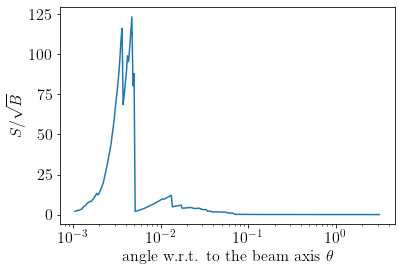

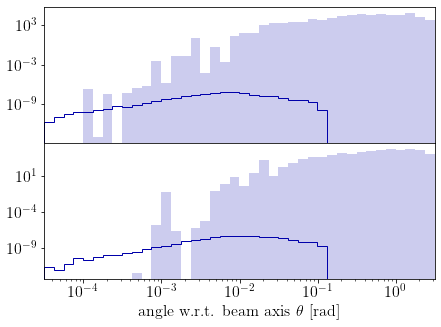

(M,th,Usq,ch) = (0.01 GeV,0,1e-07,nEE), n_sig=46127, n_bg=0


array([[1.00000000e-07, 5.80834963e-07]])

In [92]:
Usq_range = np.logspace(-10, -5, 20)
Usq_range = [1e-7]
my_bins   = np.concatenate((np.linspace(0,10,10, endpoint=False),
                            np.linspace(10,20,5,endpoint=False),
                            np.linspace(20,40,6,endpoint=True)) ) * u.GeV
np.array([ Usq_range,
#           chi2_spectrum(my_flux, 0.0, ['nEE','nMM','nEM','EPI','MPI','nPI0'], 'EMT', 200.*u.MeV, Usq_range,
           chi2_spectrum(my_flux, 0.0, ['nEE'], 'EMT', 10.*u.MeV, Usq_range,
                         lumi=my_lumi, sys_sig=0.1, sys_bg=0.1, use_cache=True,
                         bins=my_bins, include_NDGAr=False, include_NDLAr=True, th_cut='analytic', verbose=2).flatten() ]).T

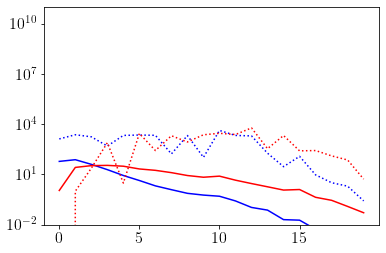

In [173]:
plt.plot(np.sum(sss,axis=0), c='b')
plt.plot(np.sum(bbb,axis=0), c='b', ls=':')
plt.plot(np.sum(sss,axis=1), c='r')
plt.plot(np.sum(bbb,axis=1), c='r', ls=':')
plt.ylim(bottom=0.01,top=1e11)
plt.yscale('log')

<ipython-input-174-b50b8cf72974>:1: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(sss))


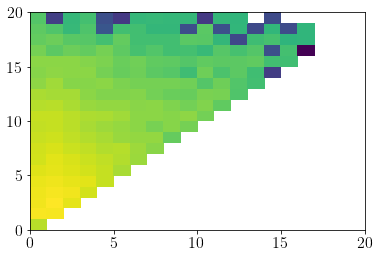

In [174]:
plt.pcolormesh(np.log10(sss))

<ipython-input-175-22353dfc64c0>:2: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(bbb))


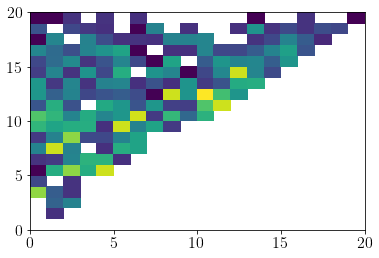

In [175]:
#plt.pcolormesh(np.log10(np.fmax(0.001,bbb)))
plt.pcolormesh(np.log10(bbb))

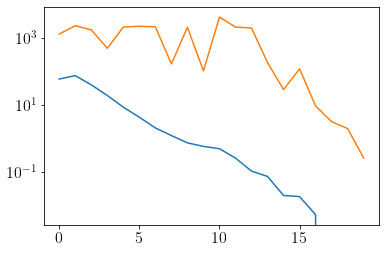

In [176]:
plt.plot(np.sum(sss,axis=0))
plt.plot(np.sum(bbb,axis=0))
plt.yscale('log')

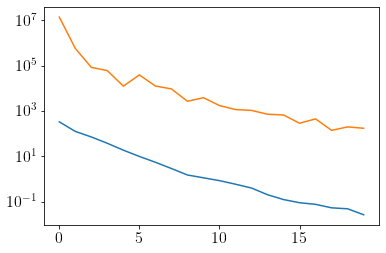

In [326]:
plt.plot(np.sum(sss,axis=1))
plt.plot(np.sum(bbb,axis=1))
plt.yscale('log')

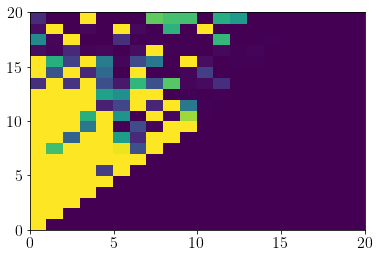

In [177]:
plt.pcolormesh(poisson_likelihood(bbb, sss+bbb), vmax=.01)

### Backgrounds

In [280]:
bg_spectrum_genie([11,11], 0., inclusive=True)

(array([[2.03384413e+09, 7.56652897e+07],
        [3.02887537e+09, 1.06181008e+08],
        [6.43345631e+08, 4.69119928e+07],
        ...,
        [2.09364302e+08, 3.16031405e+07],
        [7.10849831e+07, 1.48999831e+07],
        [3.59446319e+08, 7.11652904e+07]]),
 array([3.77252056e+00, 3.77252056e+00, 3.77252056e+00, ...,
        2.86126779e-03, 2.86126779e-03, 2.86126779e-03]))

In [30]:
bg_spectrum_oa(pdg_ids['nEE'], 0., inclusive=True)

[    2009     3417     4067 ... 19991027 19995122 19999011]


<ipython-input-29-8afb32e8d35b>:86: RuntimeWarning: invalid value encountered in true_divide
  * np.where(on_axis_weights>0., off_axis_weights/on_axis_weights, 0.)


(array([[2.35999078e+07, 1.48989195e+07],
        [8.27889017e+09, 1.23491225e+09],
        [1.02800055e+10, 2.84860581e+08],
        ...,
        [6.23799935e+07, 4.00231518e+07],
        [4.60792296e+07, 9.51812323e+06],
        [4.16113211e+08, 1.88585072e+08]]),
 array([54948.06249329, 54948.06249329, 54948.06249329, ...,
        98534.6710694 , 98534.6710694 , 98534.6710694 ]))

In [231]:
with uproot.open('sim/genie/events/dune-numode-nue-lowE.gtrac.root') as f:
    genie_data        = f['gRooTracker']
    this_genie_pdg    = genie_data['StdHepPdg'].array()
    this_genie_status = genie_data['StdHepStatus'].array()
    this_genie_Fd     = genie_data['StdHepFd'].array()
    this_genie_Fm     = genie_data['StdHepFm'].array()
    this_genie_Ld     = genie_data['StdHepLd'].array()
    this_genie_Lm     = genie_data['StdHepLm'].array()


In [232]:
this_genie_particle_counts = { this_id : np.array([ np.count_nonzero(ids_in_event==this_id)
                                                    for ids_in_event in np.abs(this_genie_pdg) ])
                                                                               for this_id in [11] }

In [233]:
ii_list = np.where((this_genie_particle_counts[11]>=2))[0]
                   #& (this_genie_particle_counts[13]>=-1))[0]

In [252]:
ii=ii_list[10]
print(np.array(list(enumerate(zip(this_genie_pdg[ii],this_genie_Fm[ii],this_genie_status[ii])))))

[[0 (12, -1, 0)]
 [1 (1000180400, -1, 0)]
 [2 (2112, 1, 11)]
 [3 (1000180390, 1, 2)]
 [4 (11, 0, 1)]
 [5 (2000000001, 2, 12)]
 [6 (2, 5, 12)]
 [7 (2103, 5, 12)]
 [8 (92, 6, 12)]
 [9 (221, 8, 12)]
 [10 (221, 8, 12)]
 [11 (2214, 8, 12)]
 [12 (111, 9, 14)]
 [13 (111, 9, 14)]
 [14 (111, 9, 14)]
 [15 (22, 10, 1)]
 [16 (11, 10, 1)]
 [17 (-11, 10, 1)]
 [18 (2212, 11, 14)]
 [19 (111, 11, 14)]
 [20 (111, 12, 1)]
 [21 (111, 13, 1)]
 [22 (2000000300, 14, 16)]
 [23 (2212, 22, 1)]
 [24 (2212, 22, 1)]
 [25 (2212, 22, 1)]
 [26 (2212, 22, 1)]
 [27 (2212, 22, 1)]
 [28 (2212, 22, 1)]
 [29 (2212, 18, 1)]
 [30 (-211, 19, 1)]
 [31 (2212, 19, 1)]
 [32 (2000000002, 3, 15)]]


In [235]:
len(ii_list)

710

### Miscellaneous debugging

In [42]:
my_M = 10*u.MeV
my_flux = HNL_flux()
my_flux.load_HNL_fluxes(my_M, Ue4=1., Um4=0., Ut4=0., small_files=True)

In [74]:
rnd.seed(77)
EE, tt, ww, idid = decay_spectrum(my_flux.p_array, my_flux.X_array, my_flux.weight_array, ['nEE'], 'E', 0., my_M, 1e-8)

In [316]:
w = HNL_flux_oa(my_flux.p_array, my_flux.X_array, my_flux.weight_array, ['nEE'], 'E', 0., my_M, Usq=np.logspace(6,7,2),
                include_NDGAr=False, include_NDLAr=True)

In [317]:
i_w = np.where(w['nEE'][:,0]>0)[0]
print(i_w[:20])
print(w['nEE'][i_w[:20]])

[ 563 2846 3258 3568 3678 3973 4110 4386 5459 5461 5767 5868 6216 6332
 6518 6854 6938 7822 7909 8395]
[[7.39391585e+07 6.59717700e+08]
 [1.10254476e+10 7.21870136e+10]
 [1.01877733e+08 9.45886864e+08]
 [4.24570377e+08 3.53981357e+09]
 [4.69023597e+08 4.17954441e+09]
 [7.92630277e+08 7.19810348e+09]
 [5.15286272e+07 4.76297102e+08]
 [1.99314867e+09 1.51798384e+10]
 [2.09339382e+10 1.97765162e+11]
 [4.46671506e+09 3.39126187e+10]
 [9.50384657e+09 9.19254542e+10]
 [9.10742565e+06 8.64106039e+07]
 [6.43560871e+08 5.70756128e+09]
 [2.85675115e+10 2.65541011e+11]
 [4.11691794e+08 3.51531303e+09]
 [9.13330373e+07 8.44760769e+08]
 [1.17543723e+10 5.65288781e+10]
 [3.11307549e+08 2.78746895e+09]
 [6.54735491e+10 6.01986028e+11]
 [4.21230406e+08 3.82755003e+09]]


In [318]:
my_flux.p_array[0,i_w[:20]]

array([8.23598927e+09, 1.89208047e+09, 1.20077382e+10, 3.70138475e+09,
       5.62545272e+09, 6.82322838e+09, 1.10170403e+10, 2.60177863e+09,
       1.60288563e+10, 2.90137159e+09, 2.12393406e+10, 1.40706359e+10,
       4.91715995e+09, 1.17247055e+10, 5.46738118e+09, 1.16032857e+10,
       1.25759043e+09, 6.36006078e+09, 8.36095304e+09, 5.97849269e+09])

In [319]:
XX=w['nEE'][i_w[:20]]
XX[:,0] / XX[:,1]

array([0.11207697, 0.1527345 , 0.10770604, 0.11994145, 0.11221883,
       0.11011654, 0.10818589, 0.13130236, 0.10585251, 0.13171248,
       0.10338645, 0.10539708, 0.11275584, 0.1075823 , 0.11711384,
       0.10811704, 0.20793571, 0.11168108, 0.10876257, 0.11005223])

In [320]:
XX

array([[7.39391585e+07, 6.59717700e+08],
       [1.10254476e+10, 7.21870136e+10],
       [1.01877733e+08, 9.45886864e+08],
       [4.24570377e+08, 3.53981357e+09],
       [4.69023597e+08, 4.17954441e+09],
       [7.92630277e+08, 7.19810348e+09],
       [5.15286272e+07, 4.76297102e+08],
       [1.99314867e+09, 1.51798384e+10],
       [2.09339382e+10, 1.97765162e+11],
       [4.46671506e+09, 3.39126187e+10],
       [9.50384657e+09, 9.19254542e+10],
       [9.10742565e+06, 8.64106039e+07],
       [6.43560871e+08, 5.70756128e+09],
       [2.85675115e+10, 2.65541011e+11],
       [4.11691794e+08, 3.51531303e+09],
       [9.13330373e+07, 8.44760769e+08],
       [1.17543723e+10, 5.65288781e+10],
       [3.11307549e+08, 2.78746895e+09],
       [6.54735491e+10, 6.01986028e+11],
       [4.21230406e+08, 3.82755003e+09]])

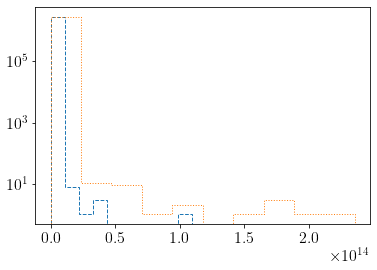

In [203]:
plt.hist(w['nEE'][:,0],histtype='step',ls='--')
plt.hist(w['nEE'][:,1],histtype='step',ls=':')
plt.yscale('log')
plt.show()

In [200]:
Usq_table = np.logspace(-5,15,41)
w = HNL_flux_oa(my_flux.p_array, my_flux.X_array, my_flux.weight_array, ['nEE'], 'E', 0., my_M, Usq=Usq_table,
                include_NDGAr=False, include_NDLAr=True)

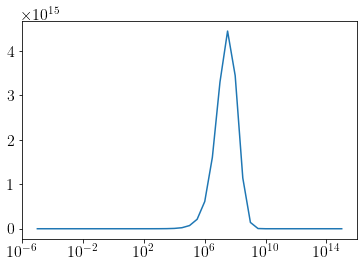

In [201]:
plt.plot(Usq_table, np.sum(w['nEE'],axis=0))
plt.xscale('log')

In [134]:
rnd.seed(39)
EE, ww, idid = decay_spectrum(my_flux.p_array, my_flux.X_array, my_flux.weight_array, ['EPI'], 'E', 0., my_M, 1e-8)

[5.13007649e+07 1.48699235e+08]
[[5.10999007e+05 1.39570610e+08]
 [5.10998993e+05 1.39570610e+08]
 [5.10998957e+05 1.39570610e+08]
 ...
 [5.10998999e+05 1.39570610e+08]
 [5.10999005e+05 1.39570610e+08]
 [5.10999001e+05 1.39570610e+08]]


In [305]:
my_M = 200.*u.MeV
my_flux = HNL_flux()
my_Usq = np.logspace(-10, -1, 30)
ttt=np.array([my_Usq, chi2_spectrum(my_flux, oa_angles[0], ['nPI0'], 'E', my_M, my_Usq, sys_sig=0.1, sys_bg=0.1, use_cache=False).flatten(),
                      chi2_spectrum(my_flux, oa_angles[4], ['nPI0'], 'E', my_M, my_Usq, sys_sig=0.1, sys_bg=0.1, use_cache=False).flatten()]).T

chi2_spectrum: loading HNL fluxes at M = 200 MeV


<ipython-input-305-461b9f69c2be>:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ttt=np.array([my_Usq, chi2_spectrum(my_flux, oa_angles[0], ['nPI0'], 'E', my_M, my_Usq, sys_sig=0.1, sys_bg=0.1, use_cache=False).flatten(),
<ipython-input-32-41ce447e358d>:85: RuntimeWarning: invalid value encountered in true_divide
  * np.where(on_axis_weights>0., off_axis_weights/on_axis_weights, 0.)


(1e-10, 1e-06)

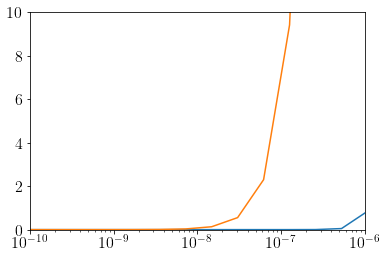

In [306]:
plt.plot(ttt[:,0],ttt[:,1])
plt.plot(ttt[:,0],ttt[:,2])
plt.xscale('log')
plt.ylim(0,10)
plt.xlim(1e-10,1e-6)

(1e-10, 1e-06)

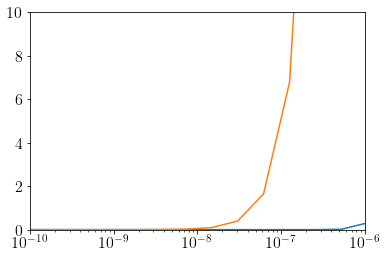

In [303]:
# inclusive

(1e-10, 1e-06)

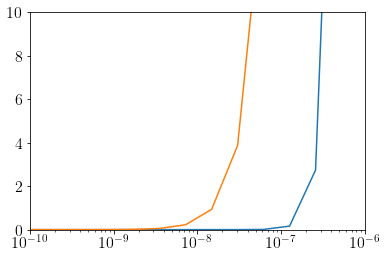

In [264]:
# with sys, old chi^2

(1e-10, 1e-06)

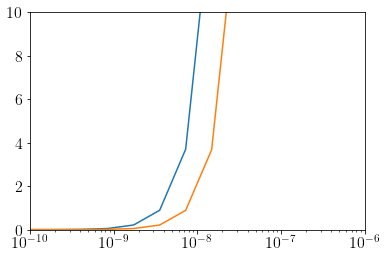

In [261]:
# with sys, new chi^2

(1e-10, 1e-06)

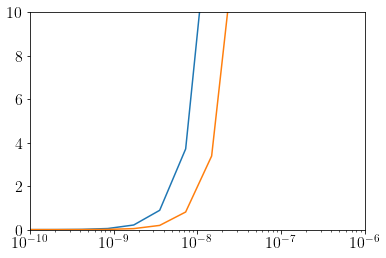

In [259]:
# no sys, new chi^2

(1e-10, 1e-06)

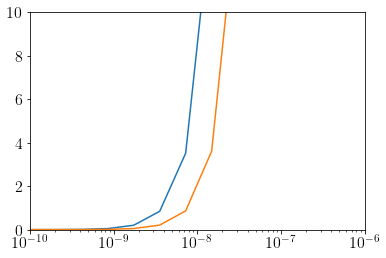

In [256]:
# no sys, old (wrong) chi^2

(1e-10, 1e-06)

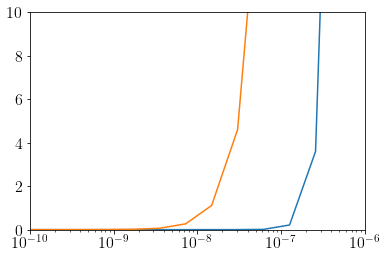

In [122]:
# with K->e, old statistics

In [505]:
my_M = 20*u.MeV
my_flux = HNL_flux()
my_flux.load_HNL_fluxes(my_M, Ue4=1., Um4=0., Ut4=0., small_files=True)

In [506]:
my_Usq = [1e-3]
my_Usq = np.logspace(-4,4,9)
np.sum(HNL_flux_oa(my_flux.p_array, my_flux.X_array, my_flux.weight_array,
            ['nEE'], 'E', 0., M=my_M, Usq=my_Usq)['nEE'], axis=0)

array([6.87769584e+06, 6.87770729e+07, 6.87770707e+08, 6.87770230e+09,
       6.87765320e+10, 6.87716231e+11, 6.87225815e+12, 6.82368503e+13,
       6.38020195e+14])

## Exclusion Limits

In [72]:
my_lumi          = 5.5e21  # = 5 years of running
theta_table      = oa_angles[:-1] # exclude \theta = 104.5 mrad as this would be ~60 m off-axis
Usq_table        = np.logspace(-10, -1, 30)
M_table          = hnl_mass_points[(hnl_mass_points >= 10*u.MeV)]
channel_table    = ['nPI0','EPI','MPI','nEE','nMM','nEM']
couplings        = ['E','M','T','EMT']
th_cut           = 'analytic'
# couplings=['E'] #FIXME
# theta_table=[oa_angles[-2]]#FIXME
# M_table=[M_table[14]]#FIXME
# channel_table=['nPI0']#FIXME
my_bins          = np.concatenate((np.linspace(0,10,10,endpoint=False),
                                   np.linspace(10,20,5,endpoint=False),
                                   np.linspace(20,40,6,endpoint=True)) ) * u.GeV
chi2_table_spect      = {}
chi2_table_total      = {}
chi2_table_nobg       = {}
chi2_table_total_nobg = {}
my_flux               = HNL_flux()
for c in couplings:
    print("Couplings: ", c)
    chi2_table_spect[c]      = np.zeros((len(theta_table), len(Usq_table), len(M_table), len(channel_table)))
    chi2_table_total[c]      = np.zeros((len(theta_table), len(Usq_table), len(M_table), len(channel_table)))
    chi2_table_nobg[c]       = np.zeros((len(theta_table), len(Usq_table), len(M_table), len(channel_table)))
    chi2_table_total_nobg[c] = np.zeros((len(theta_table), len(Usq_table), len(M_table), len(channel_table)))
    for j, M in enumerate(M_table):
        for i, th in enumerate(theta_table):
            print('M={:g} GeV theta={:g}'.format(M/u.GeV, th), end='\r')
            
            # analyze NDGAr and NDLAr data separately to benefit from the much better SNR in NDGAr
            for NDGAr_flag, NDLAr_flag in [[True,False],[False,True]]:
                chi2_table_spect[c][i,:,j,:] += chi2_spectrum(my_flux, th, channel_table, c, M, Usq_table, lumi=my_lumi,
                                                             sys_sig=0.1, sys_bg=0.1, use_cache=True, th_cut=th_cut,
                                                             bins=my_bins, include_NDGAr=NDGAr_flag, include_NDLAr=NDLAr_flag)
                chi2_table_nobg[c][i,:,j,:]  += chi2_spectrum(my_flux, th, channel_table, c, M, Usq_table, lumi=my_lumi,
                                                             sys_sig=0.1, sys_bg=0.1, include_bg=False, use_cache=True, th_cut=th_cut,
                                                             bins=my_bins, include_NDGAr=NDGAr_flag, include_NDLAr=NDLAr_flag)
                chi2_table_total[c][i,:,j,:] += chi2_spectrum(my_flux, th, channel_table, c, M, Usq_table, lumi=my_lumi,
                                                             sys_sig=0.1, sys_bg=0.1, use_cache=True, th_cut=th_cut,
                                                             bins=1, include_NDGAr=NDGAr_flag, include_NDLAr=NDLAr_flag)
                chi2_table_total_nobg[c][i,:,j,:] += chi2_spectrum(my_flux, th, channel_table, c, M, Usq_table, lumi=my_lumi,
                                                             sys_sig=0.1, sys_bg=0.1, include_bg=False, use_cache=True, th_cut=th_cut,
                                                             bins=1, include_NDGAr=NDGAr_flag, include_NDLAr=NDLAr_flag)

#             chi2_table_spect[c][i,:,j,:] = chi2_spectrum(my_flux, th, channel_table, c, M, Usq_table, lumi=my_lumi,
#                                                          sys_sig=0.1, sys_bg=0.1, use_cache=True, th_cut=th_cut,
#                                                          bins=my_bins, include_NDGAr=True, include_NDLAr=True)
#             chi2_table_nobg[c][i,:,j,:]  = chi2_spectrum(my_flux, th, channel_table, c, M, Usq_table, lumi=my_lumi,
#                                                          sys_sig=0.1, sys_bg=0.1, include_bg=False, use_cache=True, th_cut=th_cut,
#                                                          bins=my_bins, include_NDGAr=True, include_NDLAr=True)
#             chi2_table_total[c][i,:,j,:] = chi2_spectrum(my_flux, th, channel_table, c, M, Usq_table, lumi=my_lumi,
#                                                          sys_sig=0.1, sys_bg=0.1, use_cache=True, th_cut=th_cut,
#                                                          bins=1, include_NDGAr=True, include_NDLAr=True)
#             chi2_table_total_nobg[c][i,:,j,:] = chi2_spectrum(my_flux, th, channel_table, c, M, Usq_table, lumi=my_lumi,
#                                                          sys_sig=0.1, sys_bg=0.1, include_bg=False, use_cache=True, th_cut=th_cut,
#                                                          bins=1, include_NDGAr=True, include_NDLAr=True)
    print()

Couplings:  E
M=2 GeV theta=0.052262266
Couplings:  M
M=2 GeV theta=0.052262266
Couplings:  T
M=2 GeV theta=0.052262266
Couplings:  EMT
M=2 GeV theta=0.052262266


<ipython-input-73-8394cc718cf3>:24: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_spect[c][:,:,:,j],axis=0)+eps),
<ipython-input-73-8394cc718cf3>:26: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(chi2_table_spect[c][0,:,:,j]+eps),
<ipython-input-73-8394cc718cf3>:28: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_nobg[c][:,:,:,j],axis=0)+eps),


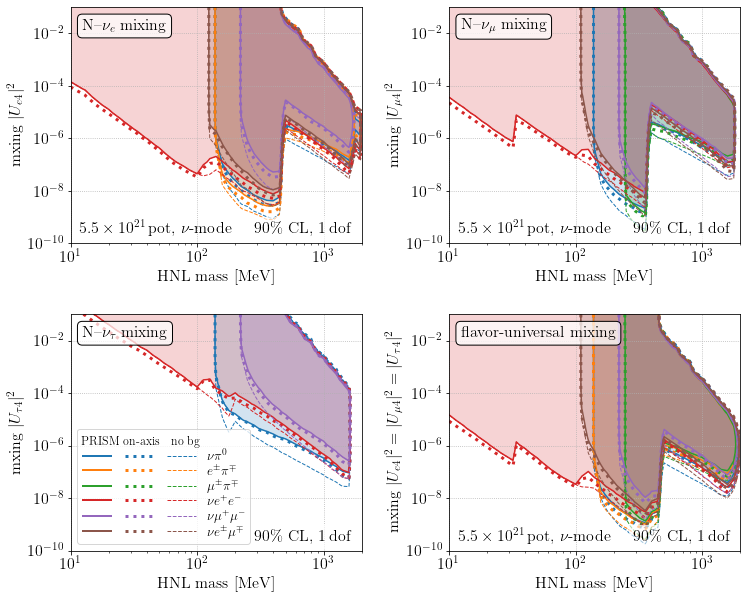

In [73]:
# Main exclusion plots
total_rates = False
my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(figsize=(12,10))
gs  = gridspec.GridSpec(nrows=2, ncols=2, wspace=0.3, hspace=0.3, figure=fig)
#ax  = [ [ fig.add_subplot(gs[i,j]) for j in range(2) ] for i in range(4) ]
ax  = [ fig.add_subplot(gs[i,j]) for i in range(2) for j in range(2) ]

for i, c in enumerate(['E','M','T','EMT']):
    for j, ch in enumerate(channel_table):
        if total_rates:
            ax[i].contourf(M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_total[c][:,:,:,j],axis=0)+eps),
                             levels=[np.log(4),np.inf], colors=[my_colors[j]+'33'])
            ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_total[c][:,:,:,j],axis=0)+eps),
                             levels=[np.log(4)], colors=[my_colors[j]])
            ax[i].contour (M_table/u.MeV, Usq_table, np.log(chi2_table_total[c][0,:,:,j]+eps),
                             levels=[np.log(4)], linestyles=[':'], linewidths=[3], colors=[my_colors[j]])
            ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_total_nobg[c][:,:,:,j],axis=0)+eps),
                             levels=[np.log(4)], linestyles=['--'], linewidths=[1], colors=[my_colors[j]])
        else:
            ax[i].contourf(M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_spect[c][:,:,:,j],axis=0)+eps),
                             levels=[np.log(4),np.inf], colors=[my_colors[j]+'33'])
            ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_spect[c][:,:,:,j],axis=0)+eps),
                             levels=[np.log(4)], colors=[my_colors[j]])
            ax[i].contour (M_table/u.MeV, Usq_table, np.log(chi2_table_spect[c][0,:,:,j]+eps),
                             levels=[np.log(4)], linestyles=[':'], linewidths=[3], colors=[my_colors[j]])
            ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_nobg[c][:,:,:,j],axis=0)+eps),
                             levels=[np.log(4)], linestyles=['--'], linewidths=[1], colors=[my_colors[j]])
    ax[i].set_xlabel(r'HNL mass [MeV]')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim(10,2000)
    ax[i].grid(ls=':', zorder=0)
    if i != 2:
        ax[i].annotate(r'$5.5 \times 10^{21}$\,pot, $\nu$-mode', (0.03,0.03), xycoords='axes fraction', ha='left', va='bottom')
    ax[i].annotate(r'90\% CL, 1\,dof', (0.96,0.03), xycoords='axes fraction', ha='right', va='bottom', backgroundcolor='#ffffff99')
    if total_rates:
        ax[i].annotate(r'Cut \& Count', (0.96,0.95), xycoords='axes fraction', ha='right', va='top',
                       bbox=dict(boxstyle="round", fc='#ffffffbb'))
    
ax[0].set_ylabel(r'mxing $|U_{e4}|^2$')
ax[1].set_ylabel(r'mxing $|U_{\mu 4}|^2$')
ax[2].set_ylabel(r'mxing $|U_{\tau 4}|^2$')
ax[3].set_ylabel(r'mxing $|U_{e4}|^2 = |U_{\mu 4}|^2 = |U_{\tau 4}|^2$')

ax[0].annotate(r'N--$\nu_e$ mixing',       (0.04,0.95), xycoords='axes fraction', ha='left', va='top',
               bbox=dict(boxstyle="round", fc='#ffffffbb'))
ax[1].annotate(r'N--$\nu_\mu$ mixing',     (0.04,0.95), xycoords='axes fraction', ha='left', va='top',
               bbox=dict(boxstyle="round", fc='#ffffffbb'))
ax[2].annotate(r'N--$\nu_\tau$ mixing',    (0.04,0.95), xycoords='axes fraction', ha='left', va='top',
               bbox=dict(boxstyle="round", fc='#ffffffbb'))
ax[3].annotate(r'flavor-universal mixing', (0.04,0.95), xycoords='axes fraction', ha='left', va='top',
               bbox=dict(boxstyle="round", fc='#ffffffbb'))

my_legend_lines = [ (lines.Line2D([0], [0], color=my_colors[j], lw=2),
                     lines.Line2D([0], [0], color=my_colors[j], lw=3, ls=':'),
                     lines.Line2D([0], [0], color=my_colors[j], lw=1, ls='--')) for j in range(len(channel_table)) ]
leg = ax[2].legend(my_legend_lines, [decay_labels[c] for c in channel_table],
                loc='lower left', handlelength=8.5, labelspacing=0.2, fontsize='small',
                handler_map={tuple: mpl.legend_handler.HandlerTuple(ndivide=None,pad=1)},
                title=r'\large PRISM\ on-axis\ \ \ no bg')
leg.get_title().set_position((-24,0))
if total_rates:
    plt.savefig('hnl-limits-total-rates.pdf')
else:
    plt.savefig('hnl-limits.pdf')
plt.show()

<ipython-input-17-8394cc718cf3>:24: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_spect[c][:,:,:,j],axis=0)+eps),
<ipython-input-17-8394cc718cf3>:26: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(chi2_table_spect[c][0,:,:,j]+eps),
<ipython-input-17-8394cc718cf3>:28: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_nobg[c][:,:,:,j],axis=0)+eps),


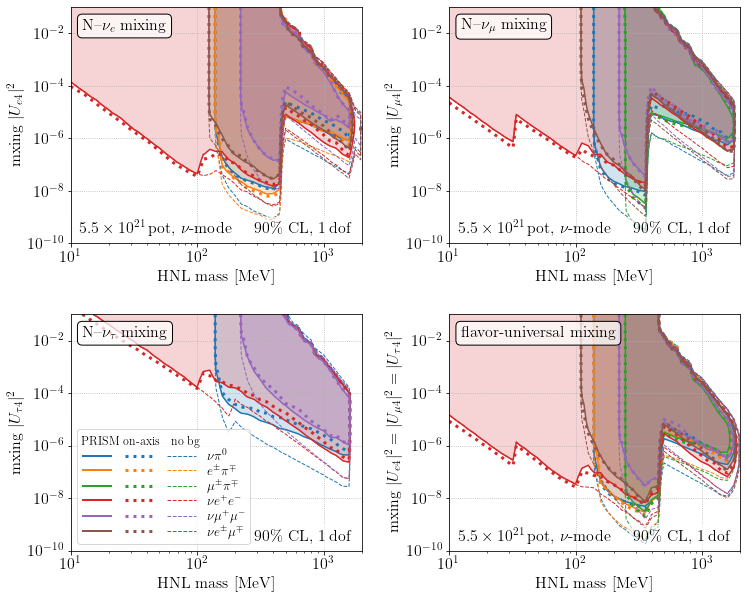

In [17]:
# combining NDGAr and NDLAr data before analysis (corresponds to arXiv-v1)

<ipython-input-13-8394cc718cf3>:24: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_spect[c][:,:,:,j],axis=0)+eps),
<ipython-input-13-8394cc718cf3>:26: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(chi2_table_spect[c][0,:,:,j]+eps),
<ipython-input-13-8394cc718cf3>:28: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_nobg[c][:,:,:,j],axis=0)+eps),


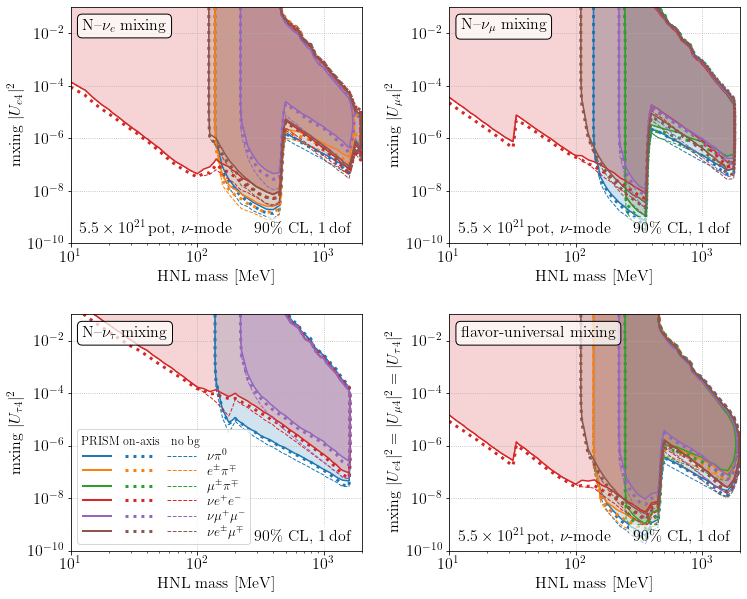

In [13]:
# no smearing, no checking for "problematic" entries

<ipython-input-14-8394cc718cf3>:24: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_spect[c][:,:,:,j],axis=0)+eps),
<ipython-input-14-8394cc718cf3>:26: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(chi2_table_spect[c][0,:,:,j]+eps),
<ipython-input-14-8394cc718cf3>:28: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_nobg[c][:,:,:,j],axis=0)+eps),


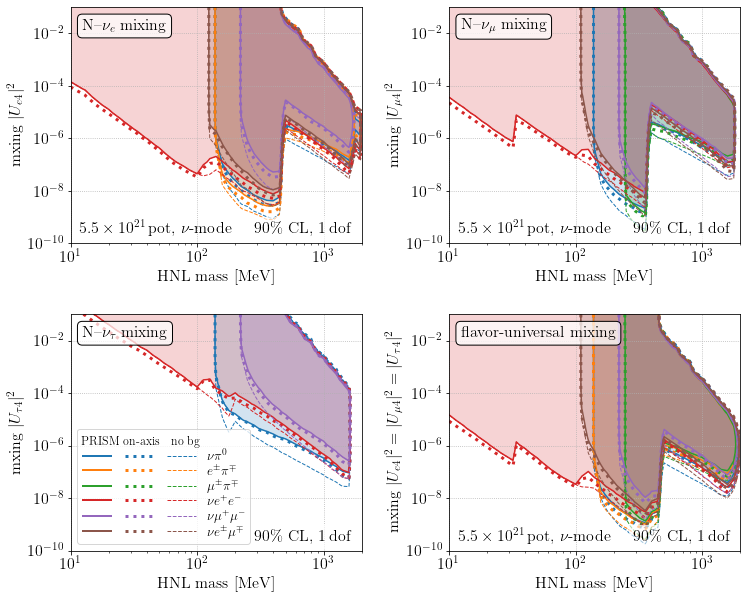

In [14]:
# no smearing

<ipython-input-13-819c1897211d>:24: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_spect[c][:,:,:,j],axis=0)+eps),
<ipython-input-13-819c1897211d>:26: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(chi2_table_spect[c][0,:,:,j]+eps),
<ipython-input-13-819c1897211d>:28: UserWarning: No contour levels were found within the data range.
  ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(chi2_table_nobg[c][:,:,:,j],axis=0)+eps),


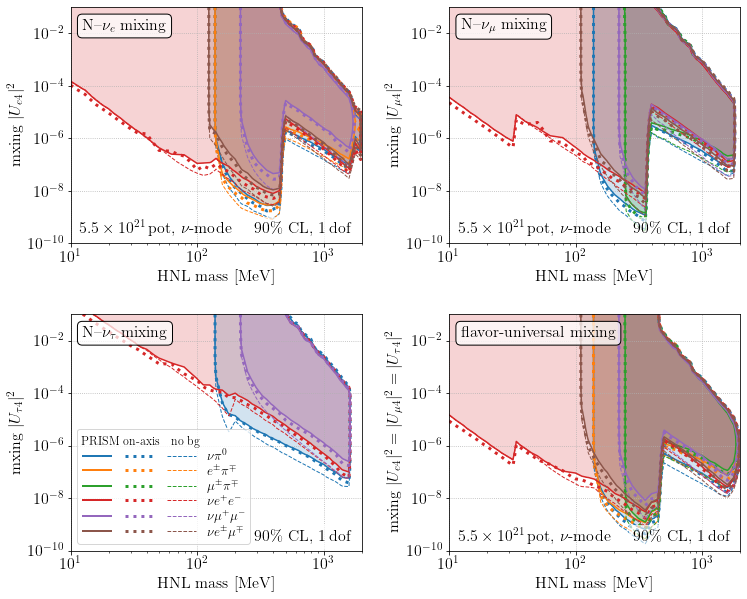

In [13]:
# with smearing

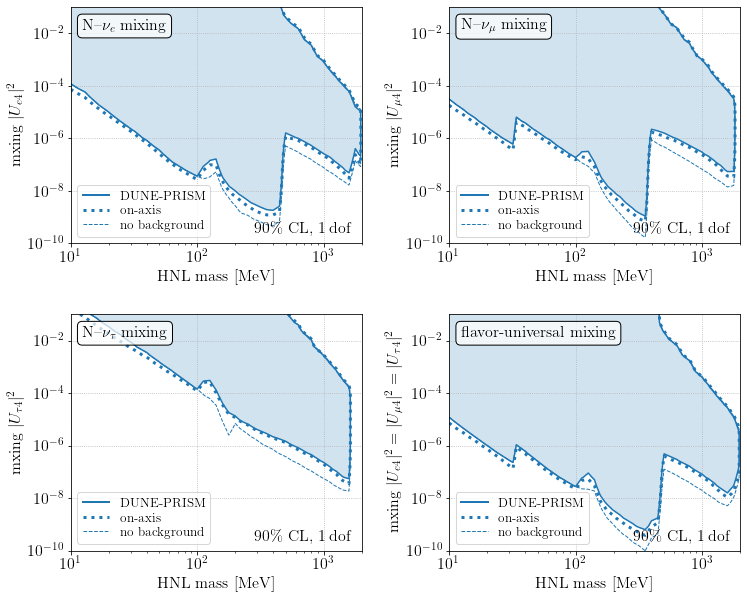

In [74]:
# Combining channels for comaprison with other experiments
# (remember: the dimensions of chi2_table_spect are (oa_angle, Usq, mass, channel))
my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(figsize=(12,10))
gs  = gridspec.GridSpec(nrows=2, ncols=2, wspace=0.3, hspace=0.3, figure=fig)
ax  = [ fig.add_subplot(gs[i,j]) for i in range(2) for j in range(2) ]

my_legend_lines = [ lines.Line2D([0], [0], color=my_colors[0], lw=2),
                    lines.Line2D([0], [0], color=my_colors[0], lw=3, ls=':'),
                    lines.Line2D([0], [0], color=my_colors[0], lw=1, ls='--') ]
my_legend_handles = [ r'DUNE-PRISM', r'on-axis', r'no background']
for i, c in enumerate(['E','M','T','EMT']):
    ax[i].contourf(M_table/u.MeV, Usq_table, np.log(np.mean(np.sum(chi2_table_spect[c],axis=-1),axis=0)+eps),
                     levels=[np.log(2.7),np.inf], colors=[my_colors[0]+'33'])
    ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(np.sum(chi2_table_spect[c],axis=-1),axis=0)+eps),
                     levels=[np.log(2.7)], colors=[my_colors[0]])
    ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.sum(chi2_table_spect[c][0],axis=-1)+eps),
                     levels=[np.log(2.7)], linestyles=[':'], linewidths=[3], colors=[my_colors[0]])
    ax[i].contour (M_table/u.MeV, Usq_table, np.log(np.mean(np.sum(chi2_table_nobg[c],axis=-1),axis=0)+eps),
                     levels=[np.log(2.7)], linestyles=['--'], linewidths=[1], colors=[my_colors[0]])
    ax[i].set_xlabel(r'HNL mass [MeV]')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim(10,2000)
    ax[i].grid(ls=':', zorder=0)
    ax[i].legend(my_legend_lines, my_legend_handles, loc='lower left', labelspacing=0.2, fontsize='small')
    ax[i].annotate(r'90\% CL, 1\,dof', (0.96,0.03), xycoords='axes fraction', ha='right', va='bottom')
    
    # save data files for Gaia
    my_header = 'chi^2 table for DUNE-PRISM sensitivity to Heavy Neutral Leptons\n' \
              + '\n' \
              + 'M_HNL [MeV]   |U|^2      chi^2'
    my_grid = np.meshgrid(M_table/u.MeV, Usq_table)
    np.savetxt('prism-' + c + '.txt', fmt=' %9.4f', header=my_header,
               X=np.array([ my_grid[0].flatten(), my_grid[1].flatten(), np.mean(np.sum(chi2_table_spect[c],axis=-1),axis=0).flatten() ]).T)
    np.savetxt('onaxis-'+ c + '.txt', fmt=' %9.4f', header=my_header,
               X=np.array([ my_grid[0].flatten(), my_grid[1].flatten(), np.sum(chi2_table_spect[c][0],axis=-1).flatten() ]).T)
    np.savetxt('nobg-'  + c + '.txt', fmt=' %9.4f', header=my_header,
               X=np.array([ my_grid[0].flatten(), my_grid[1].flatten(), np.mean(np.sum(chi2_table_nobg[c],axis=-1),axis=0).flatten() ]).T)
    
ax[0].set_ylabel(r'mxing $|U_{e4}|^2$')
ax[1].set_ylabel(r'mxing $|U_{\mu 4}|^2$')
ax[2].set_ylabel(r'mxing $|U_{\tau 4}|^2$')
ax[3].set_ylabel(r'mxing $|U_{e4}|^2 = |U_{\mu 4}|^2 = |U_{\tau 4}|^2$')

ax[0].annotate(r'N--$\nu_e$ mixing',       (0.04,0.95), xycoords='axes fraction', ha='left', va='top',
               bbox=dict(boxstyle="round", fc='#ffffffbb'))
ax[1].annotate(r'N--$\nu_\mu$ mixing',     (0.04,0.95), xycoords='axes fraction', ha='left', va='top',
               bbox=dict(boxstyle="round", fc='#ffffffbb'))
ax[2].annotate(r'N--$\nu_\tau$ mixing',    (0.04,0.95), xycoords='axes fraction', ha='left', va='top',
               bbox=dict(boxstyle="round", fc='#ffffffbb'))
ax[3].annotate(r'flavor-universal mixing', (0.04,0.95), xycoords='axes fraction', ha='left', va='top',
               bbox=dict(boxstyle="round", fc='#ffffffbb'))
plt.savefig('hnl-limits-combined.pdf')
plt.show()

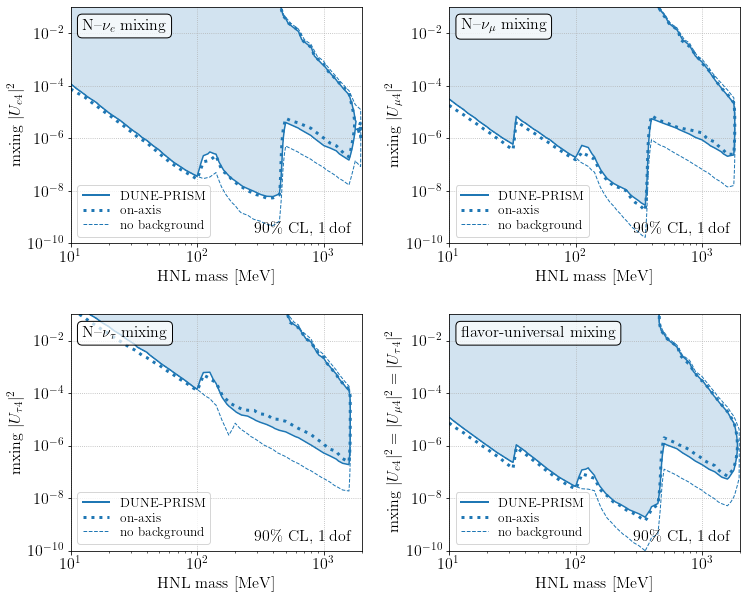

In [18]:
# combining NDGAr and NDLAr data before analysis

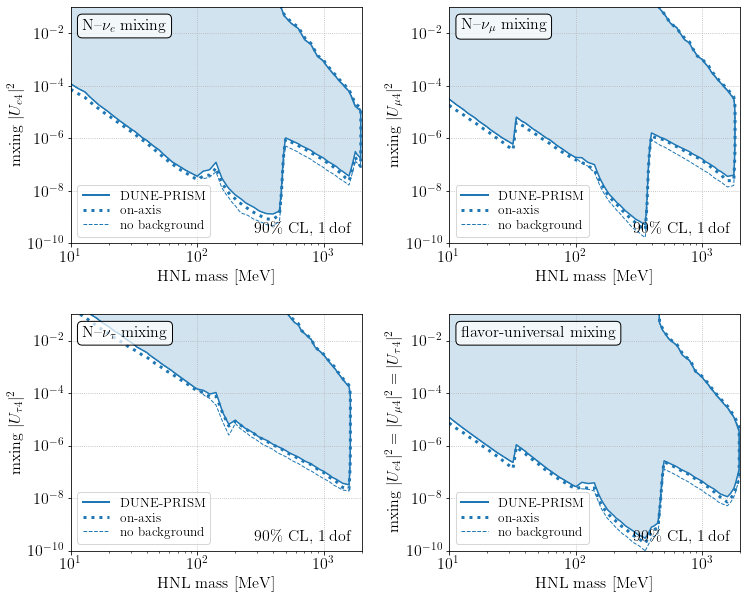

In [14]:
# no smearing, no checking for "problematic" bins

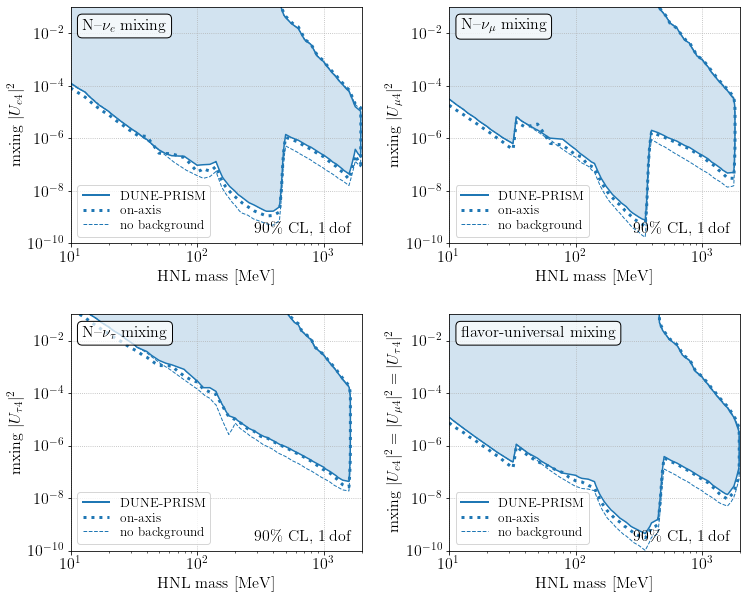

In [14]:
# with smearing

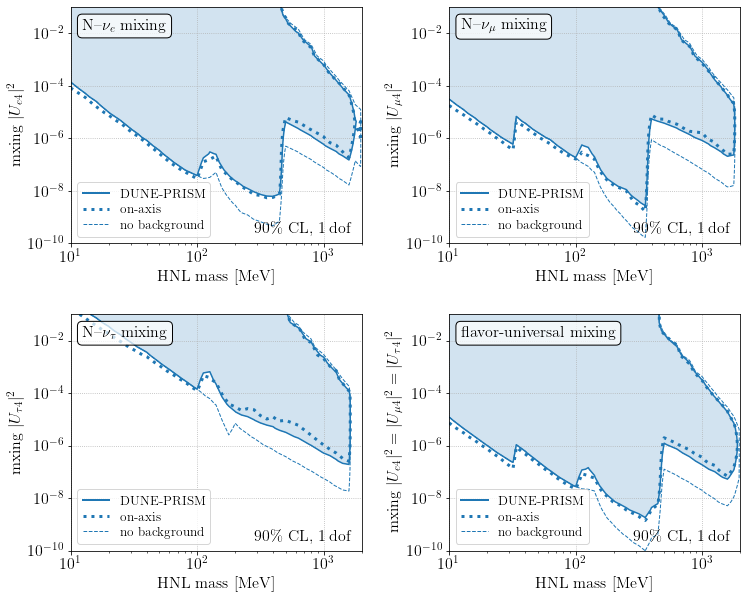

In [149]:
# original / paper arXiv-v1

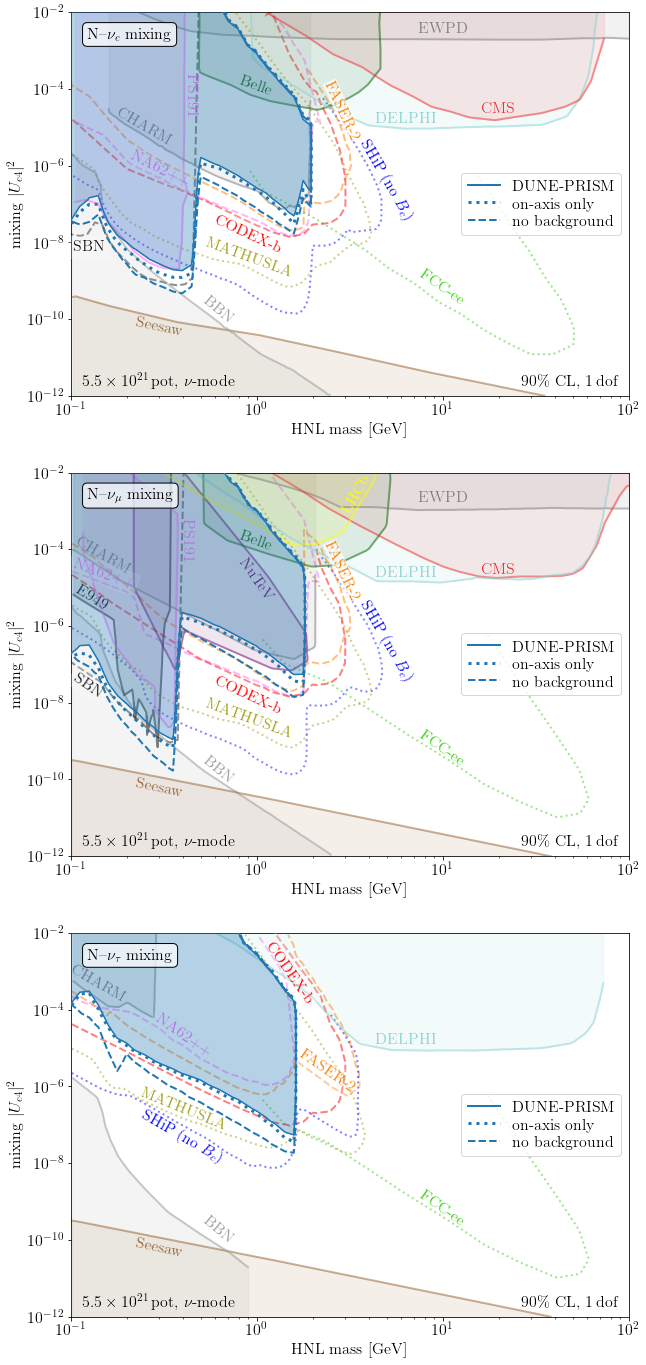

In [94]:
limit_exps  = ['EWPD','CMS','PS191','DELPHI','CHARM','Belle','E949','NuTeV','LHCb']  # experiments that have actual limits
future_exps = ['NA62','CODEX-b','FASER2','SBN']                     # experiments for which we only have sensitivities
far_future_exps = ['SHiP no Bc','MATHUSLA','FCCee']                 # experiments for which we only have sensitivities
theory_constraints = ['BBN','Seesaw']                               # theoretical limits

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']       # for DUNE curves
exps_for_plot = ['EWPD','CMS','SHiP noBc','FCCee','BBN','Seesaw']   # which experiments to include in plot

exp_colors = {
    'CMS':      np.array([238,52,57]) / 255,
    'DELPHI':   np.array([140,211,211]) / 255,
    'EWPD':     np.array([.5,.5,.5]),
    'BBN':      np.array([.6,.6,.6]),
    'Seesaw':   np.array([151,100,48]) / 255,
    'FCCee':    np.array([60,206,22]) / 255,
    'SHiP':     np.array([0,0,1]),
    'MATHUSLA': np.array([160,160,26]) / 255,
    'NuTeV':    np.array([112,18,112]) / 255,
    'Belle':    np.array([11,104,12]) / 255,
    'PS191':    np.array([255,109,255]) / 255,
    'CHARM':    np.array([.5,.5,.5]),
    'LHCb':     np.array([1,1,0]),
    'E949':     np.array([.1,.1,.1]),
    'FASER2':   np.array([1,.5,0]),
    'CODEX-b':  np.array([1,0,0]),
    'NA62':     np.array([255,109,255]) / 255,
    'SBN':      np.array([.1,.1,.1])
}

fig = plt.figure(figsize=(10,24))
gs  = gridspec.GridSpec(nrows=3, ncols=1, wspace=0., hspace=0.2, figure=fig)
ax  = [ fig.add_subplot(gs[i]) for i in range(3) ]

my_legend_lines = [ lines.Line2D([0], [0], color=my_colors[0], lw=2),
                    lines.Line2D([0], [0], color=my_colors[0], lw=3, ls=':'),
                    lines.Line2D([0], [0], color=my_colors[0], lw=2, ls='--') ]
my_legend_handles = [ r'DUNE-PRISM', r'on-axis only', r'no background']

couplings = ['E','M','T']
for i, c in enumerate(couplings):
    # read digitized PBC limits
    with open(base_dir + '/data/pbc-limits/hnl-limits-' + c.lower() + '.json') as f:
        limits = json.load(f)
        
    # read digitized SBN limits
    if c != 'T':
        sbn_limits        = []
        sbn_limits_interp = []
        for s in ['A','B','C']:  # read limits in individual channels
            with open(base_dir + '/data/sbn-limits/sbn-limits-U' + c.lower() + '4-' + s + '.json') as f:
                sbn_limits = sbn_limits + json.load(f)['datasetColl']
        for this_sbn_limit in sbn_limits:     # interpolate limits in individual channels
            tmp_limit = np.array([ x['value'] for x in this_sbn_limit['data'] ])
            sbn_limits_interp.append( interp.interp1d(tmp_limit[:,0], tmp_limit[:,1], bounds_error=False, fill_value=1. ) )
        sbn_M_table          = np.logspace(-2,2,100)
        sbn_best_limit_table = np.amin(np.array([ x(sbn_M_table) for x in sbn_limits_interp ]), axis=0)        
        limits['datasetColl'].append({
            'name': 'SBN',
            'data': [ {'value': [M,U]} for M, U in zip(sbn_M_table, sbn_best_limit_table) ]
        })

    for d in limits['datasetColl']:
        # extract data from WebPlotDigitizer .json file
        plot_data = np.array([ p['value'] for p in d['data'] ])
        n_data    = len(plot_data)
    
        # pre-sort data according x values
        i_list    = np.argsort(plot_data[:,0])
        plot_data = list(plot_data[i_list])
    
        # order points by nearest neighbors, starting with the leftmost point
        # give more weight to the distance in x-direction because most curves are ordered in x
        if d['name'] in ['E949','SBN']:
            plot_data_nn = np.array(plot_data).T
        else:
            plot_data_nn = [ plot_data.pop(0)]
            for j in range(n_data-1):
                i_nn = np.argmin(np.sqrt(np.sum([10,1] * (np.log(plot_data_nn[j]) - np.log(plot_data))**2, axis=1))) # find nearest neighbor
                plot_data_nn.append(plot_data.pop(i_nn))       
            plot_data_nn = np.array(plot_data_nn).T

        # plot contours
        if d['name'] in exp_colors.keys():
            this_color = exp_colors[d['name']]
        else:
            this_color = np.array(d['autoDetectionData']['fgColor'])/255.
        if d['name'] in limit_exps:
            ax[i].plot(plot_data_nn[0], plot_data_nn[1], c=this_color, alpha=0.5, lw=2, zorder=2)
            ax[i].fill_between(plot_data_nn[0], plot_data_nn[1], 0.1,   color=this_color, alpha=0.1, zorder=2)
        elif d['name'] in theory_constraints:
            if (not d['name'] in ['Seesaw']) or i != 2:  # take \nu_\mu limits also for \nu_\tau where the ones for \nu_\tau are cut off at |U|^2=2e11
                ax[i].plot(plot_data_nn[0], plot_data_nn[1], c=this_color, alpha=0.5, lw=2, zorder=2)
                ax[i].fill_between(plot_data_nn[0], plot_data_nn[1], 1e-20, color=this_color, alpha=0.1, zorder=2)
            if d['name'] in ['Seesaw'] and i == 1:
                ax[2].plot(plot_data_nn[0], plot_data_nn[1], c=this_color, alpha=0.5, lw=2, zorder=2)
                ax[2].fill_between(plot_data_nn[0], plot_data_nn[1], 1e-20, color=this_color, alpha=0.1, zorder=2)
        elif d['name'] in future_exps:
            ax[i].plot(plot_data_nn[0], plot_data_nn[1], c=this_color, alpha=0.5, lw=2, ls='--', zorder=1)
        else:
            if (not d['name'] in ['FCCee']) or i != 2:  # take \nu_\mu limits also for \nu_\tau where the ones for \nu_\tau are cut off at |U|^2=2e11
                ax[i].plot(plot_data_nn[0], plot_data_nn[1], c=this_color, alpha=0.5, lw=2, ls=':', zorder=1)
            if d['name'] in ['FCCee'] and i == 1:
                ax[2].plot(plot_data_nn[0], plot_data_nn[1], c=this_color, alpha=0.5, lw=2, ls=':', zorder=1)
    
    # add DUNE contours
    dune_color = my_colors[0] #'#ff3300'
    ax[i].contourf(M_table/u.GeV, Usq_table, np.log(np.mean(np.sum(chi2_table_spect[c],axis=-1),axis=0)+eps),
                   levels=[np.log(2.7),np.inf], colors=[dune_color+'55'], zorder=3.5)
    ax[i].contour (M_table/u.GeV, Usq_table, np.log(np.mean(np.sum(chi2_table_spect[c],axis=-1),axis=0)+eps),
                   levels=[np.log(2.7)], colors=[dune_color], zorder=3.5)
    ax[i].contour (M_table/u.GeV, Usq_table, np.log(np.sum(chi2_table_spect[c][0],axis=-1)+eps),
                   levels=[np.log(2.7)], linestyles=[':'], linewidths=[3], colors=[dune_color], zorder=3.5)
    ax[i].contour (M_table/u.GeV, Usq_table, np.log(np.mean(np.sum(chi2_table_nobg[c],axis=-1),axis=0)+eps),
                   levels=[np.log(2.7)], linestyles=['--'], linewidths=[2], colors=[dune_color], zorder=3.5)
    
    # common annotations
    ax[i].annotate(r'BBN',    (0.5,7e-11),  ha='left',   va='bottom', rotation=-40, color=exp_colors['BBN'])
    ax[i].annotate(r'Seesaw', (0.3,1.3e-10),ha='center', va='top',    rotation=-12, color=exp_colors['Seesaw'])
    ax[i].annotate(r'FCC-ee', (10,2e-10),   ha='center', va='bottom', rotation=-35, color=exp_colors['FCCee'])

    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim(0.1,100)
    ax[i].set_ylim(1e-12,1e-2)
    ax[i].set_xlabel('HNL mass [GeV]')
    ax[i].set_ylabel('mixing $|U_{e4}|^2$')
    
    ax[i].legend(my_legend_lines, my_legend_handles, loc='center right', labelspacing=0.2)
    ax[i].annotate(r'90\% CL, 1\,dof', (0.98,0.02), xycoords='axes fraction', ha='right', va='bottom')
    ax[i].annotate(r'$5.5 \times 10^{21}$\,pot, $\nu$-mode', (0.02,0.02), xycoords='axes fraction', ha='left', va='bottom')

# curve labels    
ax[0].annotate(r'CMS',    (20,2e-5), ha='center', va='bottom', rotation=0, color=exp_colors['CMS'])
ax[1].annotate(r'CMS',    (20,2e-5), ha='center', va='bottom', rotation=0, color=exp_colors['CMS'])

ax[0].annotate(r'DELPHI', (6.3,1.1e-5), ha='center', va='bottom', rotation=0, color=exp_colors['DELPHI'])
ax[1].annotate(r'DELPHI', (6.3,1.6e-5), ha='center', va='bottom', rotation=0, color=exp_colors['DELPHI'])
ax[2].annotate(r'DELPHI', (6.3,1.1e-5), ha='center', va='bottom', rotation=0, color=exp_colors['DELPHI'])

ax[0].annotate(r'EWPD', (10,2.5e-3), ha='center', va='bottom', rotation=0, color=exp_colors['EWPD'])
ax[1].annotate(r'EWPD', (10,1.5e-3), ha='center', va='bottom', rotation=0, color=exp_colors['EWPD'])

ax[0].annotate(r'Belle', (1,6e-5), ha='center', va='bottom', rotation=-20, color=exp_colors['Belle'])
ax[1].annotate(r'Belle', (1,8e-5), ha='center', va='bottom', rotation=-20, color=exp_colors['Belle'])

ax[0].annotate(r'SHiP (no $B_c$)', (5,3e-8),  ha='center', va='bottom', rotation=-60, color=exp_colors['SHiP'])
ax[1].annotate(r'SHiP (no $B_c$)', (5,3e-8),  ha='center', va='bottom', rotation=-60, color=exp_colors['SHiP'])
ax[2].annotate(r'SHiP (no $B_c$)', (.4,3e-7), ha='center', va='top', rotation=-30, color=exp_colors['SHiP'])

ax[0].annotate(r'MATHUSLA', (.9,1.1e-9), ha='center', va='bottom', rotation=-20, color=exp_colors['MATHUSLA'])
ax[1].annotate(r'MATHUSLA', (.9,1.1e-9), ha='center', va='bottom', rotation=-20, color=exp_colors['MATHUSLA'])
ax[2].annotate(r'MATHUSLA', (.4,6.5e-8), ha='center', va='bottom', rotation=-22, color=exp_colors['MATHUSLA'])

ax[0].annotate(r'PS191', (.45,2e-5), ha='center', va='bottom', rotation=-90, color=exp_colors['PS191'])
ax[1].annotate(r'PS191', (.43,5e-5), ha='center', va='bottom', rotation=-90, color=exp_colors['PS191'])

ax[1].annotate(r'NuTeV', (1,7e-5),  ha='center', va='top', rotation=-55, color=exp_colors['NuTeV'])
ax[1].annotate(r'LHCb', (3.4,1e-2), ha='center', va='top', rotation=60, color=exp_colors['LHCb'])
ax[1].annotate(r'E949', (.13,2.3e-6), ha='center', va='bottom', rotation=-32, color=exp_colors['E949'])

ax[0].annotate(r'CHARM', (0.25,3e-6),  ha='center', va='bottom', rotation=-30, color=exp_colors['CHARM'])
ax[1].annotate(r'CHARM', (0.15,2e-5),  ha='center', va='bottom', rotation=-30, color=exp_colors['CHARM'])
ax[2].annotate(r'CHARM', (0.14,1.4e-4),ha='center', va='bottom', rotation=-30, color=exp_colors['CHARM'])

ax[0].annotate(r'FASER-2', (2.9,4e-6), ha='center', va='bottom', rotation=-65, color=exp_colors['FASER2'], bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
ax[1].annotate(r'FASER-2', (2.9,4e-6), ha='center', va='bottom', rotation=-65, color=exp_colors['FASER2'], bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
ax[2].annotate(r'FASER-2', (2.4,6e-7), ha='center', va='bottom', rotation=-35, color=exp_colors['FASER2'], backgroundcolor='#ffffff33')

ax[0].annotate(r'CODEX-b', (0.9,4.5e-9), ha='center', va='bottom', rotation=-25, color=exp_colors['CODEX-b'], backgroundcolor='#ffffff33')
ax[1].annotate(r'CODEX-b', (0.9,4.5e-9), ha='center', va='bottom', rotation=-25, color=exp_colors['CODEX-b'], backgroundcolor='#ffffff33')
ax[2].annotate(r'CODEX-b', (1.5,1.3e-4), ha='center', va='bottom', rotation=-55, color=exp_colors['CODEX-b'], backgroundcolor='#ffffff33')

ax[0].annotate(r'NA62++', (0.3,2.3e-7), ha='center', va='bottom', rotation=-27, color=exp_colors['NA62'], backgroundcolor='#ffffff33')
ax[1].annotate(r'NA62++', (0.15,8e-6),ha='center', va='bottom', rotation=-20, color=exp_colors['NA62'], backgroundcolor='#ffffff33')
ax[2].annotate(r'NA62++', (0.4,5e-6), ha='center', va='bottom', rotation=-35, color=exp_colors['NA62'], backgroundcolor='#ffffff33')

ax[0].annotate(r'SBN', (0.125,5e-9), ha='center', va='bottom', rotation=0, color=exp_colors['SBN'], backgroundcolor='#ffffff33')
ax[1].annotate(r'SBN', (0.125,1.2e-8), ha='center', va='bottom', rotation=-35, color=exp_colors['SBN'], backgroundcolor='#ffffff33')

# plot titles
ax[0].annotate(r'N--$\nu_e$ mixing',       (0.03,0.96), xycoords='axes fraction', ha='left', va='top',
               bbox=dict(boxstyle="round", fc='#ffffffbb'), zorder=5)
ax[1].annotate(r'N--$\nu_\mu$ mixing',     (0.03,0.96), xycoords='axes fraction', ha='left', va='top',
               bbox=dict(boxstyle="round", fc='#ffffffbb'), zorder=5)
ax[2].annotate(r'N--$\nu_\tau$ mixing',    (0.03,0.96), xycoords='axes fraction', ha='left', va='top',
               bbox=dict(boxstyle="round", fc='#ffffffbb'), zorder=5)

plt.savefig('hnl-limit-comparison.pdf')
plt.show()

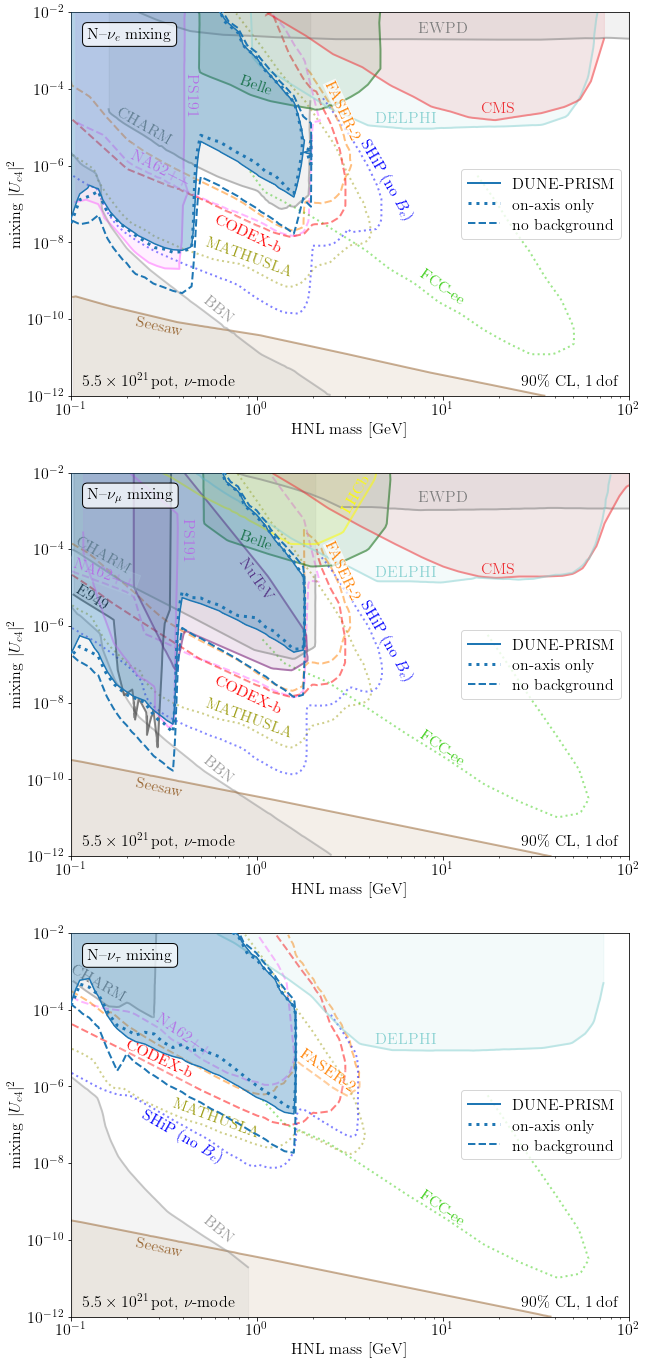

In [150]:
# original / paper

## Event Spectra

In [15]:
M_array            = np.array([10,   200,  1000]) * u.MeV
Usq_array          = np.array([1e-3, 1e-7, 1e-5])
my_decay_channels  = ['nEE','nMM','nEM','EPI','MPI','nPI0']
my_couplings       = 'EMT'

my_flux            = {}
E_sig_array        = {}
th_sig_array       = {}
weight_sig_array   = {}
pdg_ids            = {}
for j, (M, Usq) in enumerate(zip(M_array, Usq_array)):
    # load HNL production events from files
    my_flux[j] = HNL_flux()
    my_flux[j].load_HNL_fluxes(M, Ue4=1., Um4=1., Ut4=1.)

    # assign a decay to each HNL and compute spectra of final state particles
    for k, th in enumerate(oa_angles[[0,6]]):
        E_sig_array[j,k], th_sig_array[j,k], weight_sig_array[j,k], pdg_ids \
          = decay_spectrum(my_flux[j].p_array, my_flux[j].X_array, my_flux[j].weight_array,
                           my_decay_channels, my_couplings, th, M, [Usq], decay_pi0s=True)

NotImplementedError: Cannot convert a symbolic Tensor (n_events:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
E_bg_array         = {}
th_bg_array        = {}
weight_bg_array    = {}
for k, th in enumerate(oa_angles[[0,5]]):
    for ch in my_decay_channels:
        E_bg_array[k,ch], th_bg_array[k,ch], weight_bg_array[k,ch] = bg_spectrum_nushock(ch, th)
#        E_bg_array[k,ch], weight_bg_array[k,ch] = bg_spectrum_genie(pdg_ids[ch], th)

In [ ]:
def subplot_inches(grid, i, j):
    """get a Bbox object containing one panel of a GridSpec"""
    
    fig           = outer_grid.figure
    grid_pos      = grid.get_grid_positions(fig)
    (nrow,ncol)   = grid.get_geometry()
    offset_bottom = 0.03
    offset_top    = 0.013
    offset_left   = 0.05
    offset_right  = 0.018
    my_bbox  = mpl.transforms.Bbox.from_extents(grid_pos[2][j]-offset_left,  grid_pos[0][i]-offset_bottom,
                                                grid_pos[3][j]+offset_right, grid_pos[1][i]+offset_top)
    return my_bbox.transformed(fig.transFigure).transformed(fig.dpi_scale_trans.inverted())


diagnostic_plots = False # if True, generate a grid of many plots; if False, generate only the plots for the paper

my_signal_colors = [ '#0000aaff', '#aa00aaff' ]
my_bg_colors     = [ '#0000aa33', '#aa00aa33' ]
#my_bin_edges     = [ np.linspace(0,40,81)*u.GeV ] * 3    # bin range for each M
my_bin_edges     = [ np.concatenate((np.linspace(0,10,10, endpoint=False),
                                     np.linspace(10,20,5,endpoint=False),
                                     np.linspace(20,40,6,endpoint=True)) ) * u.GeV ] * 3

if diagnostic_plots:
    fig        = plt.figure(figsize=(16,28))
    outer_grid = fig.add_gridspec(6, 3, wspace=0.3, hspace=0.3)
else:
    fig        = plt.figure(figsize=(16,5))
    outer_grid = fig.add_gridspec(1, 3, wspace=0.3, hspace=0.3)
i_ax       = 0
for i, ch in enumerate(['nEE', 'nEM', 'nMM', 'EPI', 'MPI', 'nPI0']):
    for j, (M, Usq) in enumerate(zip(M_array, Usq_array)):
        if not diagnostic_plots:
            if (ch=='nEE' and j==0)  or  (ch=='EPI' and j==1)  or  (ch=='nPI0' and j==2):
                pass
            else:
                continue
            
        inner_grid  = outer_grid[i_ax].subgridspec(2, 1, wspace=0., hspace=0.)
        i_ax += 1
        my_norm_bg  = 5.5e21/DUNE_pot / np.mean(np.diff(my_bin_edges[j]))
        my_norm_sig = Usq * my_norm_bg # multiply by Usq to account for reduction of HNL production rate
        ax1 = fig.add_subplot(inner_grid[0])
        ax2 = fig.add_subplot(inner_grid[1])
        ax1.tick_params(labelbottom=False)

        for k, th in enumerate(oa_angles[[0,4]]):
            if len(E_sig_array[j,k][ch].flatten()) <= 0 or len(E_bg_array[k,ch].flatten()) <= 0:
                continue
                
            E_sig_1_array  = E_sig_array[j,k][ch][:,0]
            E_sig_2_array  = E_sig_array[j,k][ch][:,1]
            th_sig_1_array = th_sig_array[j,k][ch][:,0]
            th_sig_2_array = th_sig_array[j,k][ch][:,1]
            E_bg_1_array  = E_bg_array[k,ch][:,0]
            E_bg_2_array  = E_bg_array[k,ch][:,1]
            th_bg_1_array = th_bg_array[k,ch][:,0]
            th_bg_2_array = th_bg_array[k,ch][:,1]
            
            # apply the same theta cut as for the exclusion limits
            # WARNING: when making changes here, remember to make the same changes above in chi2_spectrum
#            max_th_array  = np.maximum(np.abs(th_sig_1_array), np.abs(th_sig_2_array))
            max_th_array  = np.abs(th_sig_1_array) # FIXME?
            i_th          = np.argsort(max_th_array)                # sort events by theta
            weight_cumsum = np.cumsum(weight_sig_array[j,k][ch][i_th,0]) # cumulative sum of weights
            if len(i_th > 0) and weight_cumsum[-1] > 0.: # 2nd condition needed because we sometimes set weight=0 after generating event
                th_cut = max_th_array[i_th][ np.where(weight_cumsum > 0.5*weight_cumsum[-1])[0][0] ]
            else:
                th_cut = np.pi
                
            i_sig = np.where( np.maximum(np.abs(th_sig_1_array), np.abs(th_sig_2_array)) < th_cut )[0]
            i_bg  = np.where( np.maximum(np.abs(th_bg_1_array),  np.abs(th_bg_2_array))  < th_cut )[0]
            E_sig_1_array             = E_sig_1_array[i_sig]
            E_sig_2_array             = E_sig_2_array[i_sig]
            th_sig_1_array            = th_sig_1_array[i_sig]
            th_sig_2_array            = th_sig_2_array[i_sig]
            this_weight_sig_array     = weight_sig_array[j,k][ch][i_sig]
            E_bg_1_array              = E_bg_1_array[i_bg]
            E_bg_2_array              = E_bg_2_array[i_bg]
            th_bg_1_array             = th_bg_1_array[i_bg]
            th_bg_2_array             = th_bg_2_array[i_bg]
            this_weight_bg_array      = weight_bg_array[k,ch][i_bg]

            # plot signal and background histograms
            ax1.hist(E_sig_1_array/u.GeV, bins=my_bin_edges[j]/u.GeV, histtype='step', color=my_signal_colors[k],
                     weights=this_weight_sig_array * my_norm_sig * u.GeV, label=r'{:.02g}\,mrad'.format(1000*th))
            ax1.hist(E_bg_1_array/u.GeV, bins=my_bin_edges[j]/u.GeV, histtype='stepfilled', color=my_bg_colors[k],
                     weights=this_weight_bg_array * my_norm_bg * u.GeV)
            ax1.set_xlim(my_bin_edges[j][0]/u.GeV, my_bin_edges[j][-1]/u.GeV)
            ax1.set_ylim(0.1,1e5)
            ax1.set_yscale('log')
            ax1.annotate(decay_particle_labels[ch][-2], (0.04,0.06), xycoords='axes fraction',
                         size=18, ha='left', va='bottom', bbox=dict(boxstyle='square,pad=0.2', ec='black', fc=(1,1,1,.8)))
            ax1.set_title(r'$N \to\ ${:s}'.format(decay_labels[ch])) 
            ax1.annotate(r'$M$ = {:g}\,MeV, $|U_{{\alpha 4}}|^2 = 10^{{{:g}}}$'.format(M/u.MeV, np.round(np.log10(Usq))),
                         (0.95,0.95), xycoords='axes fraction', backgroundcolor='#ffffffaa', ha='right', va='top')

            ax2.hist(E_sig_2_array/u.GeV, bins=my_bin_edges[j]/u.GeV, histtype='step', color=my_signal_colors[k],
                     weights=this_weight_sig_array * my_norm_sig * u.GeV, label=r'{:.02g}\,mrad'.format(1000*th))
            ax2.hist(E_bg_2_array/u.GeV, bins=my_bin_edges[j]/u.GeV, histtype='stepfilled', color=my_bg_colors[k],
                     weights=this_weight_bg_array * my_norm_bg * u.GeV)
            ax2.set_xlabel(r'energy [GeV]')
            ax2.annotate(r'events / $5.5 \times 10^{21}\,\text{pot}$ / GeV', (-0.18,0.93), rotation='vertical',
                         xycoords='axes fraction', ha='center', va='center')
            ax2.set_xlim(my_bin_edges[j][0]/u.GeV, my_bin_edges[j][-1]/u.GeV)
            ax2.set_ylim(0.1,.99e5)
            ax2.set_yscale('log')
#            ax2.annotate(r'$N \to\ ${:s}'.format(decay_labels[ch]), (0.95,0.72), xycoords='axes fraction', backgroundcolor='#ffffffaa', ha='right', va='top')
            ax2.annotate(decay_particle_labels[ch][-1], (0.04,0.06), xycoords='axes fraction',
                         size=18, ha='left', va='bottom', bbox=dict(boxstyle='square,pad=0.2', ec='black', fc=(1,1,1,.8)))

            my_legend_lines  = [ mpl.lines.Line2D([0], [0], color=my_signal_colors[k], lw=2) for k in range(2) ]
            my_legend_labels = [ r'{:d}\,m'.format(int(th*ND_baseline/u.m)) for th in oa_angles[[0,6]] ]
            my_legend = ax2.legend(my_legend_lines, my_legend_labels, loc='upper right', labelspacing=0.2, framealpha=0.6)
            vp = my_legend._legend_box._children[-1]._children[0]
            for c in vp._children:
                c._children.reverse()
            vp.align="right" 

if not diagnostic_plots:
    fig.savefig('hnl-event-spectra.pdf')
#fig.savefig('hnl-event-spectrum-1.pdf', bbox_inches=subplot_inches(outer_grid,0,0))
#fig.savefig('hnl-event-spectrum-2.pdf', bbox_inches=subplot_inches(outer_grid,3,1))
plt.show()

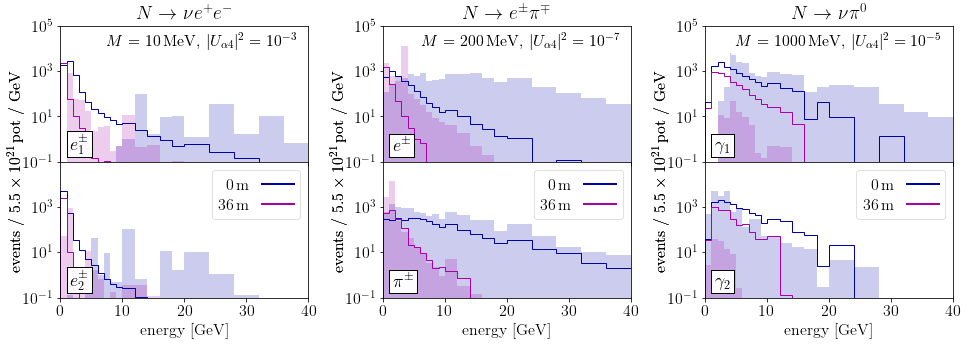

In [147]:
# original / paper

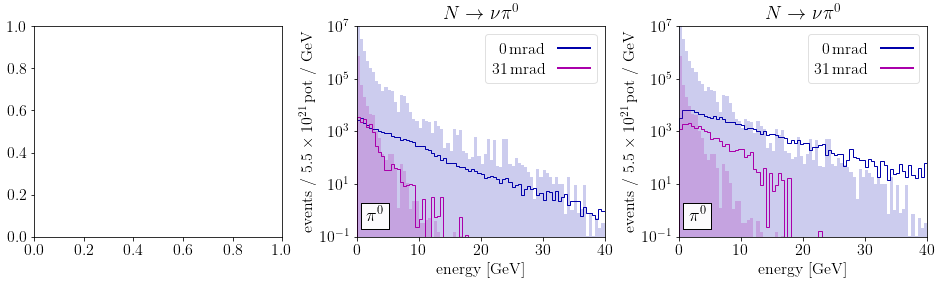

In [308]:
# CAUTION: the following does not include the theta cut
#
# fig        = plt.figure(figsize=(16,24))
# outer_grid = fig.add_gridspec(5, 3, wspace=0.3, hspace=0.3)
# for i, ch in enumerate(['nPI0']):
#     for j, (M, Usq) in enumerate(zip(M_array, Usq_array)):
#         my_norm_bg  = 5.5e21/DUNE_pot / np.mean(np.diff(my_bin_edges[j]))
#         my_norm_sig = Usq * my_norm_bg
#         ax = fig.add_subplot(outer_grid[i*len(M_array) + j])
#         for k, th in enumerate(oa_angles[[0,3]]):
#             if len(E_sig_array[j,k][ch].flatten()) <= 0 or len(E_bg_array[k,ch].flatten()) <= 0:
#                 continue
                
#             E_sig_1_array = E_sig_array[j,k][ch][:,0]
#             E_bg_1_array  = E_bg_array[k,ch][:,0]

#             # plot signal and background histograms
#             ax.hist(E_sig_1_array/u.GeV, bins=my_bin_edges[j], histtype='step', color=my_signal_colors[k],
#                      weights=weight_sig_array[j,k][ch] * my_norm_sig, label=r'{:.02g}\,mrad'.format(1000*th))
#             ax.hist(E_bg_1_array/u.GeV, bins=my_bin_edges[j], histtype='stepfilled', color=my_bg_colors[k],
#                      weights=weight_bg_array[k,ch] * my_norm_bg)
#             ax.set_xlim(my_bin_edges[j][0], my_bin_edges[j][-1])
#             ax.set_ylim(0.1,1e7)
#             ax.set_yscale('log')
#             ax.set_xlabel(r'energy [GeV]')
#             ax.set_ylabel(r'events / $5.5 \times 10^{21}\,\text{pot}$ / GeV')
#             ax.set_title(r'$N \to\ ${:s}'.format(decay_labels[ch])) 
#             ax1.annotate(r'$M$ = {:g}\,MeV, $|U_{{\alpha 4}}|^2 = 10^{{{:g}}}$'.format(M/u.MeV, np.round(np.log10(Usq))),
#                          (0.95,0.95), xycoords='axes fraction', backgroundcolor='#ffffffaa', ha='right', va='top')
#             ax.annotate(decay_particle_labels[ch][-1], (0.04,0.06), xycoords='axes fraction',
#                         size=18, ha='left', va='bottom', bbox=dict(boxstyle='square,pad=0.3', ec='black', fc=(1,1,1,.8)))

#             my_legend_lines  = [ mpl.lines.Line2D([0], [0], color=my_signal_colors[k], lw=2) for k in range(2) ]
#             my_legend_labels = [ r'{:d}\,mrad'.format(int(th*1000)) for th in oa_angles[[0,3]] ]
#             my_legend = ax.legend(my_legend_lines, my_legend_labels, loc='upper right', labelspacing=0.2, framealpha=0.6)
#             vp = my_legend._legend_box._children[-1]._children[0]
#             for c in vp._children:
#                 c._children.reverse()
#             vp.align="right" 

# fig.savefig('hnl-event-spectrum-3.pdf', bbox_inches=subplot_inches(outer_grid,0,2))
# plt.show()

<ipython-input-309-e50f89f50fb2>:22: RuntimeWarning: divide by zero encountered in log10
  ax[k].hist2d(mm[1].flatten(), mm[0].flatten(), bins=my_bin_edges[j], weights=np.log10(sig_hist.flatten()), cmin=0,cmax=10)
/usr/local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6931: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None
<ipython-input-309-e50f89f50fb2>:25: RuntimeWarning: divide by zero encountered in log10
  ax[k].contour(my_bin_centers, my_bin_centers, np.log10(bg_hist.T), levels=np.linspace(0,10,20), cmap=mpl.cm.cool)


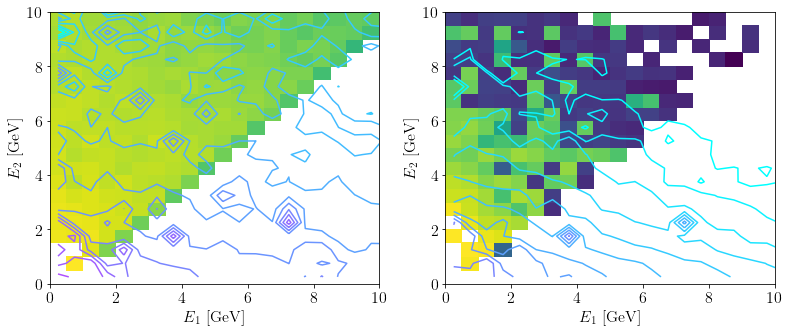

In [309]:
# 2d histograms
ch = 'EPI'
j  = 1
my_norm = 1e22/DUNE_pot / np.mean(np.diff(my_bin_edges[j]))

plt.figure(figsize=(13,5))
ax = [ plt.subplot(121), plt.subplot(122) ]

for k, th in enumerate(oa_angles[[0,3]]):
    if len(E_sig_array[j,k][ch].flatten()) <= 0 or len(E_bg_array[k,ch].flatten()) <= 0:
        continue
    E_sig_1_array = E_sig_array[j,k][ch][:,0]
    E_bg_1_array  = E_bg_array[k,ch][:,0]
    E_sig_2_array = E_sig_array[j,k][ch][:,1]
    E_bg_2_array  = E_bg_array[k,ch][:,1]
    
    sig_hist, dummy_x, dummy_y = np.histogram2d(E_sig_1_array/u.GeV, E_sig_2_array/u.GeV, my_bin_edges[j], weights=weight_sig_array[j,k][ch].flatten())
    bg_hist,  dummy_x, dummy_y = np.histogram2d(E_bg_1_array/u.GeV,  E_bg_2_array/u.GeV,  [my_bin_edges[j],my_bin_edges[j]], weights=weight_bg_array[k,ch].flatten())

    my_bin_centers = 0.5*(my_bin_edges[j][1:]+my_bin_edges[j][:-1])
    mm = np.meshgrid(my_bin_centers,my_bin_centers)
    ax[k].hist2d(mm[1].flatten(), mm[0].flatten(), bins=my_bin_edges[j], weights=np.log10(sig_hist.flatten()), cmin=0,cmax=10)
#    ax[k].hist2d(mm[1].flatten(), mm[0].flatten(), bins=my_bin_edges[j], weights=np.log10(bg_hist.flatten()), cmap=mpl.cm.cool)
#    ax[k].contour(my_bin_centers, my_bin_centers, np.log10(sig_hist.T), levels=np.linspace(0,10,20))
    ax[k].contour(my_bin_centers, my_bin_centers, np.log10(bg_hist.T), levels=np.linspace(0,10,20), cmap=mpl.cm.cool)
    
    ax[k].set_xlabel(r'$E_1$ [GeV]')
    ax[k].set_ylabel(r'$E_2$ [GeV]')
    ax[k].set_xlim(0,10)
    ax[k].set_ylim(0,10)

plt.show()

## HNL Flux

In [140]:
Ds_only       = False
M_array       = np.array([10, 200, 1000]) * u.MeV
oa_intervals  = np.array([ [0.,0.01], [0.01,0.02], [0.02,0.03], [0.03,0.04], [0.04,0.05] ])

this_U        = 1.
my_flux       = {}
E_array       = {}
P_array       = {}
theta_array   = {}
theta_x_array = {}
theta_y_array = {}
for j, M in enumerate(M_array):
    # load signal events from files
    my_flux[j] = HNL_flux()
    if Ds_only:
        my_flux[j].load_HNL_fluxes(M, Ue4=this_U, Um4=this_U, Ut4=this_U, small_files=False, include_pi_K=False)
    else:
        my_flux[j].load_HNL_fluxes(M, Ue4=this_U, Um4=this_U, Ut4=this_U, small_files=False)
    E_array[j]       = my_flux[j].p_array[0,:]                             # HNL energies
    P_array[j]       = my_flux[j].p_array[1:4,:]                           # HNL 3-momenta
    theta_array[j]   = np.arctan2(np.sqrt(P_array[j][0,:]**2 + P_array[j][1,:]**2), P_array[j][2,:])
    theta_x_array[j] = np.arctan2(P_array[j][0,:], P_array[j][2,:])  # horizontal deviation from beam axis
    theta_y_array[j] = np.arctan2(P_array[j][1,:], P_array[j][2,:])  # vertical deviation from beam axis

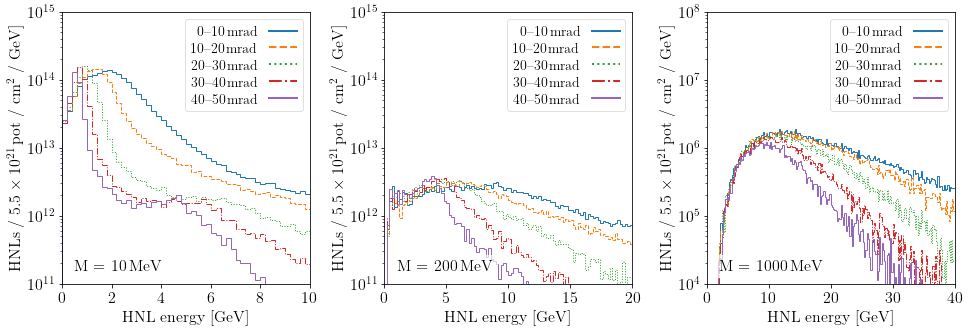

In [142]:
my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
my_ls     = ['-','--',':','-.']

plt.figure(figsize=(16,5))
ax = [ plt.subplot(131), plt.subplot(132), plt.subplot(133) ]
E_bin_edges  = np.linspace(0,40,201) * u.GeV
E_bin_widths = np.diff(E_bin_edges)
for j, M in enumerate(M_array):
    for k, [theta_min, theta_max] in enumerate(oa_intervals):
        i_list = np.where((theta_min <= np.abs(theta_x_array[j])) & (np.abs(theta_x_array[j]) < theta_max) &
                          (oa_intervals[0][0] <= np.abs(theta_y_array[j])) & (np.abs(theta_y_array[j]) < oa_intervals[0][1]))
#        i_list = np.arange(len(theta_array[j])) # FIXME FIMXE
        beam_area = 4 * (oa_intervals[0][1] - oa_intervals[0][0]) * (theta_max - theta_min) * ND_baseline**2
                            # factor 4 because we allow for positive and negative angles
        ax[j].hist(E_array[j][i_list]/u.GeV, bins=E_bin_edges/u.GeV,
                   histtype='step', color=my_colors[k], linestyle=my_ls[k % len(my_ls)],
                   weights=my_flux[j].weight_array[i_list] * u.cm**2/beam_area * 5.5e21/DUNE_pot * u.GeV/np.mean(E_bin_widths))
    ax[j].set_xlabel('HNL energy [GeV]')
    ax[j].set_ylabel('HNLs / $5.5 \\times 10^{21}\,\\text{pot}$ / cm$^2$ / GeV]')
    ax[j].set_yscale('log')
    ax[j].annotate('M = {:g}\,MeV'.format(M/u.MeV), (0.05,0.05), xycoords='axes fraction', backgroundcolor='#ffffffaa')

if Ds_only:
    ax[0].set_ylim(bottom=1e4, top=1e7)
    ax[0].set_xlim(0,10)
    ax[1].set_ylim(bottom=1e4, top=1e7)
    ax[1].set_xlim(0,20)
    ax[2].set_ylim(bottom=1e4, top=1e7)
    ax[2].set_xlim(0,40)
else:
    ax[0].set_ylim(bottom=1e11, top=1e15)
    ax[0].set_xlim(0,10)
    ax[1].set_ylim(bottom=1e11, top=1e15)
    ax[1].set_xlim(0,20)
    ax[2].set_ylim(bottom=1e4, top=1e8)
    ax[2].set_xlim(0,40)
plt.subplots_adjust(wspace=0.3)

my_legend_lines  = [ mpl.lines.Line2D([0], [0], color=my_colors[k], ls=my_ls[k%len(my_ls)], lw=2) for k in range(len(oa_intervals)) ]
my_legend_labels = [ r'{:2d}--{:2d}\,mrad'.format(int(1e3*th_min),int(1e3*th_max)) for [th_min, th_max] in oa_intervals ]
for j, M in enumerate(M_array):
    my_legend = ax[j].legend(my_legend_lines, my_legend_labels, loc='upper right', fontsize=14,
                             handlelength=2, labelspacing=0.2, framealpha=0.6)
    vp = my_legend._legend_box._children[-1]._children[0]
    for c in vp._children:
        c._children.reverse()
    vp.align="right" 
plt.savefig('hnl-flux.pdf')
plt.show()

In [330]:
# read a dk2nu file directly to see if the neutrino spectrum there agrees with the low-M HNL spectrum
with uproot.open('data/dk2nu/g4lbne_v3r5p4_QGSP_BERT_OptimizedEngineeredNov2017_neutrino_00001.dk2nu.root') as f:
    dk2nu_data = f['dk2nuTree']['dk2nu']['nuray']
    dk2nu_E_nu_table   = dk2nu_data['nuray.E'].array()[:,1] * u.GeV
    dk2nu_p_nu_table   = np.array([ dk2nu_data['nuray.px'].array()[:,1],
                                    dk2nu_data['nuray.py'].array()[:,1],
                                    dk2nu_data['nuray.pz'].array()[:,1] ]) * u.GeV
    dk2nu_weight_table = dk2nu_data['nuray.wgt'].array()[:,1]
    
dk2nu_theta_array   = np.arctan2(np.sqrt(dk2nu_p_nu_table[0]**2 + dk2nu_p_nu_table[1]**2), dk2nu_p_nu_table[2])  # overall deviation from beam axis
dk2nu_theta_x_array = np.arctan2(dk2nu_p_nu_table[0], dk2nu_p_nu_table[2])  # horizontal deviation from beam axis
dk2nu_theta_y_array = np.arctan2(dk2nu_p_nu_table[1], dk2nu_p_nu_table[2])  # vertical deviation from beam axis

In [346]:
np.where((0.03 <= np.abs(dk2nu_theta_x_array)) & (np.abs(dk2nu_theta_x_array) < 0.04))

(array([ 2102,  2103, 98167, 98168]),)

0.0 0.01
(array([     1,      2,      4, ..., 102460, 102461, 102462]),)
0.0 0.01 (array([     1,      2,      4, ..., 102460, 102461, 102462]),)
0.01 0.02
(array([     0,      3,     16, ..., 102428, 102431, 102434]),)
0.01 0.02 (array([     0,      3,     16, ..., 102428, 102431, 102434]),)
0.02 0.03
(array([91792, 98740, 98741]),)
0.02 0.03 (array([91792, 98740, 98741]),)
0.03 0.04
(array([ 2102,  2103, 98167, 98168]),)
0.03 0.04 (array([ 2102,  2103, 98167, 98168]),)
0.04 0.05
(array([6581, 6582]),)
0.04 0.05 (array([6581, 6582]),)


(0, 1e-11)

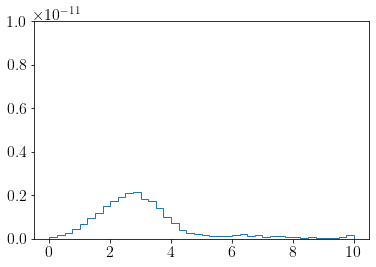

In [342]:
E_bin_widths = np.linspace(0,10,41) * u.GeV
for k, [theta_min, theta_max] in enumerate(oa_intervals):
    print(theta_min,theta_max)
    print(np.where((theta_min <= np.abs(dk2nu_theta_x_array)) & (np.abs(dk2nu_theta_x_array) < theta_max)))
    i_list = np.where((theta_min <= np.abs(dk2nu_theta_x_array)) & (np.abs(dk2nu_theta_x_array) < theta_max) &
                      (oa_intervals[0][0] <= np.abs(dk2nu_theta_y_array)) & (np.abs(dk2nu_theta_y_array) < 5*oa_intervals[0][1]))
    print(theta_min, theta_max, i_list)
    beam_area = 4 * (5*oa_intervals[0][1] - oa_intervals[0][0]) * (theta_max - theta_min) * ND_baseline**2
                            # factor 4 because we allow for positive and negative angles
    plt.hist(dk2nu_E_nu_table[i_list]/u.GeV, bins=E_bin_widths/u.GeV, histtype='step',
             weights=dk2nu_weight_table[i_list]/len(dk2nu_E_nu_table) * u.cm**2/beam_area * u.GeV/np.mean(E_bin_widths))
plt.ylim(0,1e-11)
    

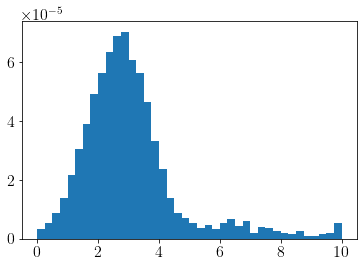

In [192]:
plt.hist(dk2nu_E_nu_table/u.GeV, bins=np.linspace(0,10,41), weights=dk2nu_weight_table/len(dk2nu_E_nu_table))
plt.show()

## Neutrino Flux at 60 m off-axis

In [72]:
M             = 0.
my_flux       = {}
E_array       = {}
P_array       = {}
theta_array   = {}
theta_x_array = {}
theta_y_array = {}

my_flux['E'] = HNL_flux()
my_flux['M'] = HNL_flux()
my_flux['T'] = HNL_flux()
my_flux['E'].load_HNL_fluxes(M, Ue4=1., Um4=0., Ut4=0., small_files=False)
my_flux['M'].load_HNL_fluxes(M, Ue4=0., Um4=1., Ut4=0., small_files=False)
my_flux['T'].load_HNL_fluxes(M, Ue4=0., Um4=0., Ut4=1., small_files=False)

for f in my_flux:
    E_array[f]       = my_flux[f].p_array[0,:]                             # HNL energies
    P_array[f]       = my_flux[f].p_array[1:4,:]                           # HNL 3-momenta
    theta_array[f]   = np.arctan2(np.sqrt(P_array[f][0,:]**2 + P_array[f][1,:]**2), P_array[f][2,:])
    theta_x_array[f] = np.arctan2(P_array[f][0,:], P_array[f][2,:])  # horizontal deviation from beam axis
    theta_y_array[f] = np.arctan2(P_array[f][1,:], P_array[f][2,:])  # vertical deviation from beam axis

In [139]:
# load Claudia's NuMI off-axis flux for comparison
flux_table_numi_claudia = np.loadtxt('data/claudia/offaxis-bg-flux.dat')
flux_table_numi_claudia_reduced = flux_table_numi_claudia[(flux_table_numi_claudia[:,0]==950.) & (flux_table_numi_claudia[:,1]==6.1)][:,[2,3]]
flux_table_numi_claudia_reduced[:,0] *= u.GeV
flux_table_numi_claudia_reduced[:,1] *= 5.5e21 / 6e20 / u.GeV / (78.54*u.m**2)

# load NuMI off-axis flux from https://arxiv.org/abs/0809.2447
flux_table_numi = np.loadtxt('sim/fluxes/numi-oa-flux-0809.2446.dat')
flux_table_numi[:,0] *= u.GeV
flux_table_numi[:,1] *= 5.5e21 / 1e6 / u.m**2 / (50*u.MeV)


<ipython-input-141-01f6bd6b8042>:29: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[j].set_yscale('log')


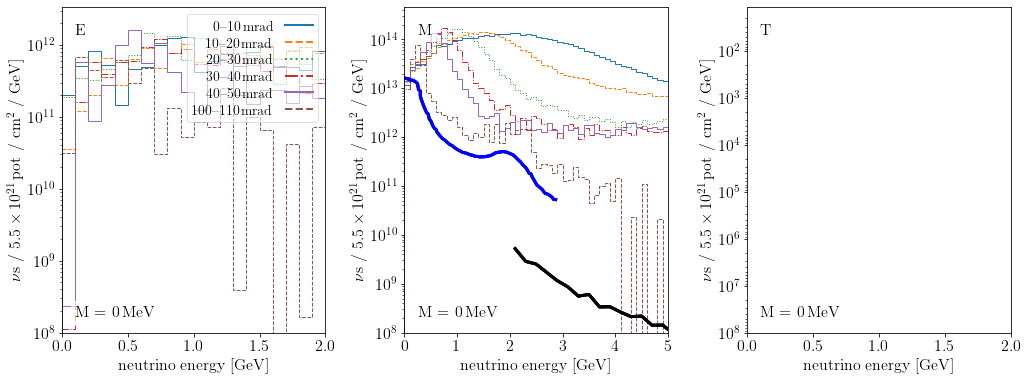

In [141]:
# plot and export neutrino flux at 60 m off-axis
my_colors    = plt.rcParams['axes.prop_cycle'].by_key()['color']
my_ls        = ['-','--',':','-.']
oa_intervals = np.array([ [0.,0.01], [0.01,0.02], [0.02,0.03], [0.03,0.04], [0.04,0.05], [0.10,0.11] ])
lumi         = 5.5e21

plt.figure(figsize=(17,6))
ax = [ plt.subplot(131), plt.subplot(132), plt.subplot(133) ]
plt.subplots_adjust(wspace=0.3)
E_bin_edges   = np.linspace(0,5,51)*u.GeV
E_bin_centers = 0.5 * (E_bin_edges[1:] + E_bin_edges[:-1])
E_bin_widths  = np.diff(E_bin_edges)
flux_hist     = {}
for j, f in enumerate(my_flux):
    for k, [theta_min, theta_max] in enumerate(oa_intervals):
        i_list = np.where((theta_min <= np.abs(theta_x_array[f])) & (np.abs(theta_x_array[f]) < theta_max) &
                          (oa_intervals[0][0] <= np.abs(theta_y_array[f])) & (np.abs(theta_y_array[f]) < 0.5*oa_intervals[0][1]))
        beam_area = 4 * (0.5*oa_intervals[0][1] - oa_intervals[0][0]) * (theta_max - theta_min) * ND_baseline**2
                            # factor 4 because we allow for positive and negative angles
        flux_hist[f,k], dummy_bins, dummy_patches \
            = ax[j].hist(E_array[f][i_list]/u.GeV, bins=E_bin_edges/u.GeV,
                         histtype='step', color=my_colors[k], linestyle=my_ls[k % len(my_ls)],
                         weights=my_flux[f].weight_array[i_list] * u.cm**2/beam_area * lumi/DUNE_pot * u.GeV/np.mean(E_bin_widths))
    ax[1].plot(flux_table_numi_claudia_reduced[:,0]/u.GeV, flux_table_numi_claudia_reduced[:,1]*u.GeV*u.cm**2, c='k', lw=3)
    ax[1].plot(flux_table_numi[:,0]/u.GeV, flux_table_numi[:,1]*u.GeV*u.cm**2, c='b', lw=3)
    ax[1].set_xlim(0,5)
    ax[j].set_xlabel(r'neutrino energy [GeV]')
    ax[j].set_ylabel(r'$\nu$s / $5.5 \times 10^{21}\,\text{pot}$ / cm$^2$ / GeV]')
    ax[j].set_yscale('log')
    ax[j].set_ylim(bottom=1e8)
    ax[j].annotate('M = {:g}\,MeV'.format(M/u.MeV), (0.05,0.05), xycoords='axes fraction', backgroundcolor='#ffffffaa')
    ax[j].annotate(f, (0.05,0.95), xycoords='axes fraction', ha='left', va='top', backgroundcolor='#ffffffaa')

#    ax[j].set_ylim(bottom=0, top=5e-8)
    ax[j].set_xlim(0,2)

my_legend_lines  = [ mpl.lines.Line2D([0], [0], color=my_colors[k], ls=my_ls[k%len(my_ls)], lw=2) for k in range(len(oa_intervals)) ]
my_legend_labels = [ r'{:2d}--{:2d}\,mrad'.format(int(1e3*th_min),int(1e3*th_max)) for [th_min, th_max] in oa_intervals ]
my_legend = ax[0].legend(my_legend_lines, my_legend_labels, loc='upper right', fontsize=14,
                         handlelength=2, labelspacing=0.2, framealpha=0.6)
vp = my_legend._legend_box._children[-1]._children[0]
for c in vp._children:
    c._children.reverse()
vp.align="right" 
plt.savefig('neutrino-flux.pdf')
plt.show()

In [134]:
np.savetxt('nu-flux-60m.dat', np.array([ E_bin_centers/u.GeV,
                                         flux_hist['E', len(oa_intervals)-1] / lumi,
                                         flux_hist['M', len(oa_intervals)-1] / lumi,
                                         flux_hist['T', len(oa_intervals)-1] / lumi,
                                         np.zeros(E_bin_centers.shape),
                                         np.zeros(E_bin_centers.shape),
                                         np.zeros(E_bin_centers.shape) ]).T,
          fmt='%10.5g',
          header='DUNE-PRISM neutrino flux at L=574 m, d_oa=60 m\n' +
                 '\n' +
                 ' E [GeV]                  fluxes [neutrinos/GeV/cm^2/pot]\n' +
                 '            nu_e      nu_mu        nu_tau   antinu_e  antinu_mu  antinu_tau')

In [103]:
flux_interp_numi = interp.interp1d(flux_table_numi_reduced[:,0]*u.GeV, flux_table_numi_reduced[:,1]/u.cm**2/u.GeV)
II = integ.quad(lambda E: flux_interp_numi(E) * 0.8e-38*u.cm**2/u.GeV * E * 0.3, 0.2*u.GeV, 1*u.GeV)[0]
II

1.27e-27

In [104]:
II * 430*u.tons/u.m_p

3.27e+05

## HNL Decay Branching Ratios

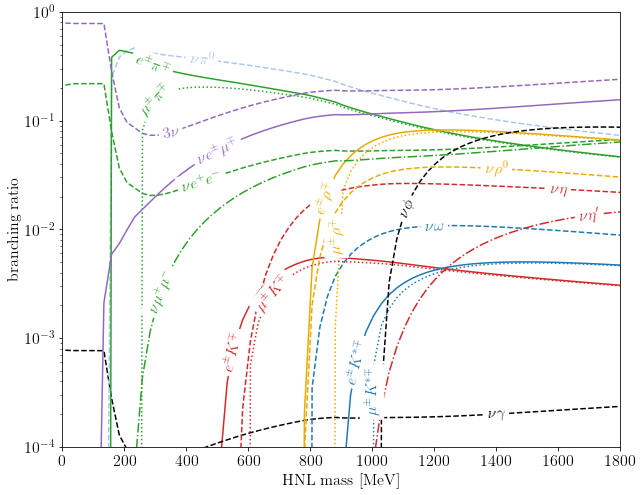

In [290]:
#my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#my_ls     = ['-','--',':','-.']
decay_label_pos = { 'EPI':    290*u.MeV,    'MPI':    300*u.MeV,
                    'EKA':    550*u.MeV,    'MKA':    680*u.MeV,
                    'ERHO':   850*u.MeV,    'MRHO':   885*u.MeV,
                    'EKAx':   950*u.MeV,    'MKAx':   1000*u.MeV,
                    'ECHARM': 0*u.MeV,      'nEM':    500*u.MeV,
                    'nET':    0*u.MeV,      'TPI':    0*u.MeV,
                    'nnn':    350*u.MeV,    'nEE':    450*u.MeV,
                    'nMM':    320*u.MeV,    'nPI0':   450*u.MeV,
                    'nRHO0':  1400*u.MeV,   'nOMEGA': 1200*u.MeV,
                    'nETA':   1600*u.MeV,   'nETAi':  1700*u.MeV,
                    'nPHI':   1110*u.MeV,   'nGAMMA': 1400*u.MeV,
                    'nMT':    0 }

plt.figure(figsize=(10,8))
for j, c in enumerate(decay_channels):
    M_range = np.linspace(10, 2e3, 81) * u.MeV
    plt.plot(M_range/u.MeV, decay_br_interp[c+'-EMT'](M_range), label=decay_labels[c],
             color=decay_colors[c], linestyle=decay_ls[c])
    if decay_label_pos[c] > 0:
        plt.annotate(decay_labels[c], (decay_label_pos[c]/u.MeV, decay_br_interp[c+'-EMT'](decay_label_pos[c])),
                     color=decay_colors[c], backgroundcolor='#ffffff', ha='center', va='center',
                     rotation=180/np.pi * np.arctan(spmisc.derivative(lambda M:
                        np.log10(decay_br_interp[c+'-EMT'](300*M*u.MeV)), (decay_label_pos[c]/u.MeV)/300, dx=0.1)))
plt.yscale('log')
plt.xlim(0, 1800)
plt.ylim(1e-4,1)
plt.xlabel('HNL mass [MeV]')
plt.ylabel('branching ratio')
#plt.legend(loc='lower right', ncol=2, labelspacing=0.2, framealpha=0.6)
plt.savefig('hnl-br.pdf')
plt.show()